In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load data with the updated file paths
train_data = pd.read_csv('../data/raw/train/ticdata2000.txt', sep='\t', header=None)
eval_data = pd.read_csv('../data/raw/eval/ticeval2000.txt', sep='\t', header=None)
target_data = pd.read_csv('../data/raw/eval/tictgts2000.txt', sep='\t', header=None, names=['Target'])


In [3]:
missing_values = train_data.isnull().sum()
missing_values

0     0
1     0
2     0
3     0
4     0
     ..
81    0
82    0
83    0
84    0
85    0
Length: 86, dtype: int64

In [4]:

import re

# Load the content of the dictionary.txt file
with open('../docs/insurance+company+benchmark+coil+2000/dictionary.txt', 'r', encoding='ISO-8859-1') as file:
    file_content = file.read()


# Extract the Data Dictionary table using regular expressions
pattern = re.compile(r"(\d+)\s+([A-Z]+[A-Z0-9]*)\s+(.+?)(?=\d+\s+|L0:)", re.DOTALL)
matches = pattern.findall(file_content)

# Create a DataFrame from the matches
df = pd.DataFrame(matches, columns=['Nr', 'Name', 'Description'])

# Clean up the 'Description' column to remove extra line breaks and spaces
df['Description'] = df['Description'].str.replace('\n', ' ').str.strip()

# Convert 'Nr' column to integer
df['Nr'] = df['Nr'].astype(int)

# Display the DataFrame
df


Nr      Name                                   Description
0    1   MOSTYPE                        Customer Subtype see L
1    2  MAANTHUI                              Number of houses
2    3   MGEMOMV                            Avg size household
3    4  MGEMLEEF                                 Avg age see L
4    5  MOSHOOFD                      Customer main type see L
..  ..       ...                                           ...
81  82  APLEZIER                       Number of boat policies
82  83    AFIETS                    Number of bicycle policies
83  84   AINBOED         Number of property insurance policies
84  85  ABYSTAND  Number of social security insurance policies
85  86   CARAVAN                Number of mobile home policies

[86 rows x 3 columns]

In [5]:

# Define a pattern to extract each L table (L0, L1, L2, L3, L4)
l_tables_pattern = re.compile(r"(L\d+):\n\n(.*?)\n\n", re.DOTALL)
l_tables_matches = l_tables_pattern.findall(file_content)

# Dictionary to store the DataFrames
l_tables_dict = {}

# Process each L table
for table_name, table_content in l_tables_matches:
    # Split the table content into lines
    lines = table_content.strip().split('\n')
    
    # Split each line into two parts: value and label
    data = [line.split(maxsplit=1) for line in lines if len(line.split(maxsplit=1)) == 2]
    
    # Create a DataFrame and store it in the dictionary
    df1 = pd.DataFrame(data, columns=['Value', 'Label'])
    l_tables_dict[table_name] = df1

# Display the dictionary keys to confirm extraction
l_tables_dict.keys()
l_tables_dict['L0'] = l_tables_dict['L0'].iloc[1:].reset_index(drop=True)


In [7]:
# Create a list of new column names using the 'Name' column from df
new_column_names = df['Name'].tolist()

# Rename the columns in train_data using the new_column_names list
train_data.columns = new_column_names

# Display the updated DataFrame
train_data.head()

eda=train_data.copy()

In [9]:
# Step 1: Create a mapping dictionary for each L table
l_mapping_dict = {}

for l_name, df in l_tables_dict.items():
    # Create a dictionary mapping 'Value' to 'Label'
    mapping = dict(zip(df['Value'], df['Label']))
    l_mapping_dict[l_name] = mapping

# Step 2: Define a function to replace values using the appropriate mapping
def replace_values(df, column, mapping_dict):
    """
    Replace values in a DataFrame column using a mapping dictionary.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column to replace.
        column (str): The column name to replace values for.
        mapping_dict (dict): The dictionary to use for replacement.
        
    Returns:
        pd.Series: The column with replaced values.
    """
    return df[column].map(mapping_dict)

column_to_mapping = {
    'MOSTYPE': 'L0',
    'MGEMLEEF': 'L1',
    'MOSHOOFD': 'L2',
    'MGODRK': 'L3',
    'MGODPR': 'L3',
    'MGODOV': 'L3',
    'MGODGE': 'L3',
    'PWAPART': 'L4',
    'PWABEDR': 'L4',
    'PWALAND': 'L4',
}
# Step 3: Convert only categorical columns to strings and update mapping dictionaries
categorical_columns = list(column_to_mapping.keys())

# Convert only the specified categorical columns to strings
for column in categorical_columns:
    if column in eda.columns:
        eda[column] = eda[column].astype(str)

# Ensure mapping dictionary keys are strings
for l_table, mapping in l_mapping_dict.items():
    l_mapping_dict[l_table] = {str(k): v for k, v in mapping.items()}

# Step 4: Replace values for the relevant columns in the dataset
# Mapping the columns to their corresponding L tables from the Data Dictionary
for column, l_table in column_to_mapping.items():
    if column in eda.columns:  # Ensure the column exists in the dataset
        eda[column] = replace_values(eda, column, l_mapping_dict[l_table])

# Step 5: Verify the replacement
eda.head()


MOSTYPE  MAANTHUI  MGEMOMV     MGEMLEEF  \
0  Lower class large families         1        3  30-40 years   
1   Mixed small town dwellers         1        2  30-40 years   
2   Mixed small town dwellers         1        2  30-40 years   
3   Modern, complete families         1        3  40-50 years   
4          Large family farms         1        4  30-40 years   

                MOSHOOFD    MGODRK    MGODPR    MGODOV    MGODGE  MRELGE  ...  \
0  Family with grown ups        0%  50 - 62%   1 - 10%  24 - 36%       7  ...   
1  Family with grown ups   1 - 10%  37 - 49%   1 - 10%  37 - 49%       6  ...   
2  Family with grown ups        0%  37 - 49%  11 - 23%  37 - 49%       3  ...   
3         Average Family  11 - 23%  24 - 36%  11 - 23%  37 - 49%       5  ...   
4                Farmers   1 - 10%  37 - 49%   1 - 10%  37 - 49%       7  ...   

   APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  AFIETS  AINBOED  \
0         0        0        0       1        0         0       0        0   
1         0        0        0       1        0         0       0        0   
2         0        0        0       1        0         0       0        0   
3         0        0        0       1        0         0       0        0   
4         0        0        0       1        0         0       0        0   

   ABYSTAND  CARAVAN  
0         0        0  
1         0        0  
2         0        0  
3         0        0  
4         0        0  

[5 rows x 86 columns]

In [10]:
eda.shape

(5822, 86)

In [11]:
eda['CARAVAN'].value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


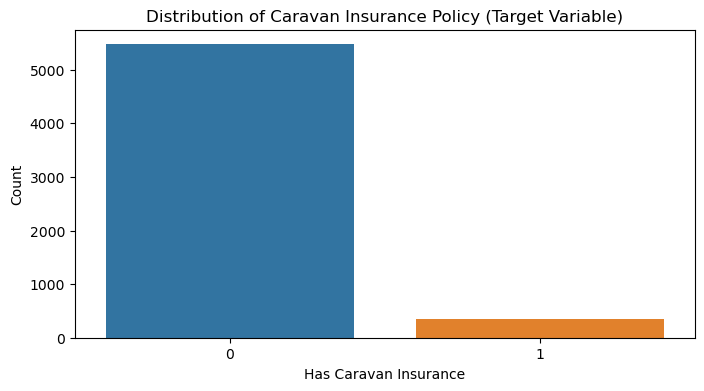

In [12]:
# EDA - Distribution of the target variable
plt.figure(figsize=(8, 4))
sns.countplot(eda['CARAVAN'])
plt.title('Distribution of Caravan Insurance Policy (Target Variable)')
plt.xlabel('Has Caravan Insurance')
plt.ylabel('Count')
plt.show()

In [13]:
# Correlation analysis
# Checking the correlation between features and the target
correlation = eda.corr()['CARAVAN'].sort_values(ascending=False)
print("\nTop 10 features positively correlated with CARAVAN:")
print(correlation.head(11)) # Including 'CARAVAN' itself

print("\nTop 10 features negatively correlated with CARAVAN:")
print(correlation.tail(11))


Top 10 features positively correlated with CARAVAN:
CARAVAN     1.000000
PPERSAUT    0.150910
APERSAUT    0.144210
APLEZIER    0.105700
MKOOPKLA    0.095938
PBRAND      0.094446
PPLEZIER    0.091361
MINKGEM     0.090185
AWAPART     0.089387
MOPLHOOG    0.084635
MHKOOP      0.078429
Name: CARAVAN, dtype: float64

Top 10 features negatively correlated with CARAVAN:
ABROM      -0.045116
MFALLEEN   -0.053102
MBERBOER   -0.054003
MBERARBO   -0.054632
MZFONDS    -0.058378
MRELOV     -0.062285
MSKD       -0.063070
MAUT0      -0.076501
MHHUUR     -0.079143
MINKM30    -0.079765
MOPLLAAG   -0.090561
Name: CARAVAN, dtype: float64


In [14]:
eda

MOSTYPE  MAANTHUI  MGEMOMV  \
0                     Lower class large families         1        3   
1                      Mixed small town dwellers         1        2   
2                      Mixed small town dwellers         1        2   
3                      Modern, complete families         1        3   
4                             Large family farms         1        4   
...                                          ...       ...      ...   
5817  Couples with teens 'Married with children'         1        1   
5818                            Village families         1        4   
5819                  Lower class large families         1        3   
5820                Large family, employed child         1        3   
5821                  Lower class large families         1        3   

         MGEMLEEF               MOSHOOFD    MGODRK    MGODPR    MGODOV  \
0     30-40 years  Family with grown ups        0%  50 - 62%   1 - 10%   
1     30-40 years  Family with grown ups   1 - 10%  37 - 49%   1 - 10%   
2     30-40 years  Family with grown ups        0%  37 - 49%  11 - 23%   
3     40-50 years         Average Family  11 - 23%  24 - 36%  11 - 23%   
4     30-40 years                Farmers   1 - 10%  37 - 49%   1 - 10%   
...           ...                    ...       ...       ...       ...   
5817  30-40 years  Family with grown ups        0%  63 - 75%   1 - 10%   
5818  50-60 years  Family with grown ups   1 - 10%  37 - 49%   1 - 10%   
5819  50-60 years  Family with grown ups        0%  63 - 75%        0%   
5820  30-40 years  Family with grown ups        0%  76 - 88%        0%   
5821  40-50 years  Family with grown ups        0%  63 - 75%   1 - 10%   

        MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
0     24 - 36%       7  ...         0        0        0       1        0   
1     37 - 49%       6  ...         0        0        0       1        0   
2     37 - 49%       3  ...         0        0        0       1        0   
3     37 - 49%       5  ...         0        0        0       1        0   
4     37 - 49%       7  ...         0        0        0       1        0   
...        ...     ...  ...       ...      ...      ...     ...      ...   
5817  11 - 23%       1  ...         0        0        0       1        0   
5818  37 - 49%       6  ...         0        0        0       1        0   
5819  24 - 36%       5  ...         0        0        0       1        0   
5820  11 - 23%       7  ...         0        0        0       0        0   
5821  11 - 23%       7  ...         0        0        0       0        0   

      APLEZIER  AFIETS  AINBOED  ABYSTAND  CARAVAN  
0            0       0        0         0        0  
1            0       0        0         0        0  
2            0       0        0         0        0  
3            0       0        0         0        0  
4            0       0        0         0        0  
...        ...     ...      ...       ...      ...  
5817         0       0        0         0        0  
5818         0       0        0         0        0  
5819         0       0        0         0        1  
5820         0       0        0         0        0  
5821         0       0        0         0        0  

[5822 rows x 86 columns]

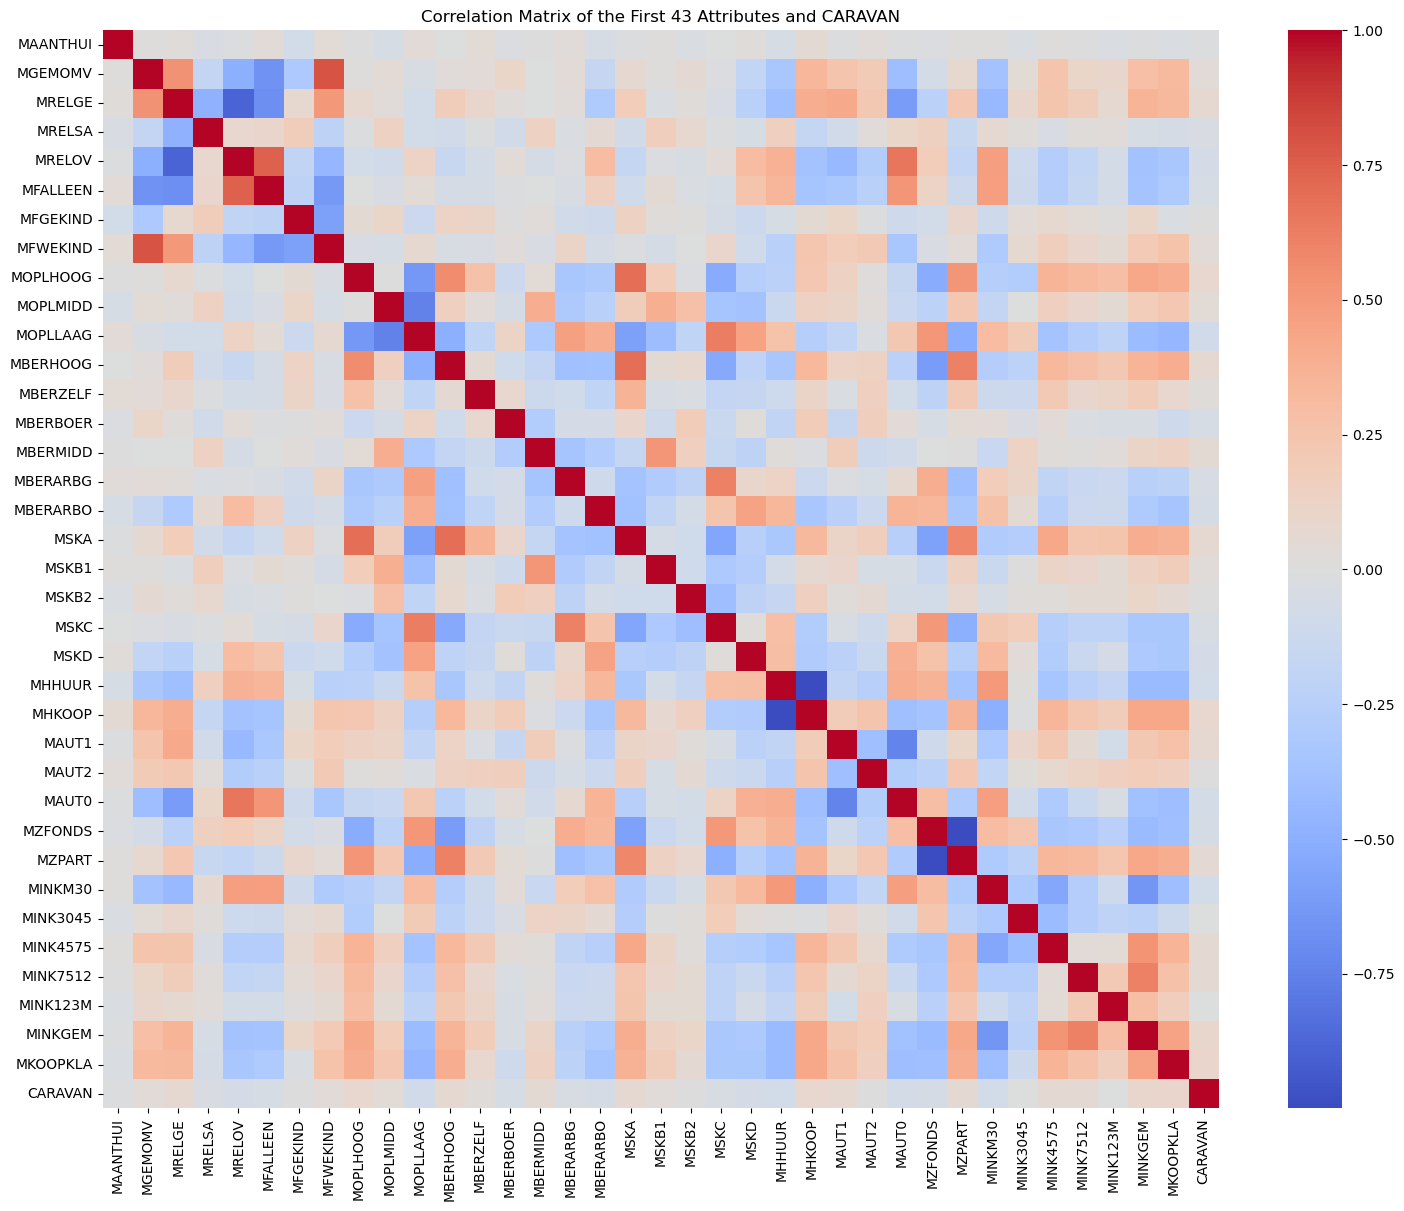

In [15]:
# Correlation matrix for the first 43 columns and the CARAVAN column
plt.figure(figsize=(18, 14))

subset_corr = eda.iloc[:, :43].join(eda['CARAVAN']).corr()

sns.heatmap(subset_corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix of the First 43 Attributes and CARAVAN')
plt.show()

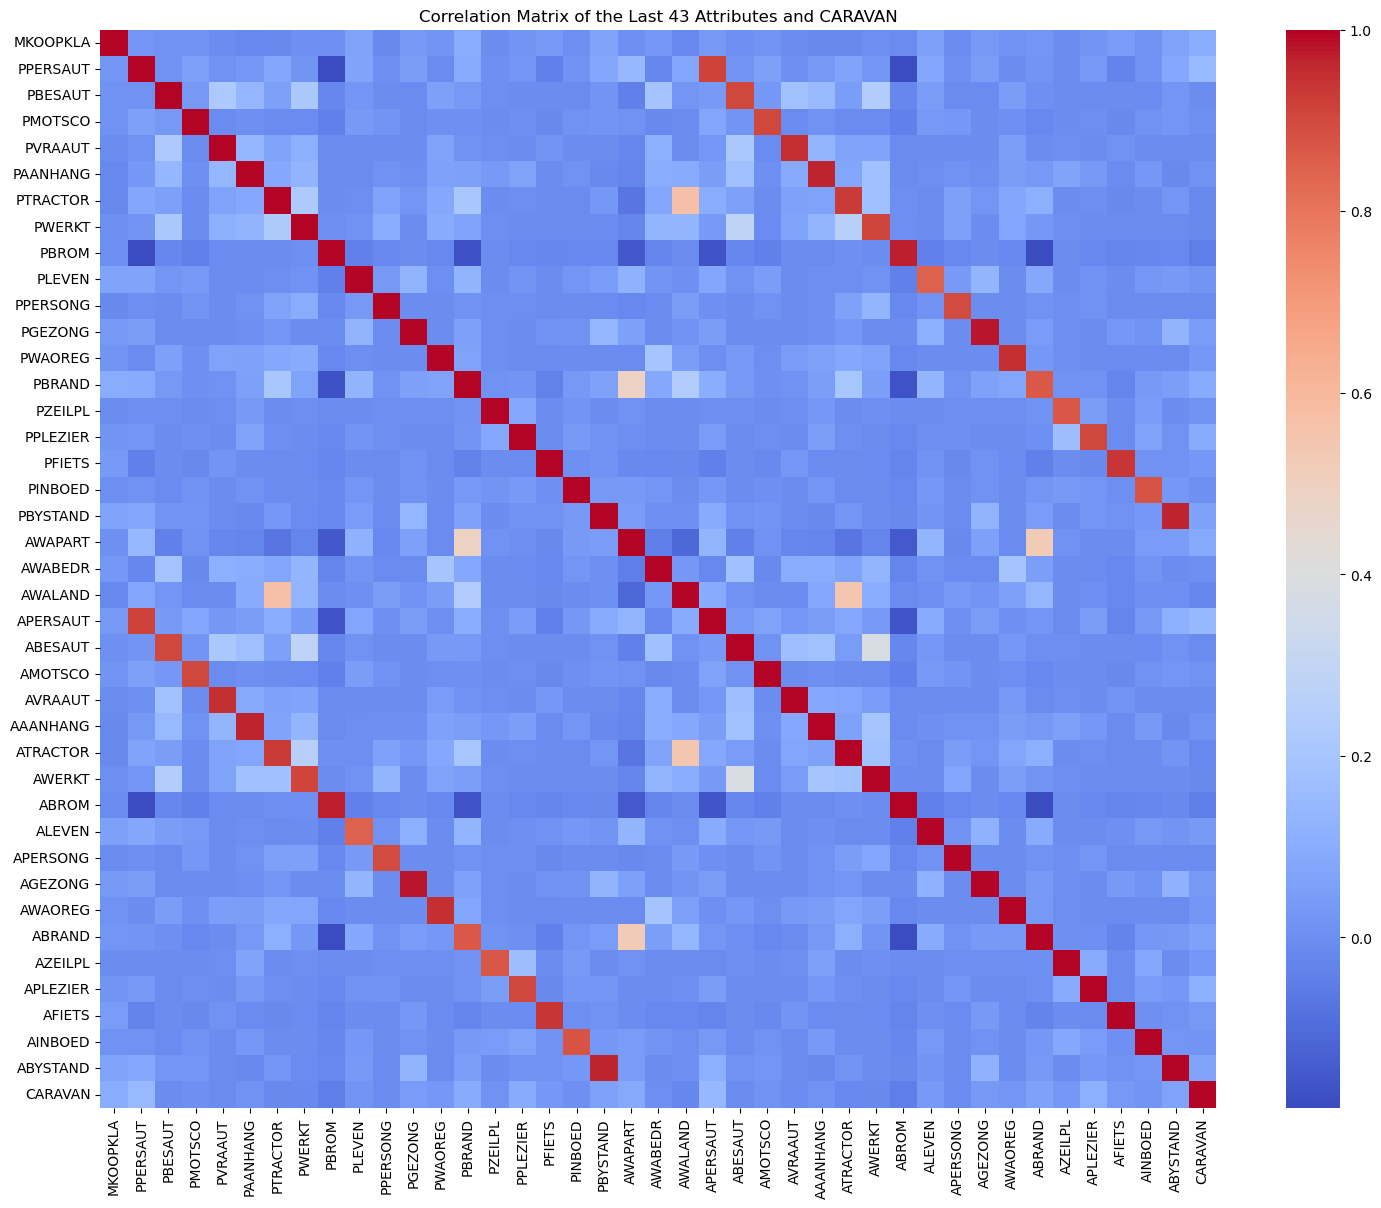

In [16]:
# Correlation matrix for the last 43 columns and the CARAVAN column
plt.figure(figsize=(18, 14))

subset_corr_last = eda.iloc[:, -44:].corr()  # Includes the last 43 columns and CARAVAN

sns.heatmap(subset_corr_last, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix of the Last 43 Attributes and CARAVAN')
plt.show()


In [18]:
# Display statistical summary for numerical features
summary_stats = eda.describe()
print("Statistical Summary:")
print(summary_stats)


Statistical Summary:
          MAANTHUI      MGEMOMV       MRELGE       MRELSA       MRELOV  \
count  5822.000000  5822.000000  5822.000000  5822.000000  5822.000000   
mean      1.110615     2.678805     6.183442     0.883545     2.290450   
std       0.405842     0.789835     1.909482     0.965924     1.722645   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%       1.000000     2.000000     5.000000     0.000000     1.000000   
50%       1.000000     3.000000     6.000000     1.000000     2.000000   
75%       1.000000     3.000000     7.000000     1.000000     3.000000   
max      10.000000     5.000000     9.000000     7.000000     9.000000   

          MFALLEEN     MFGEKIND     MFWEKIND     MOPLHOOG     MOPLMIDD  ...  \
count  5822.000000  5822.000000  5822.000000  5822.000000  5822.000000  ...   
mean      1.887667     3.230333     4.300240     1.461010     3.351254  ...   
std       1.799928     1.619973     2.005283     1.622967     1.761052  ...

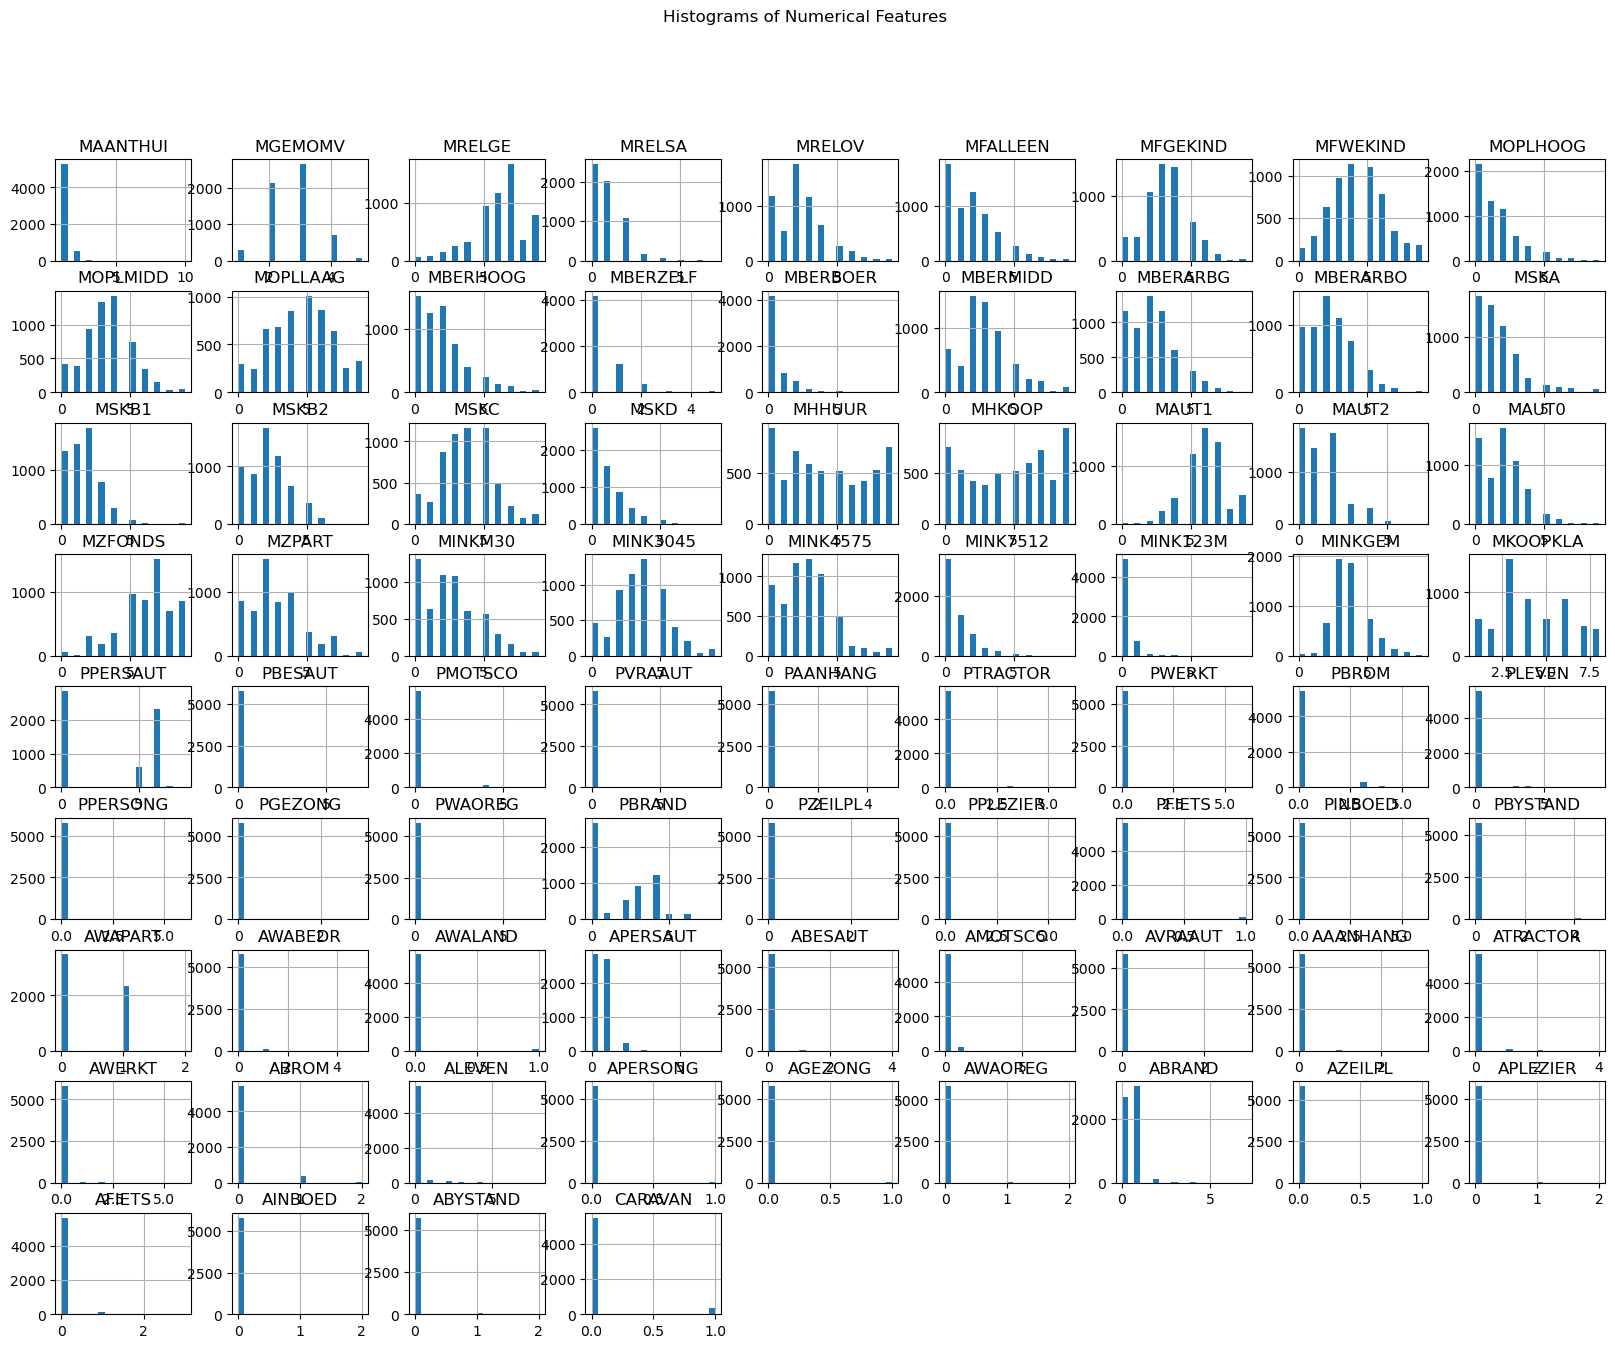

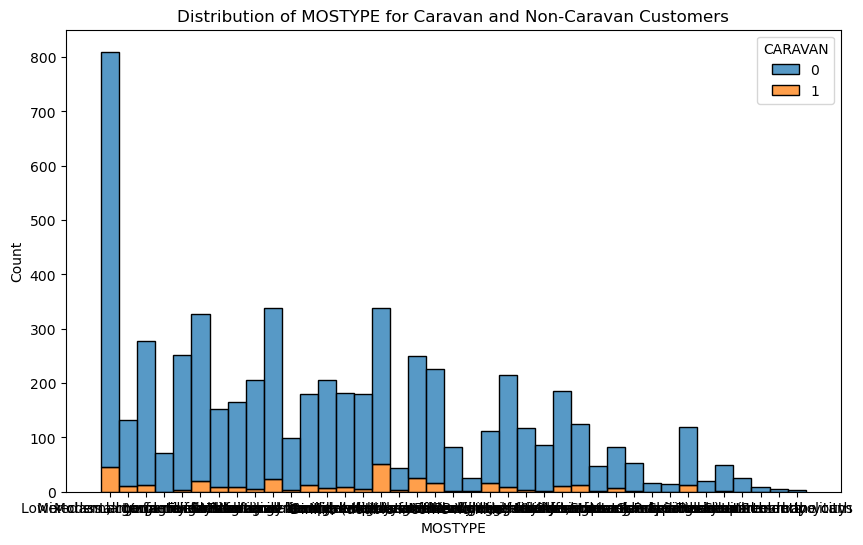

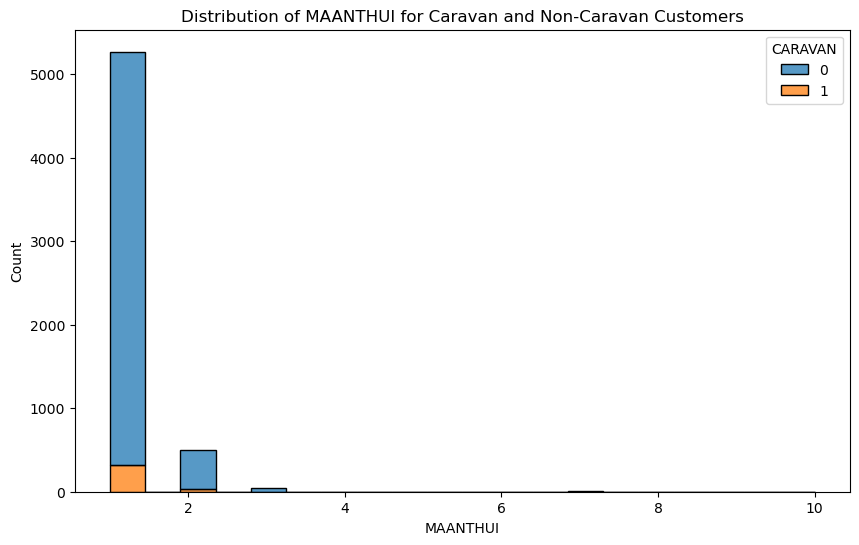

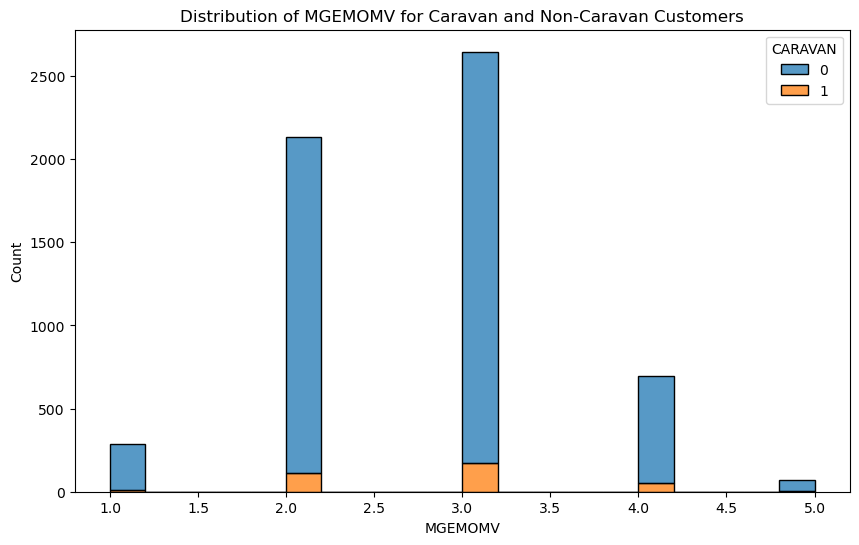

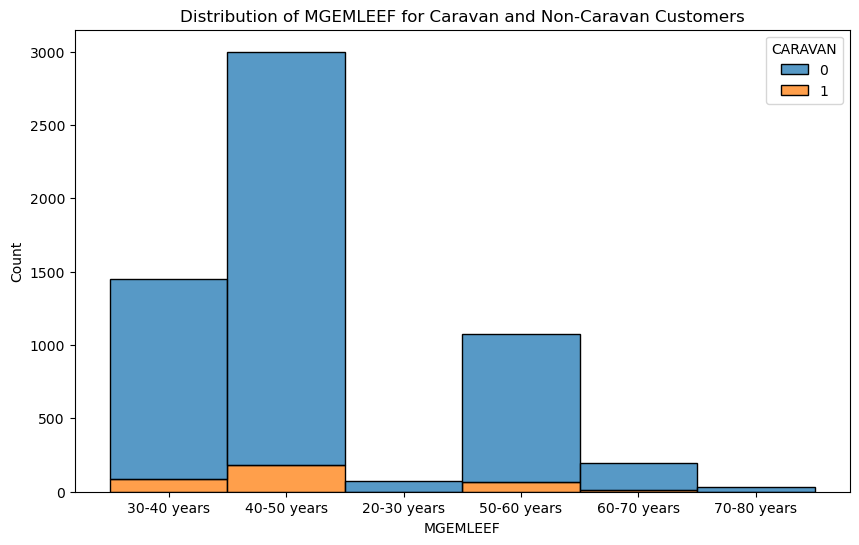

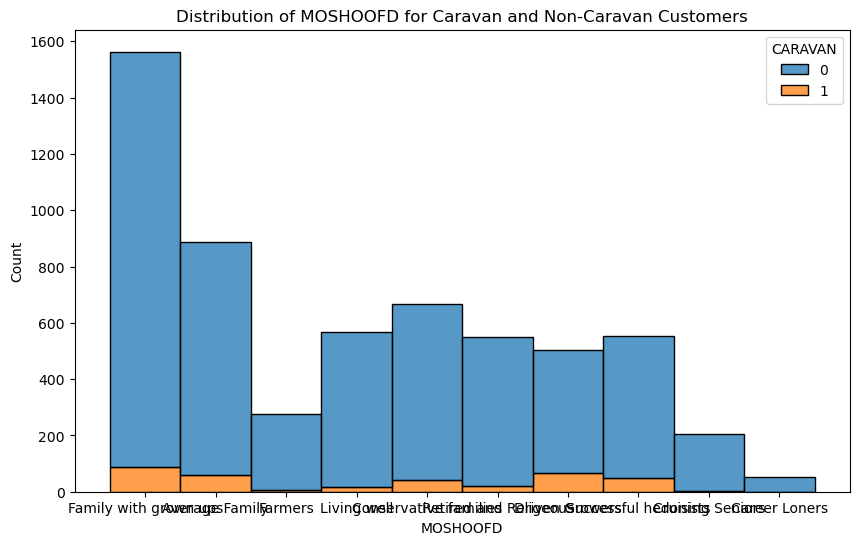

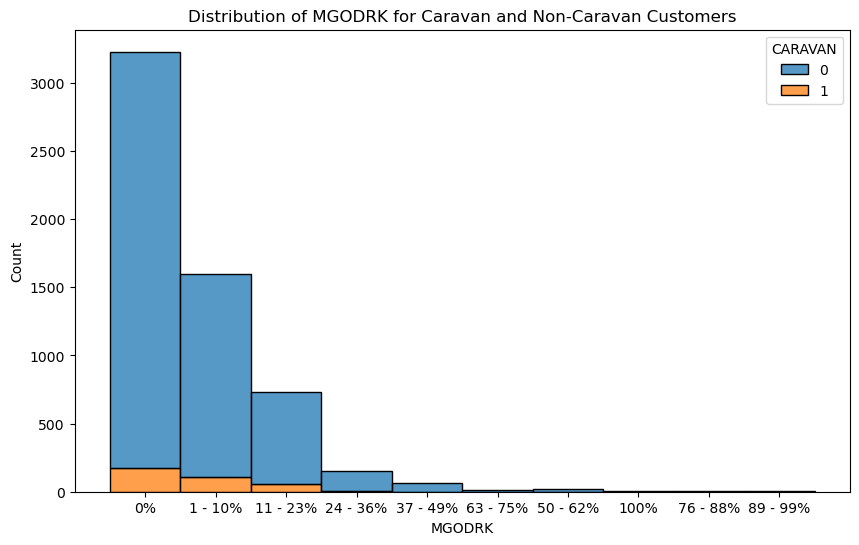

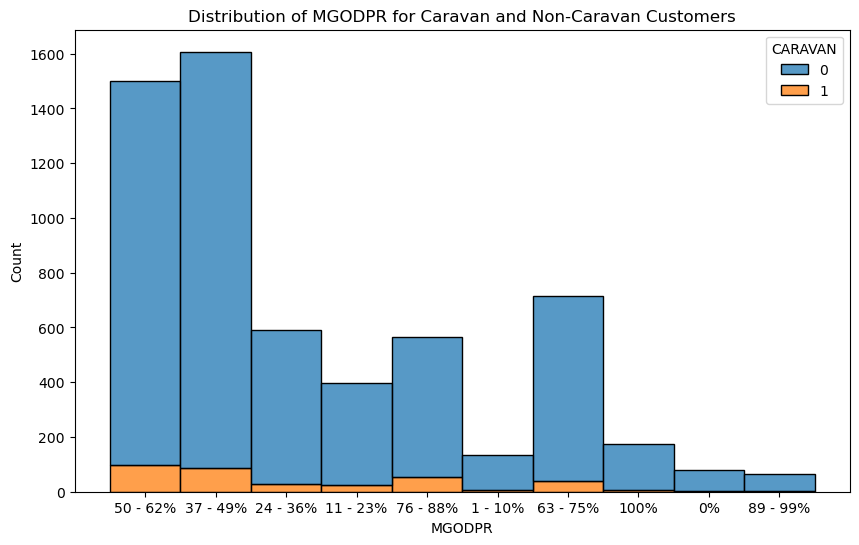

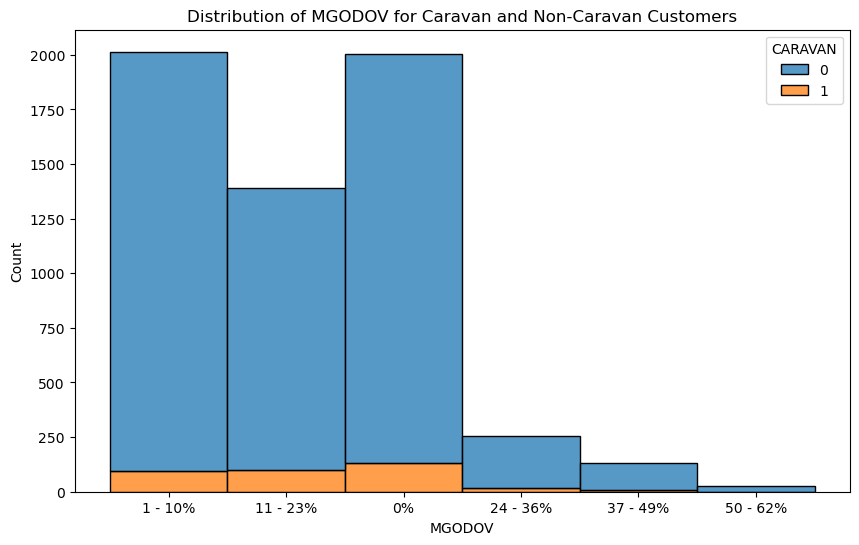

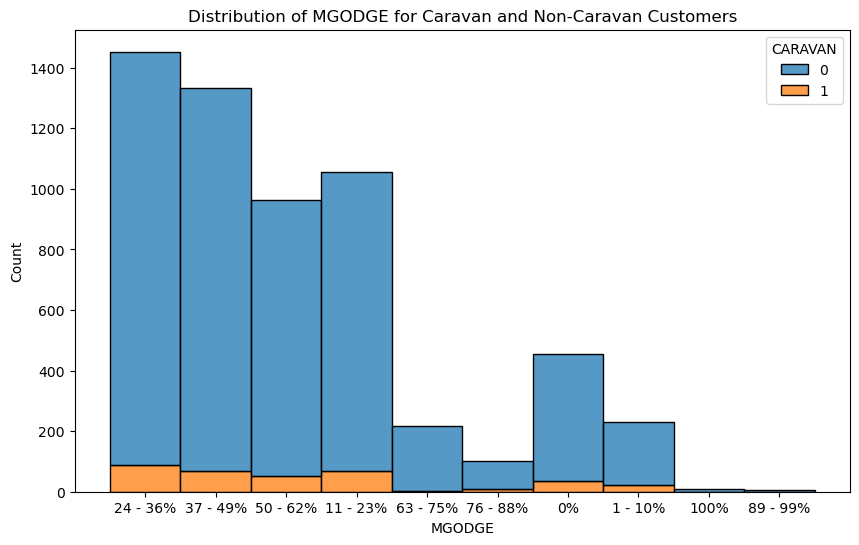

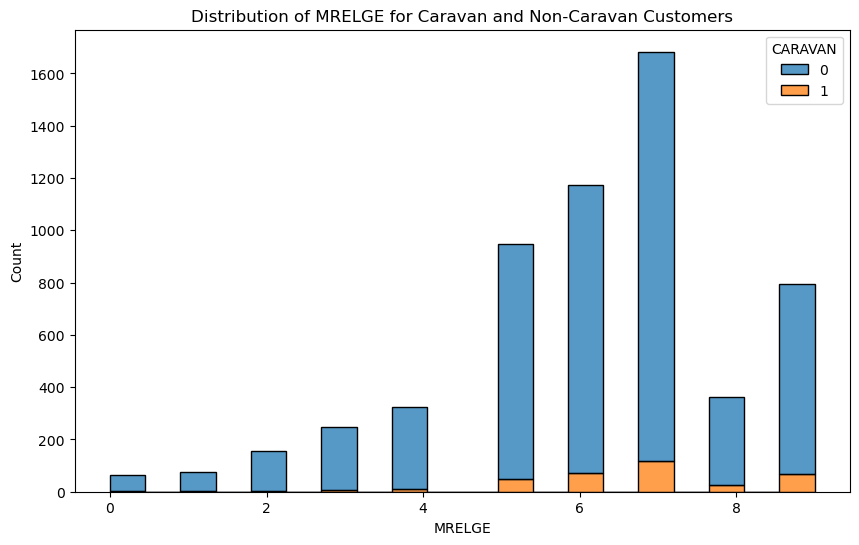

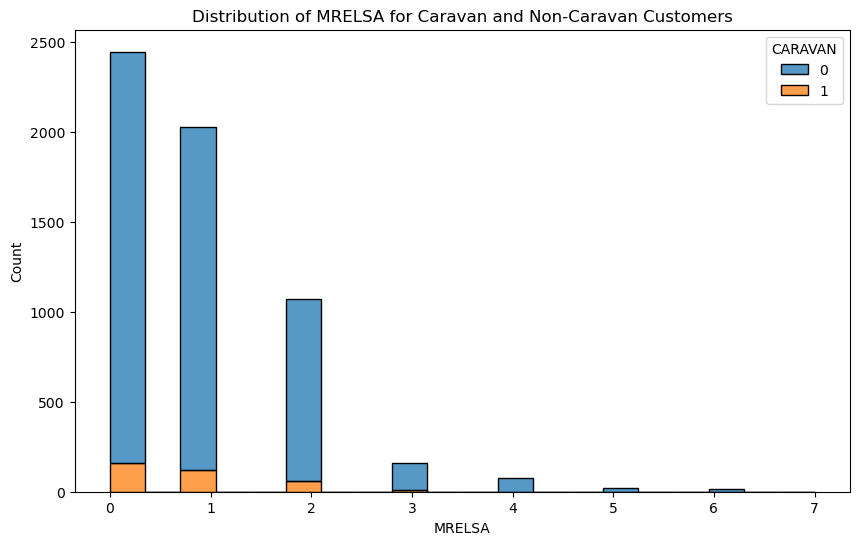

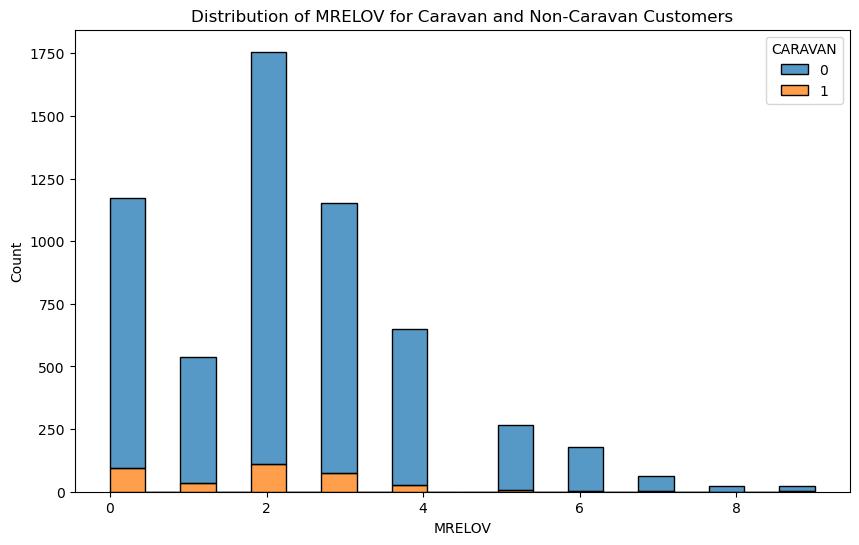

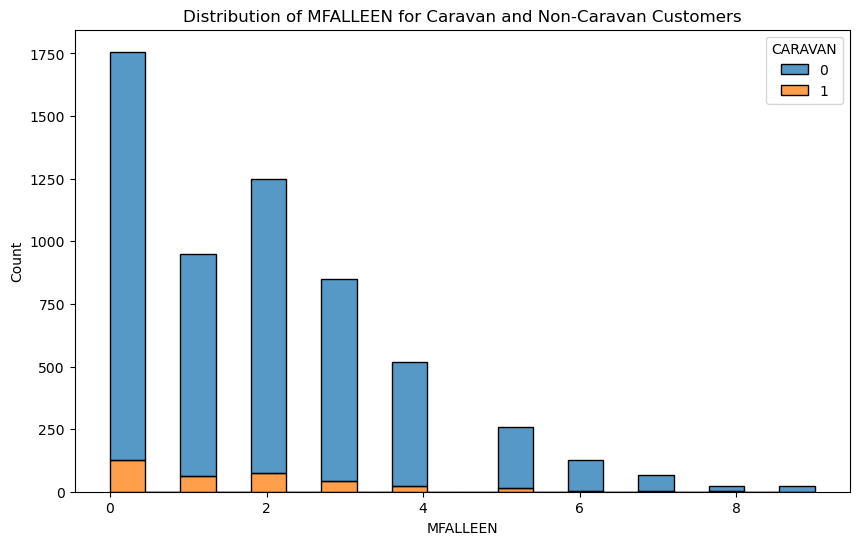

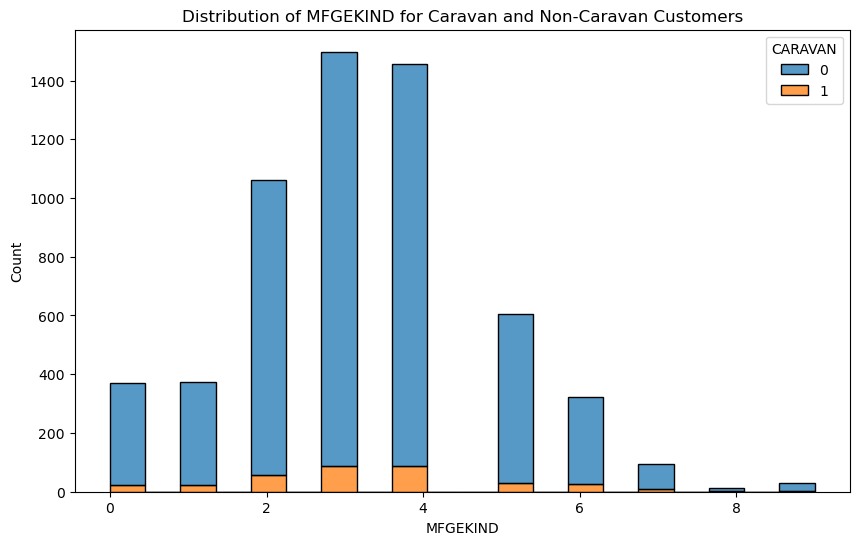

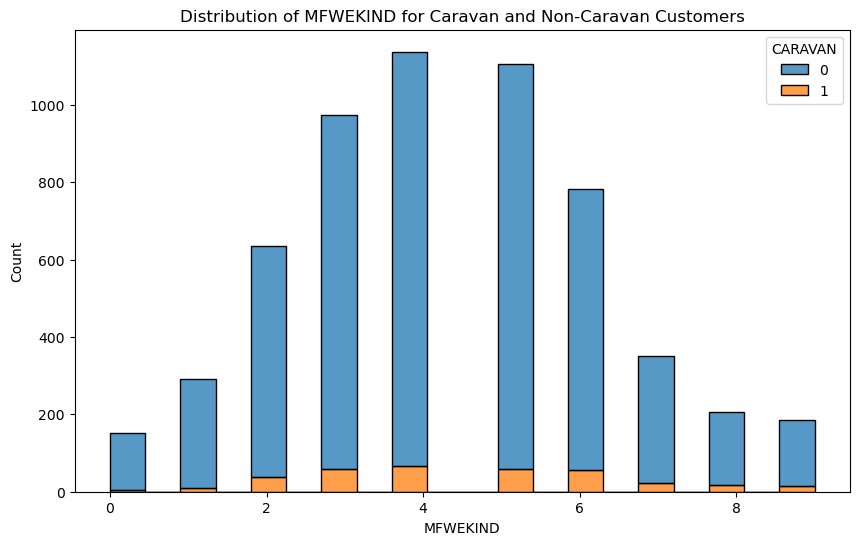

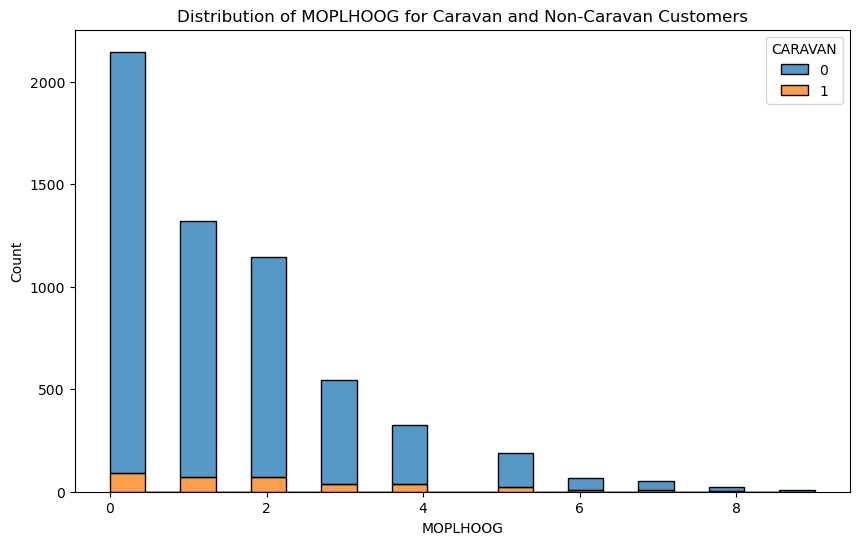

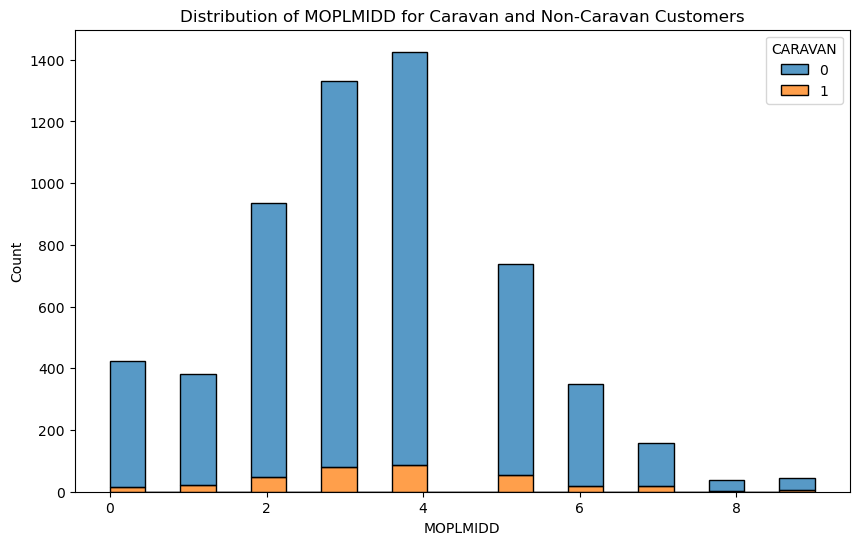

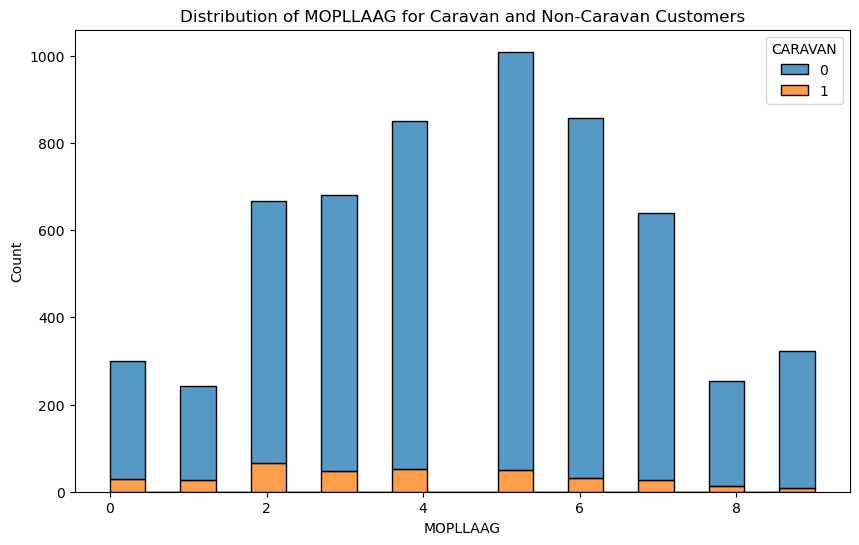

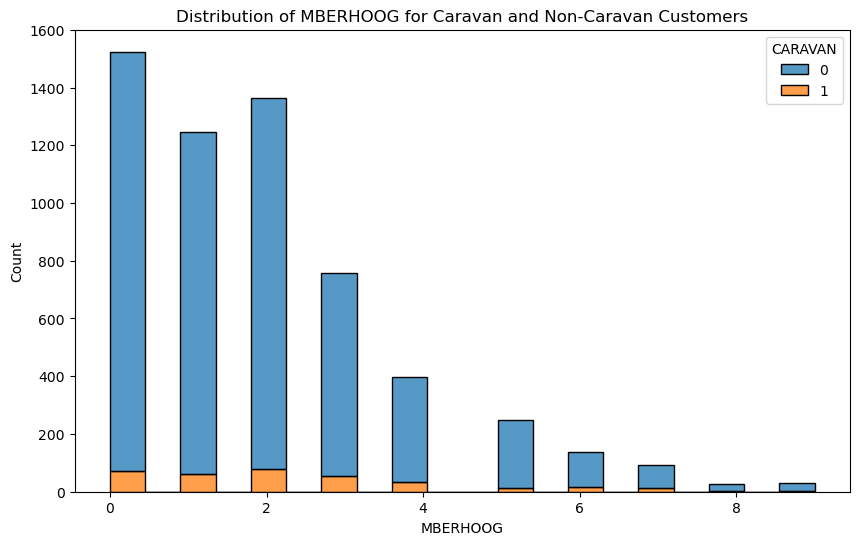

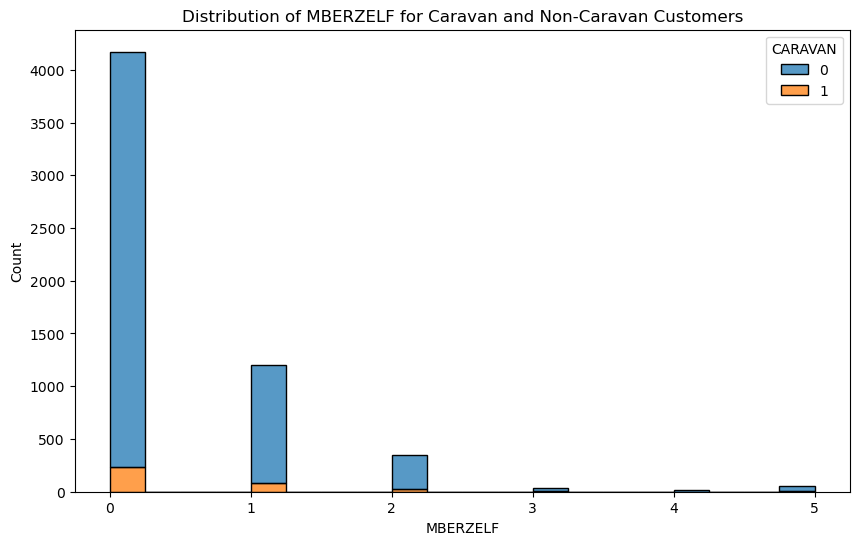

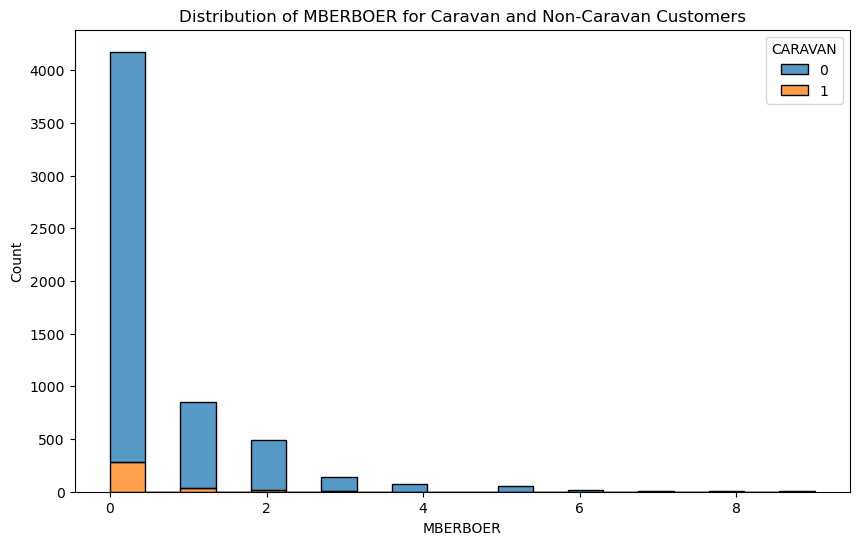

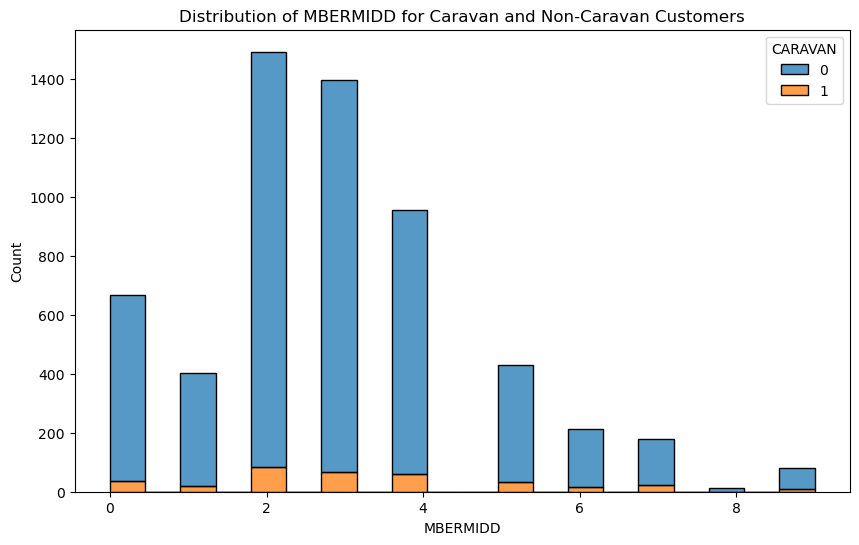

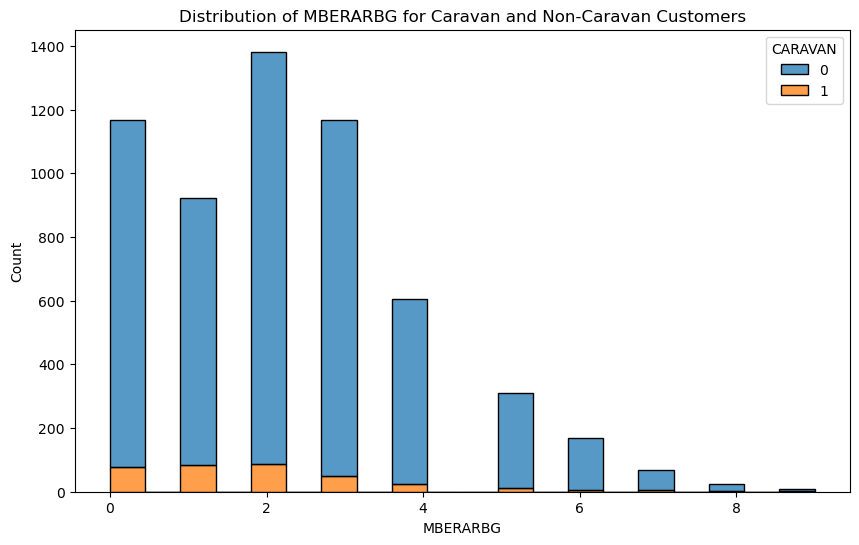

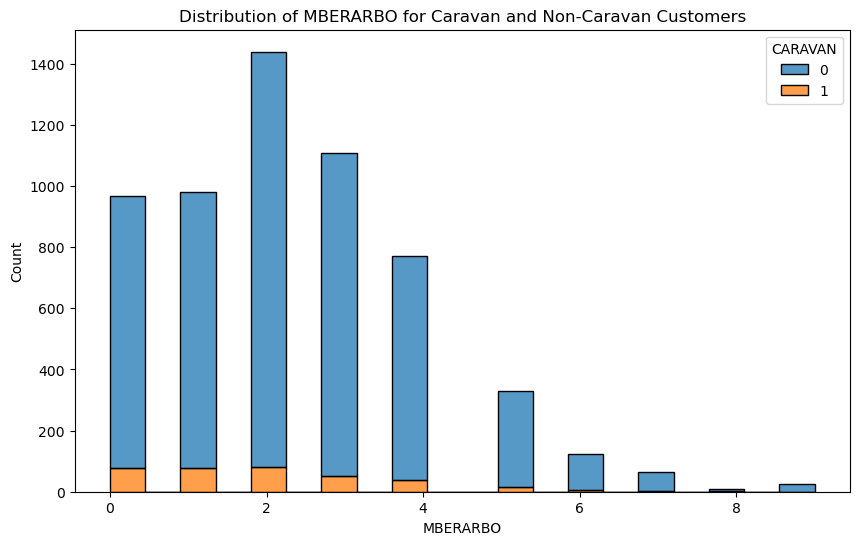

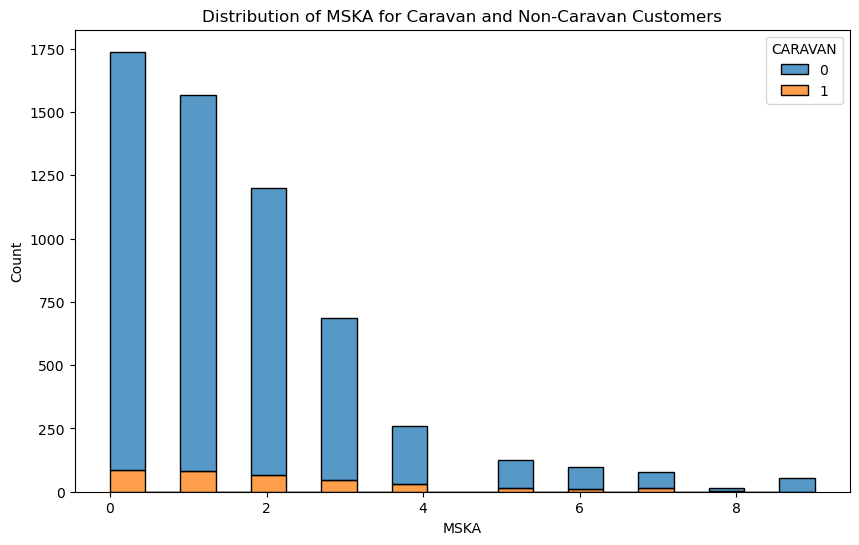

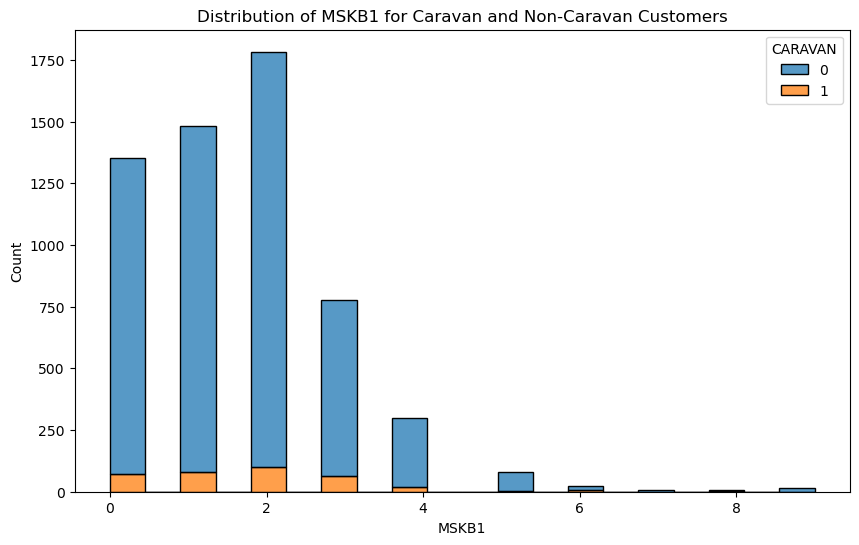

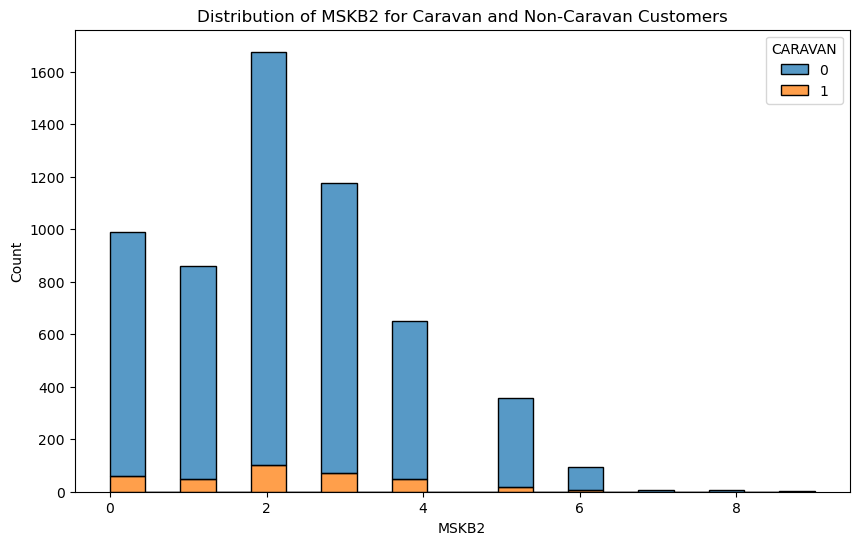

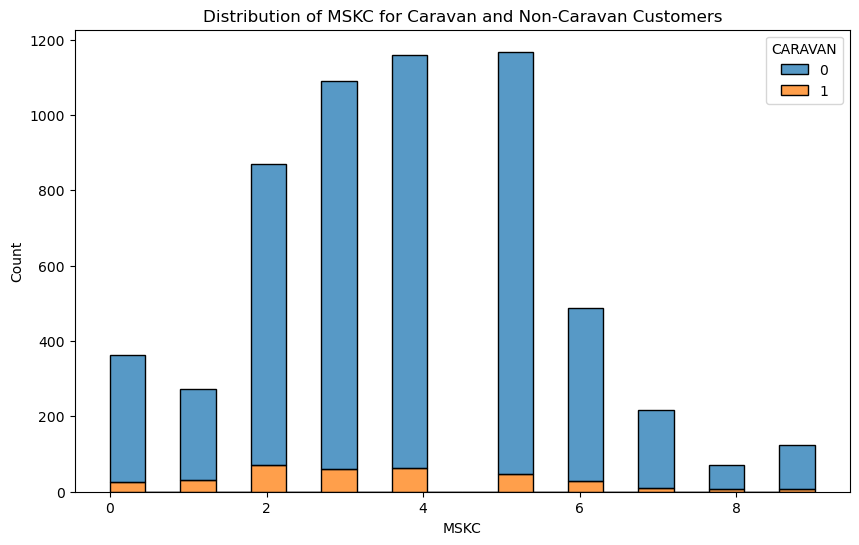

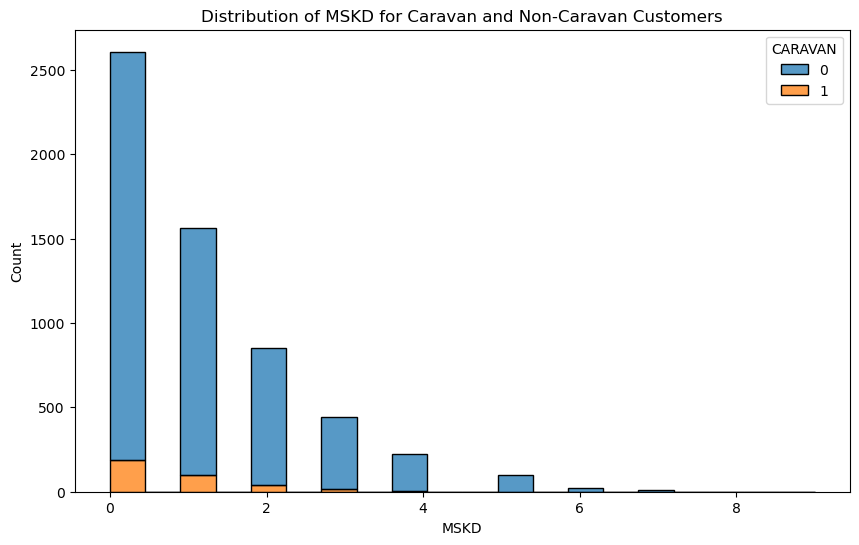

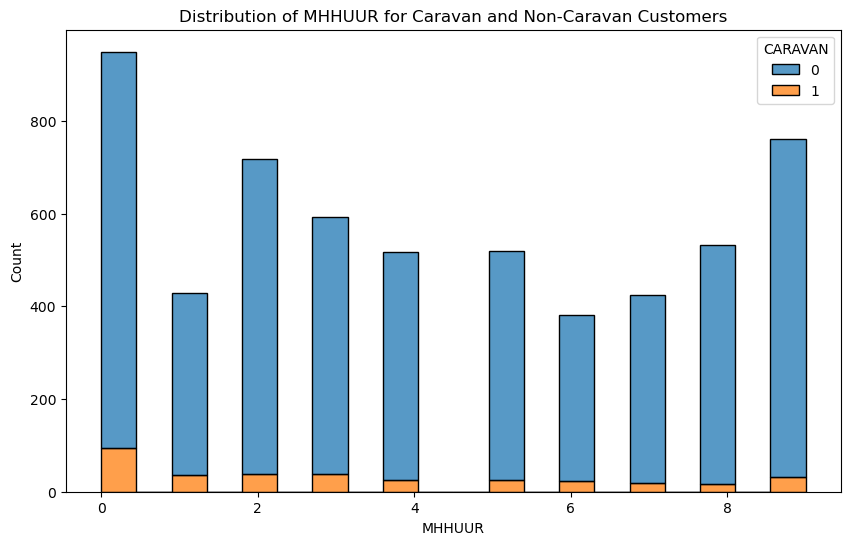

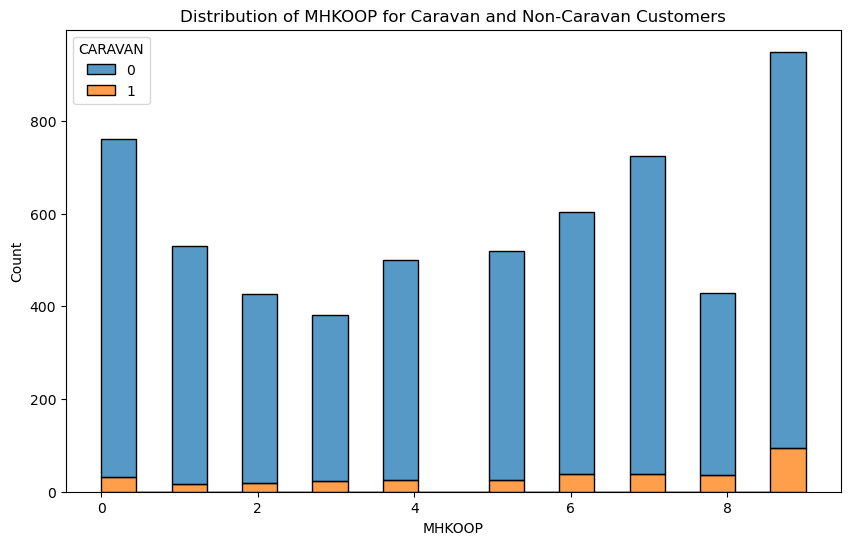

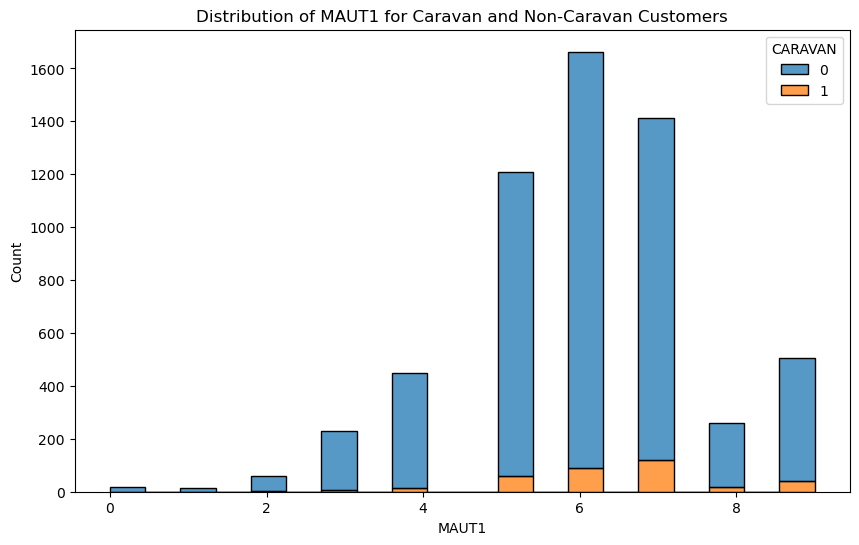

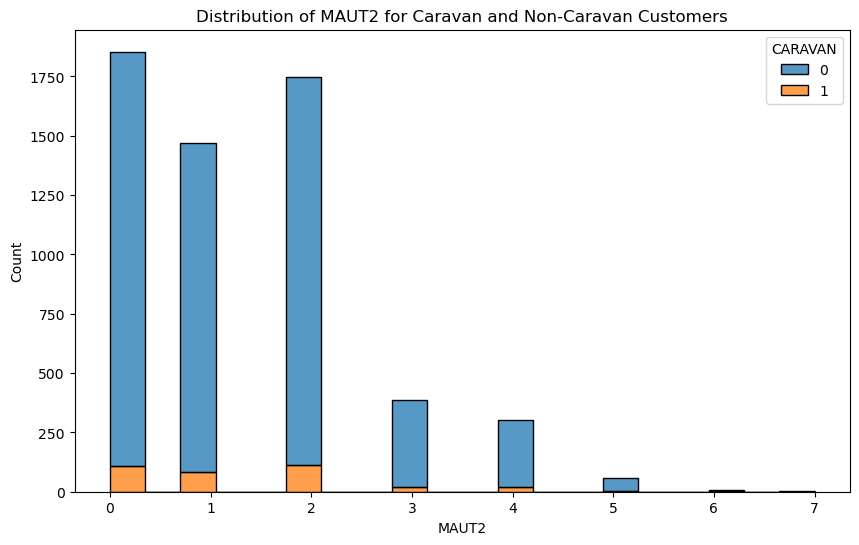

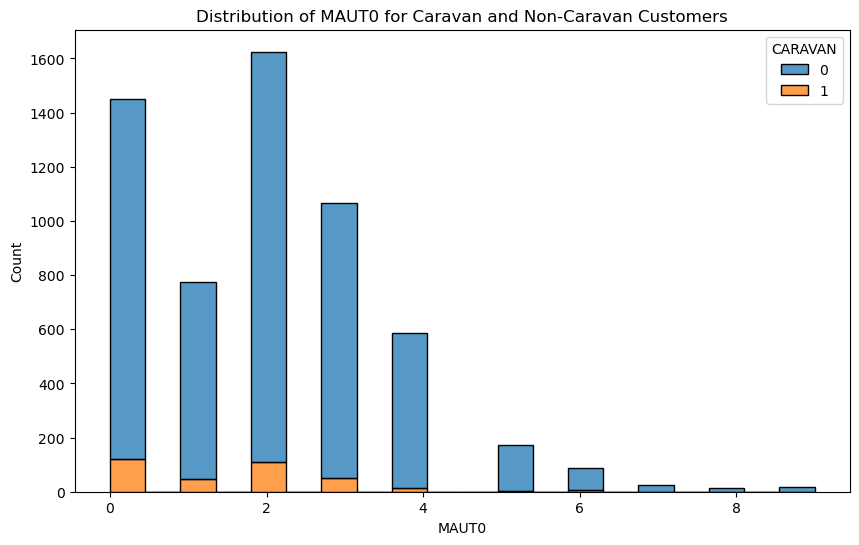

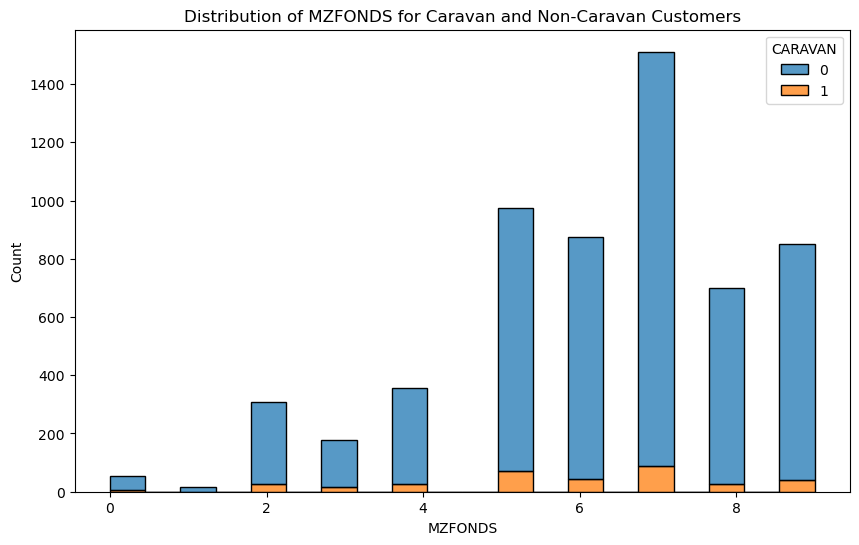

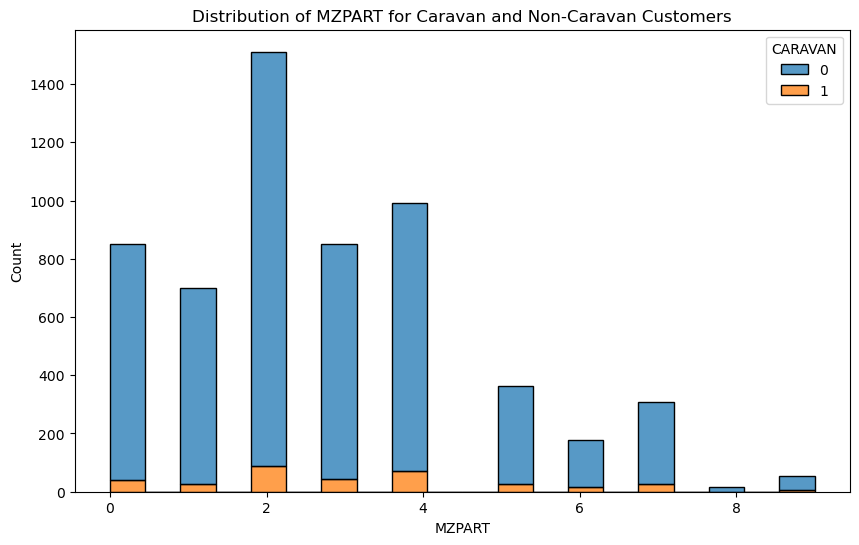

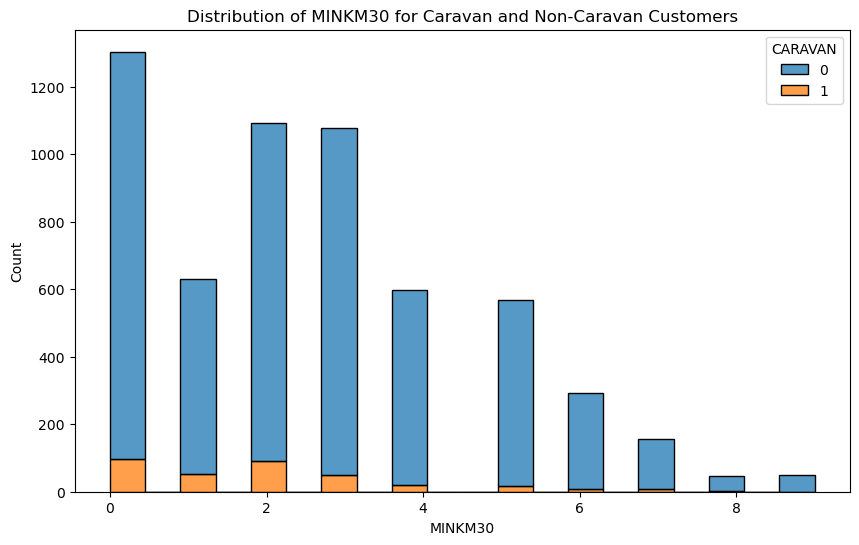

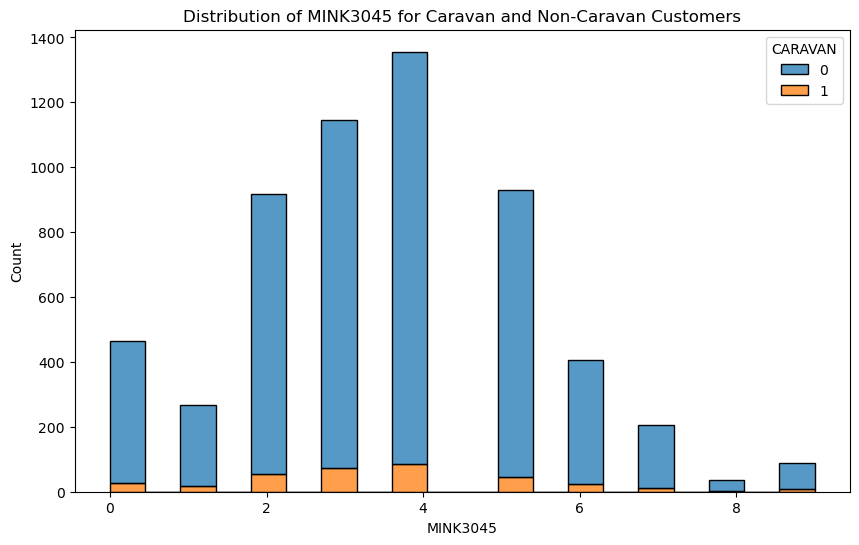

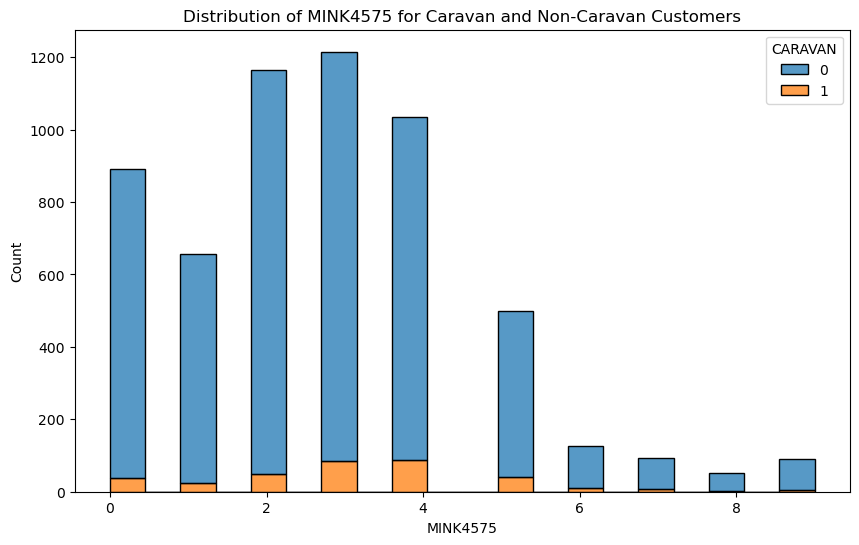

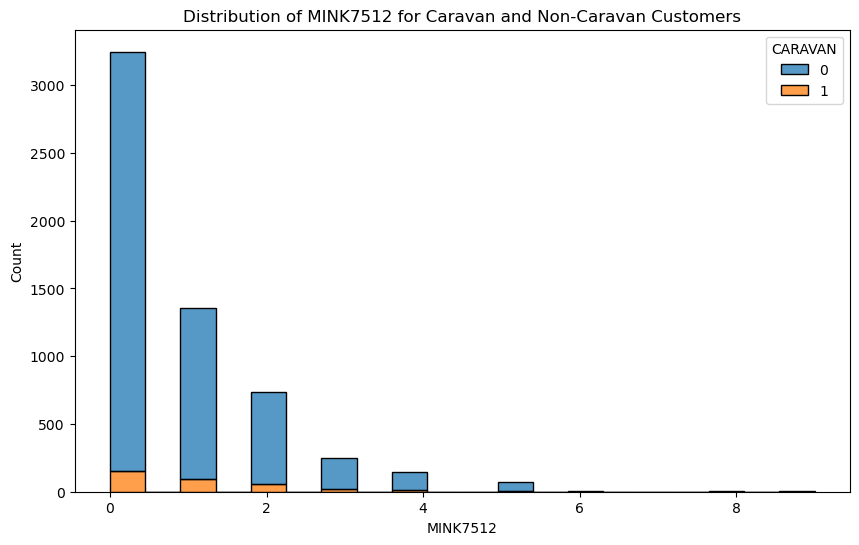

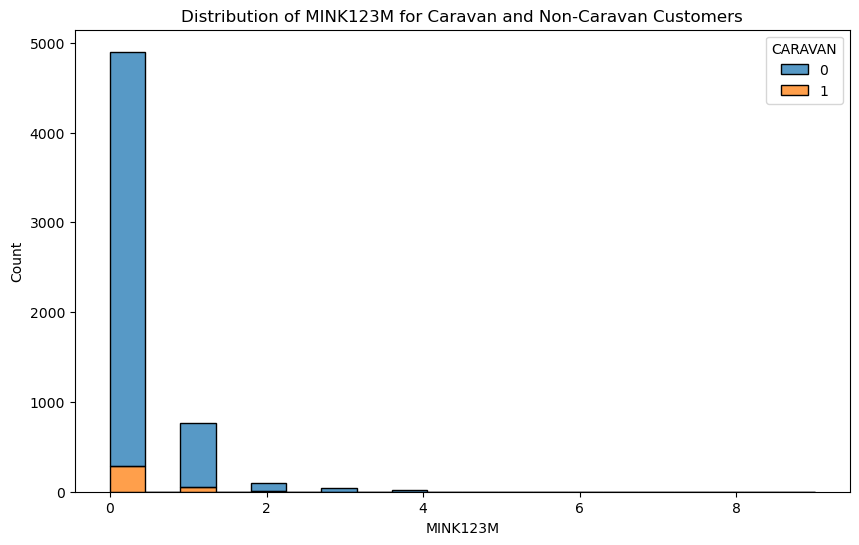

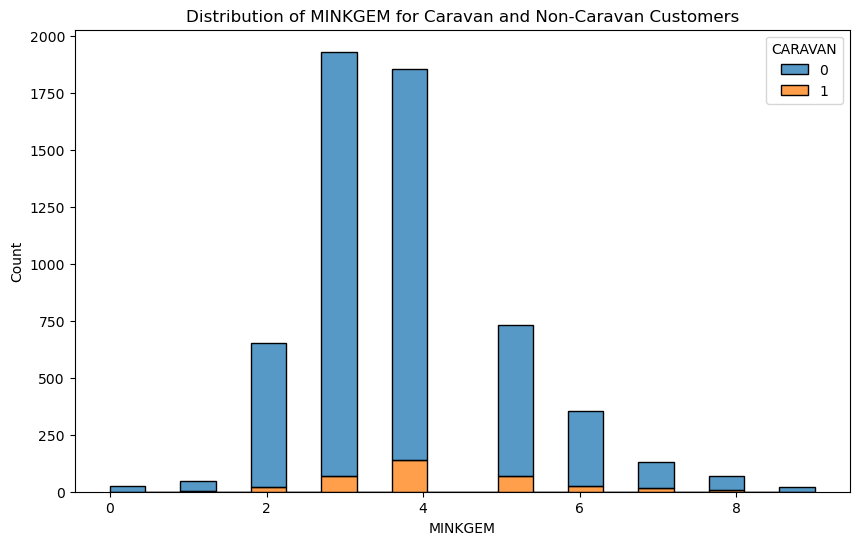

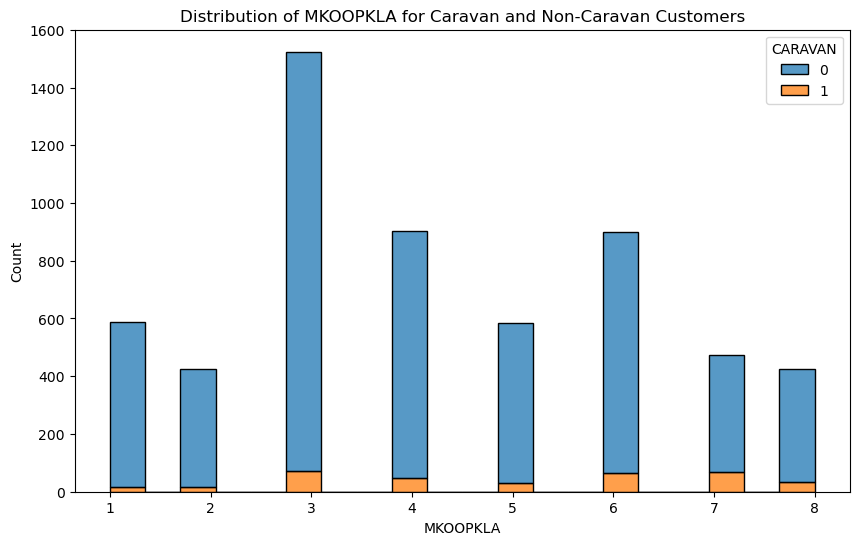

/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


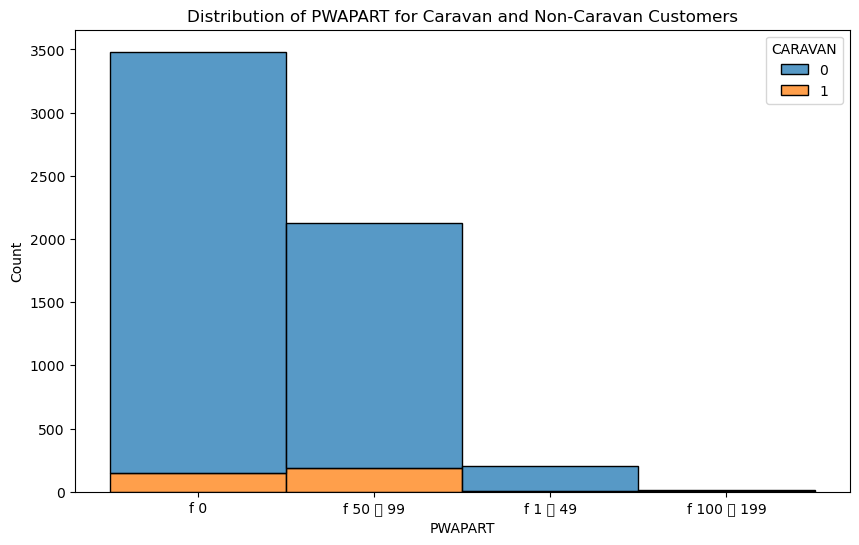

/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


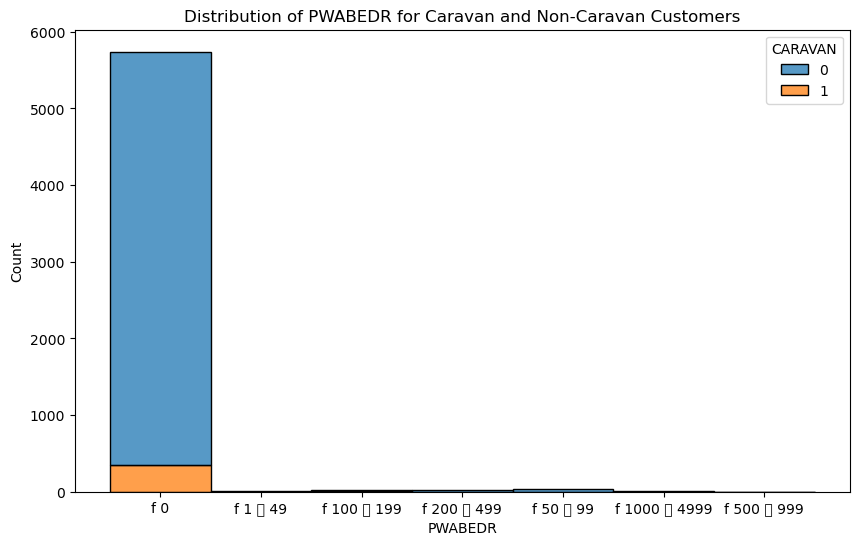

/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


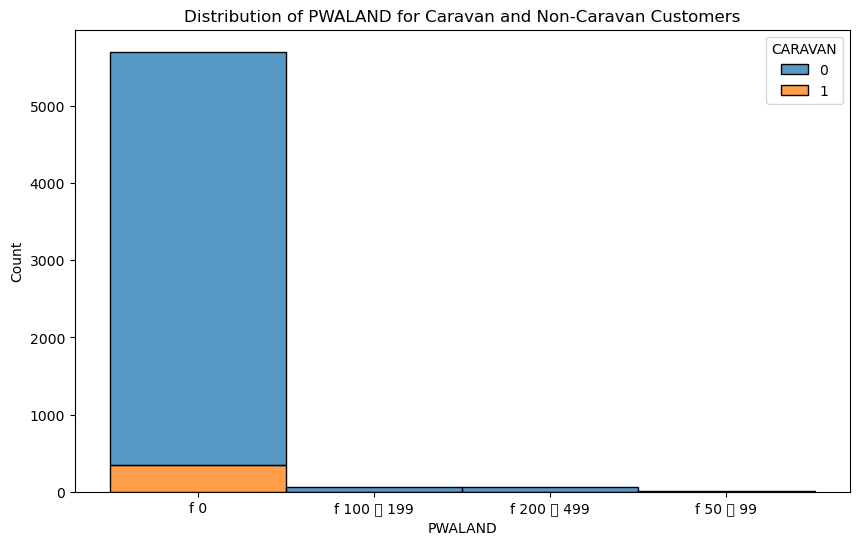

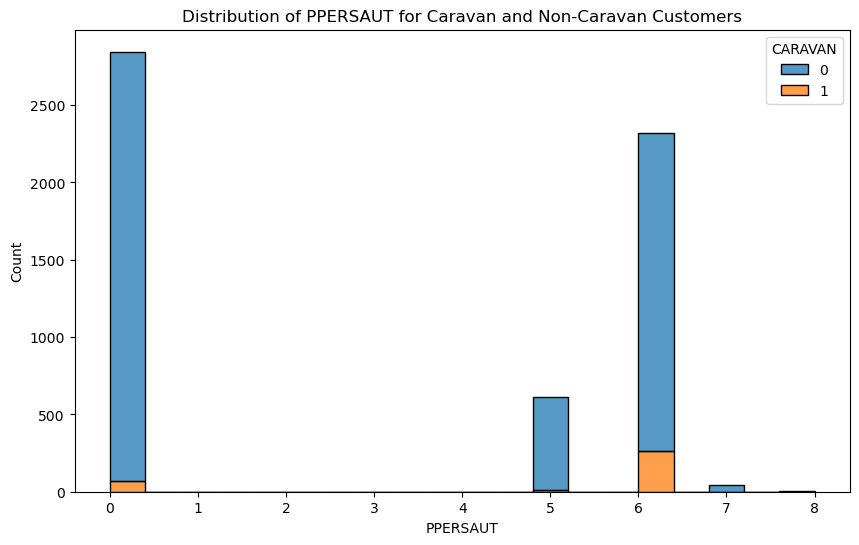

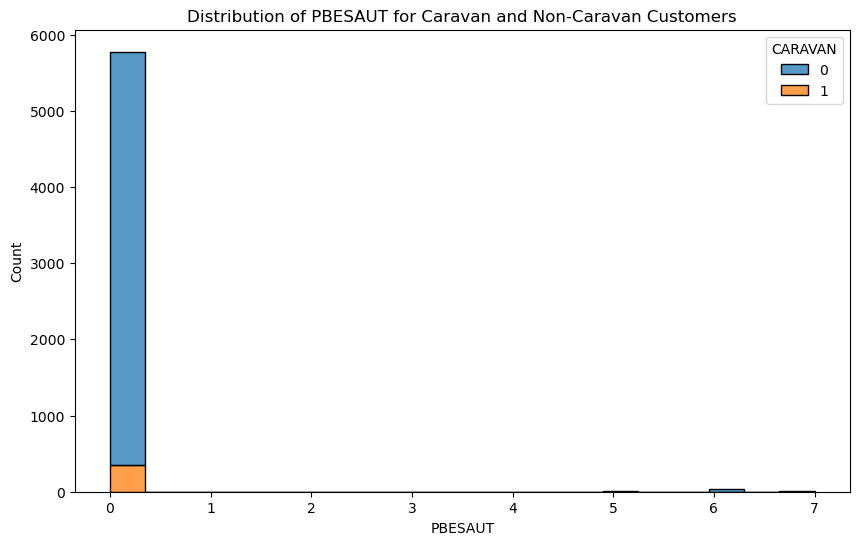

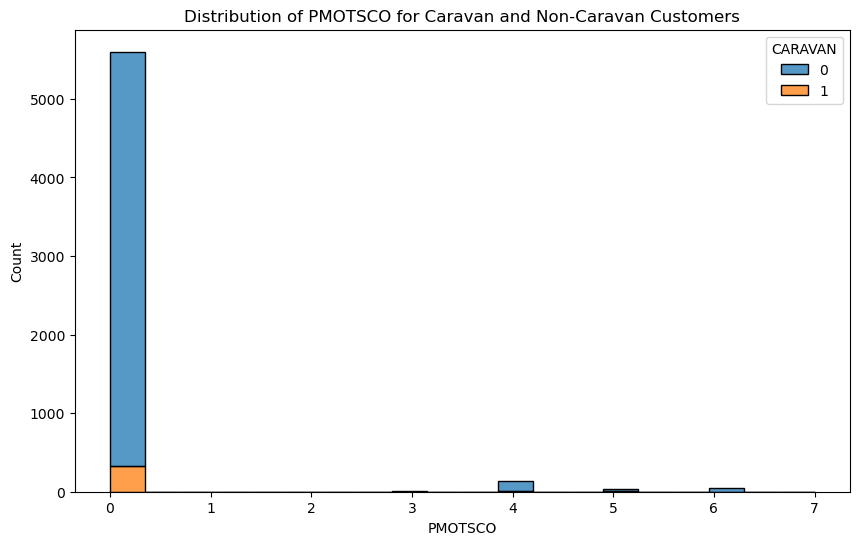

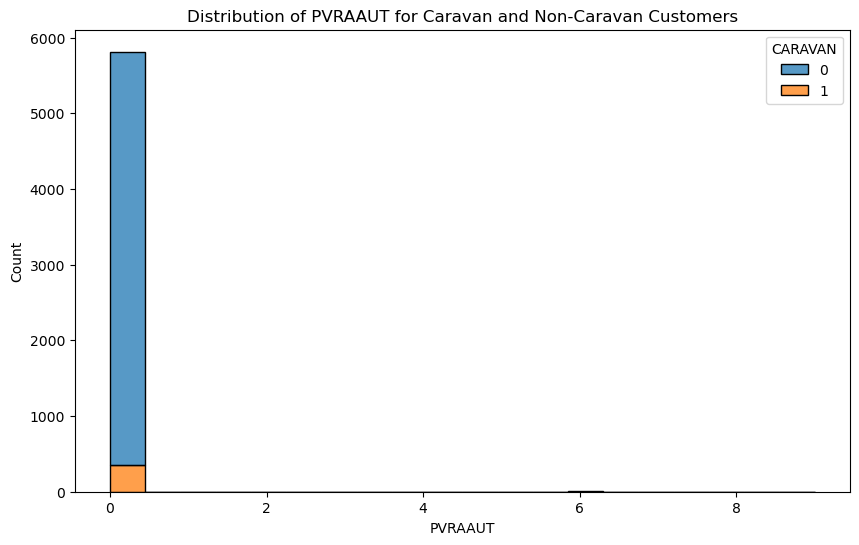

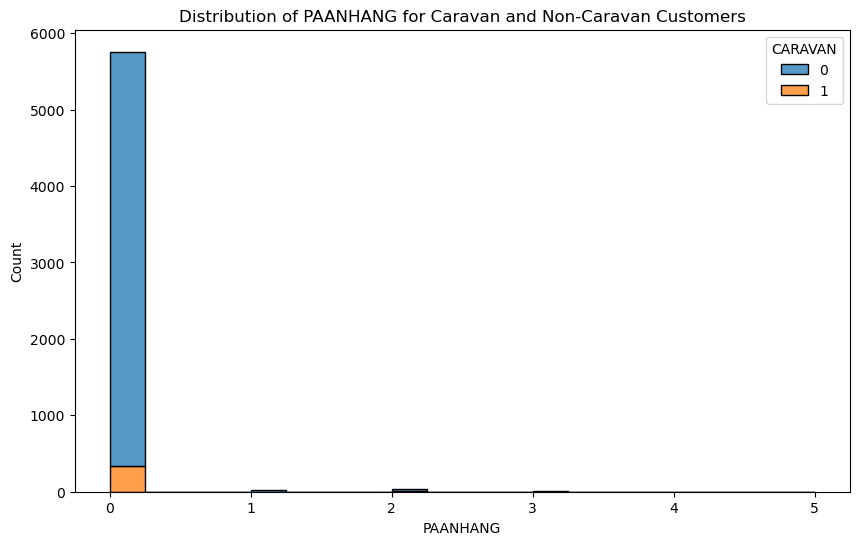

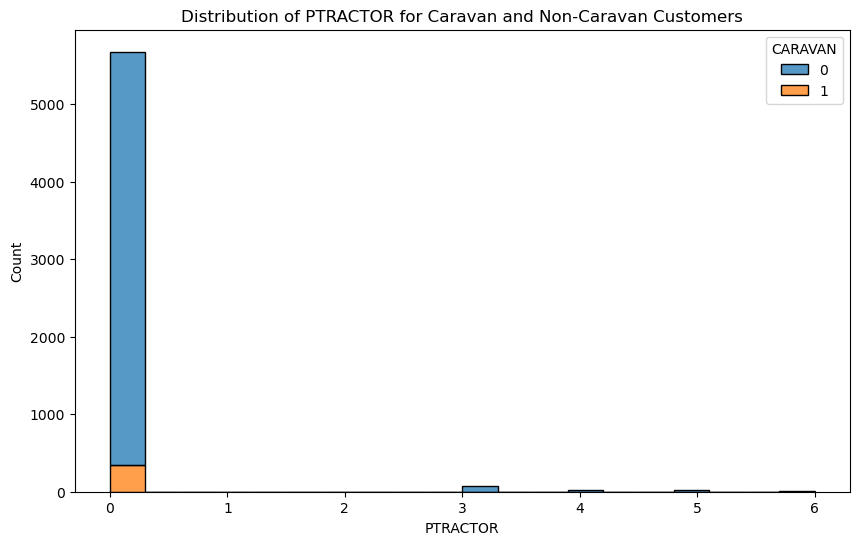

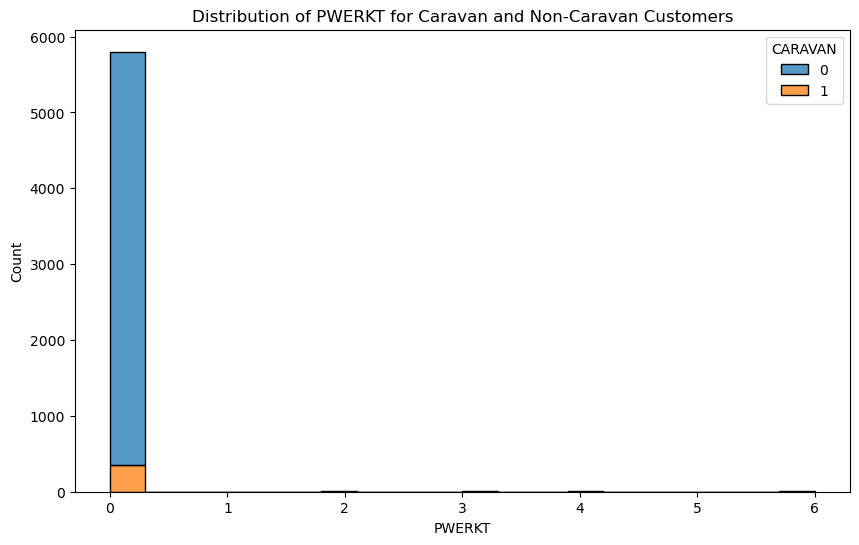

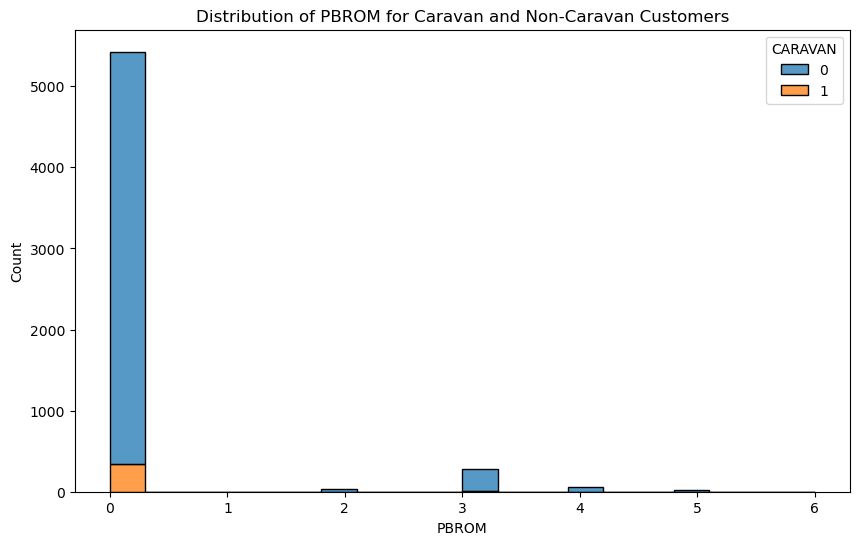

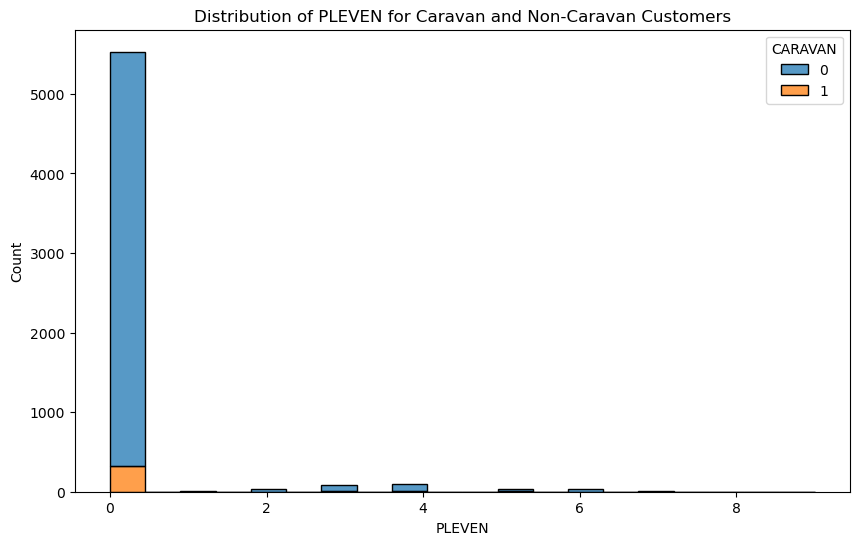

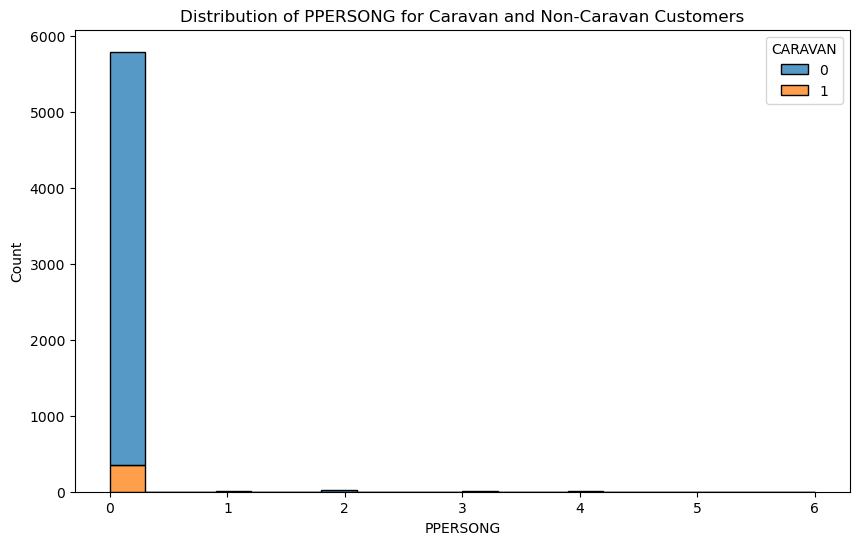

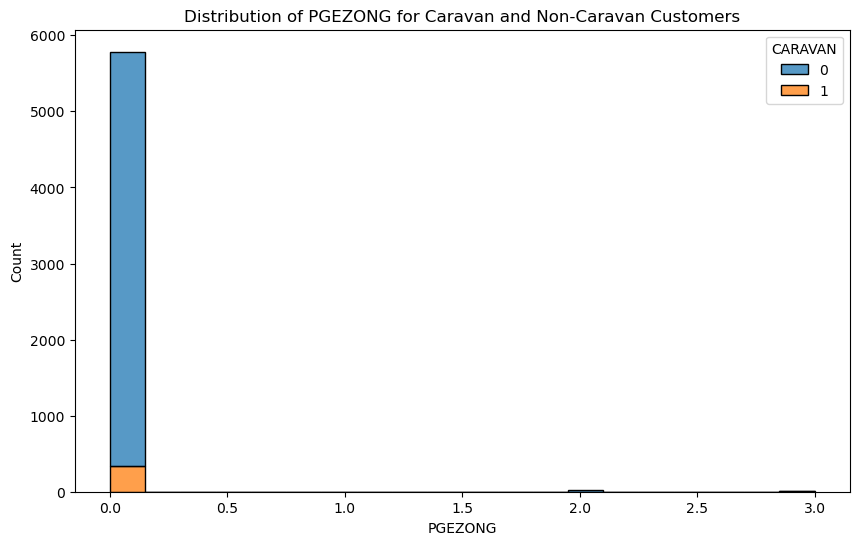

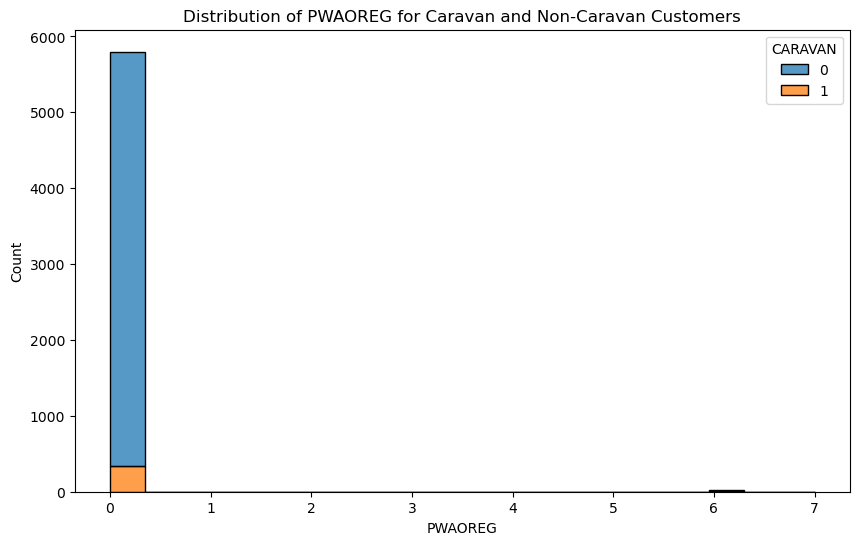

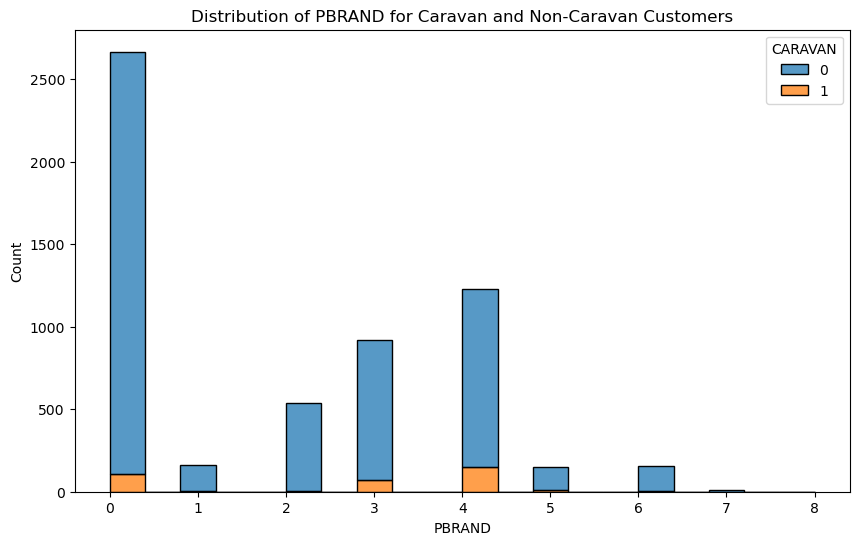

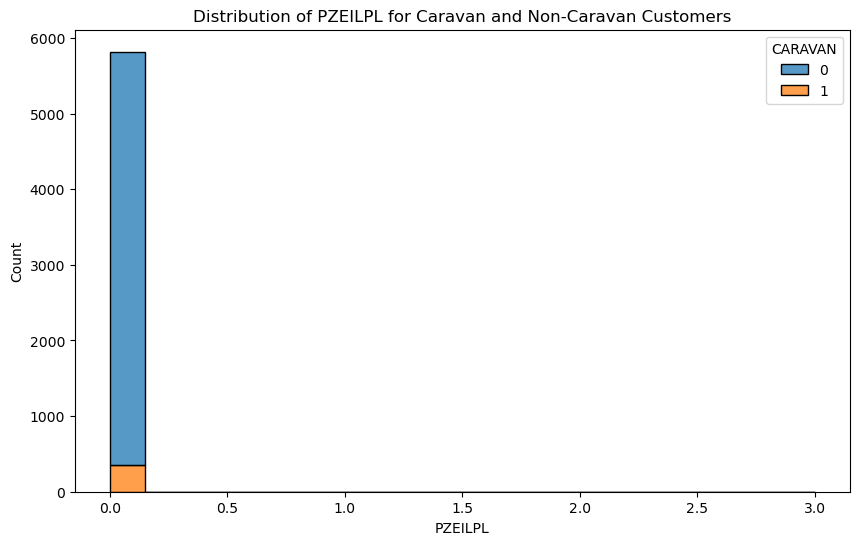

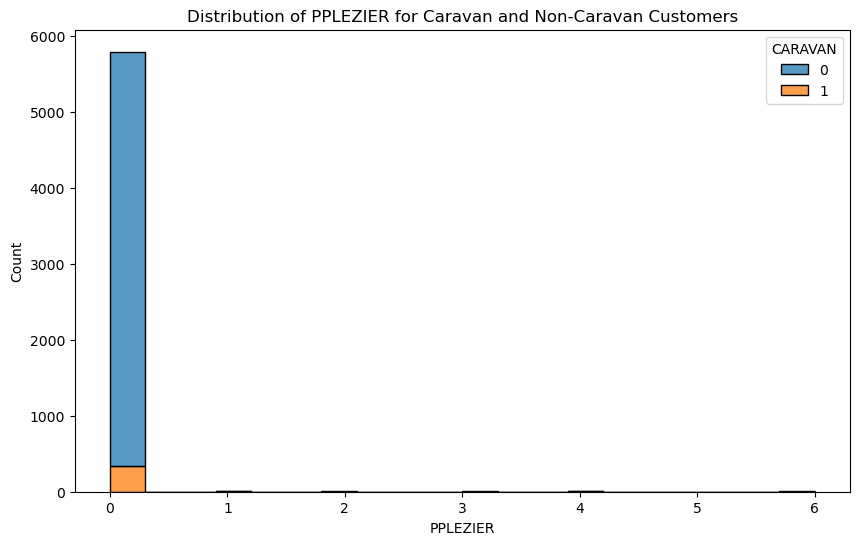

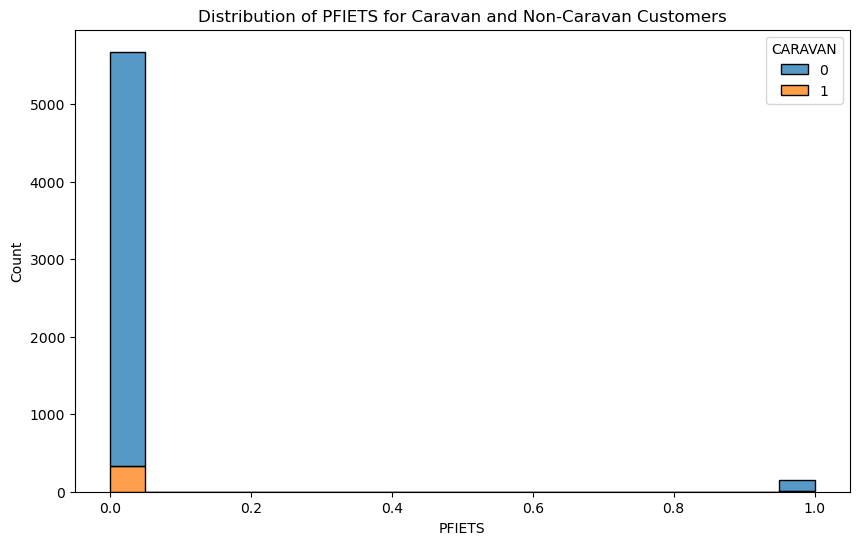

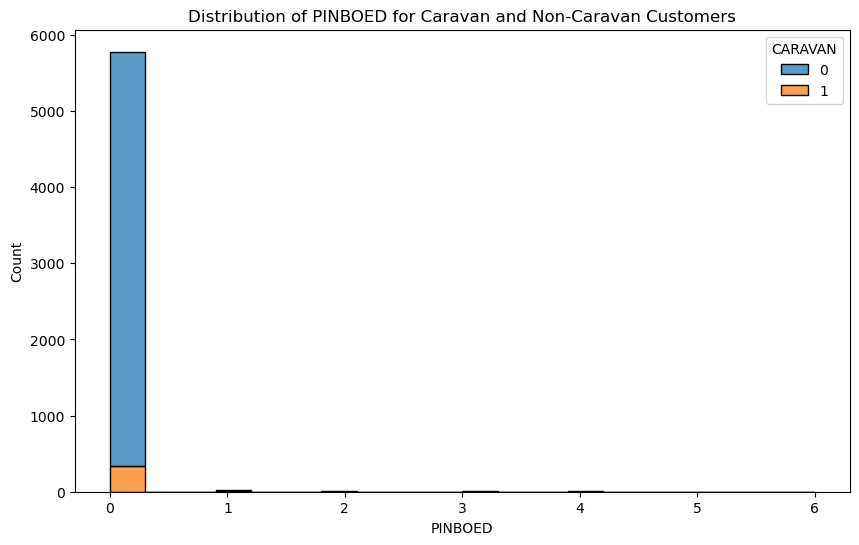

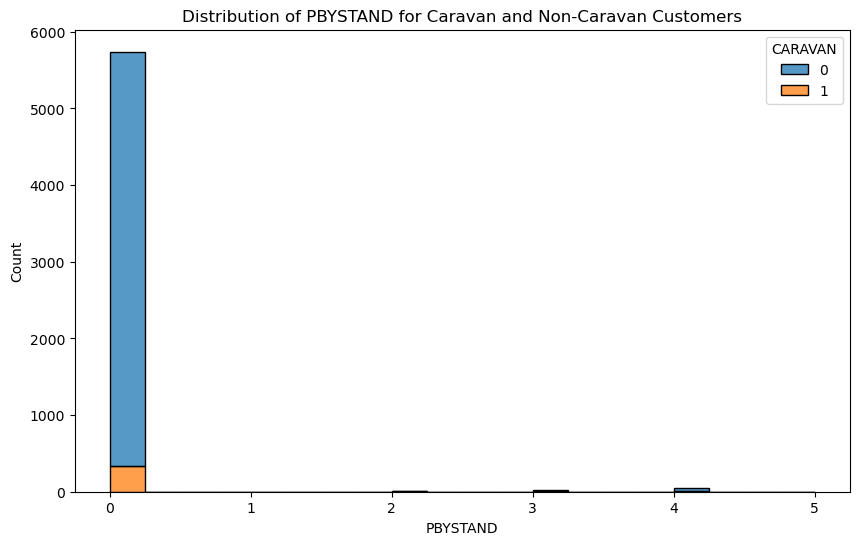

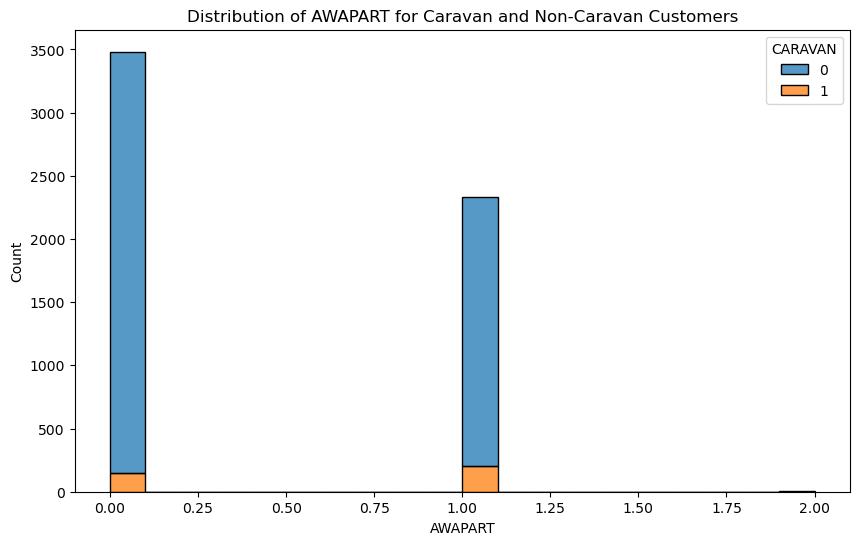

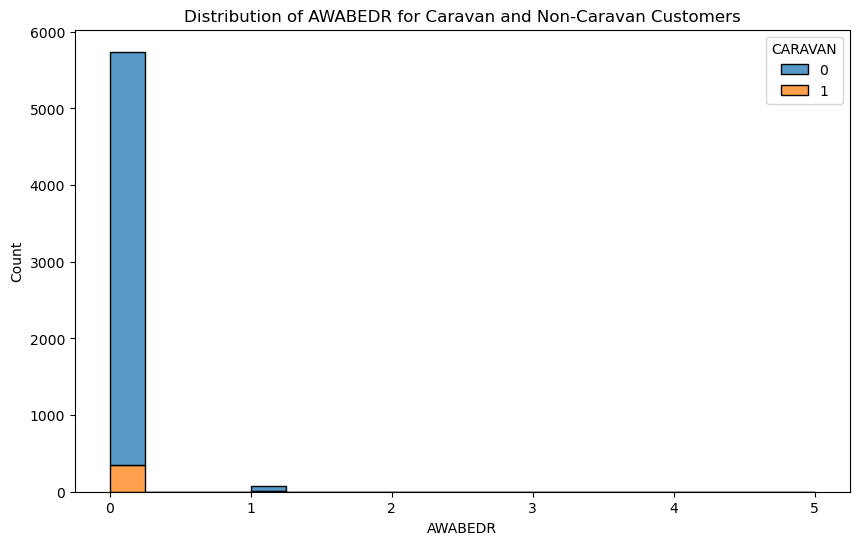

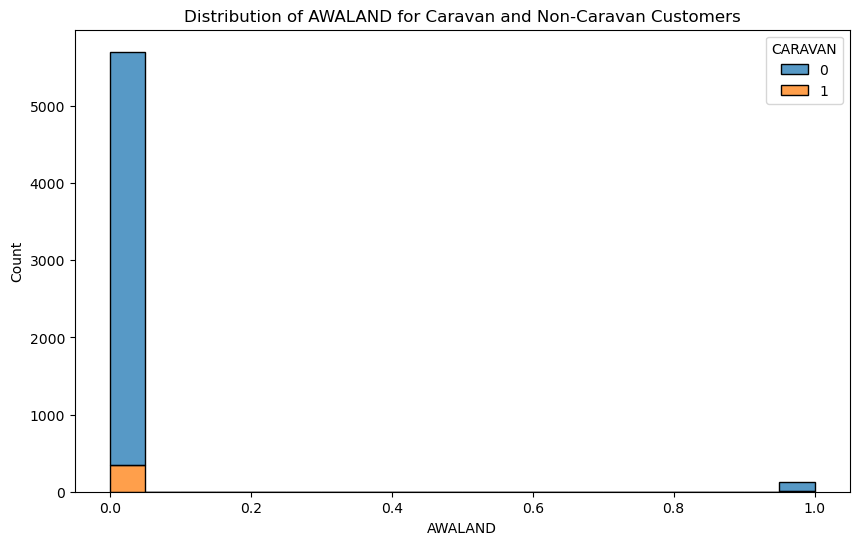

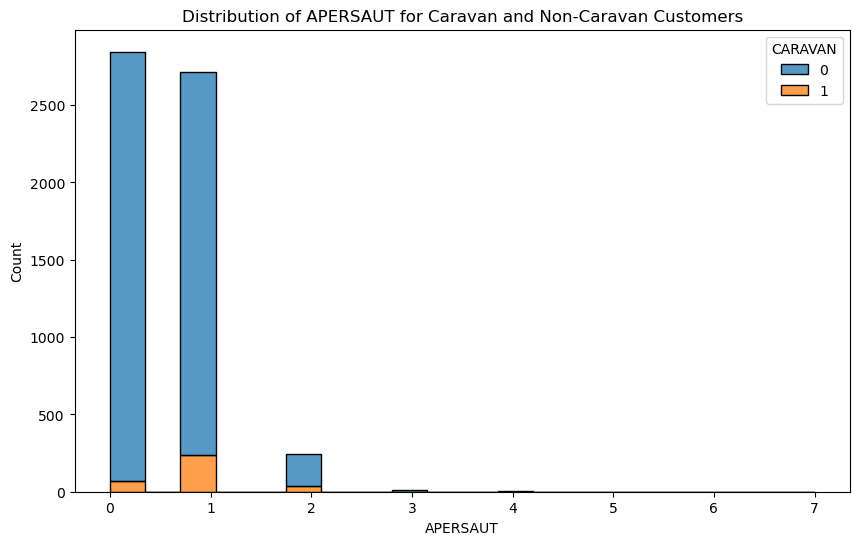

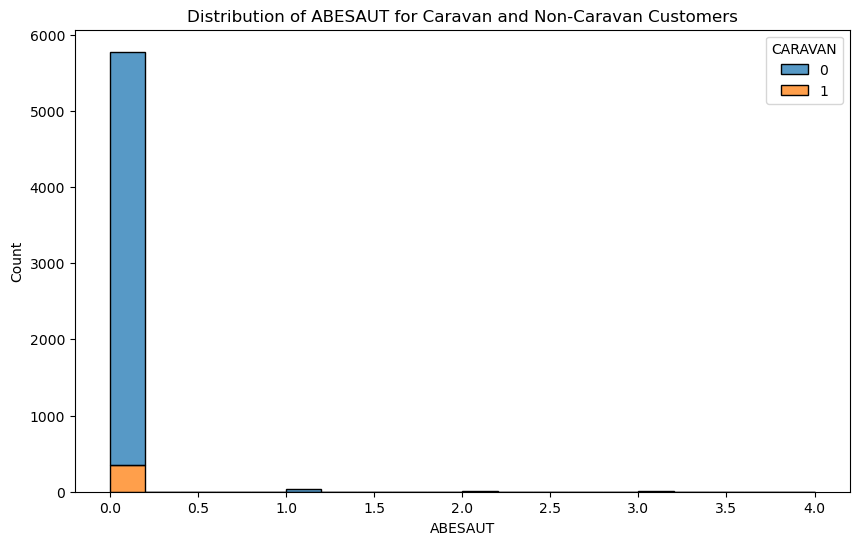

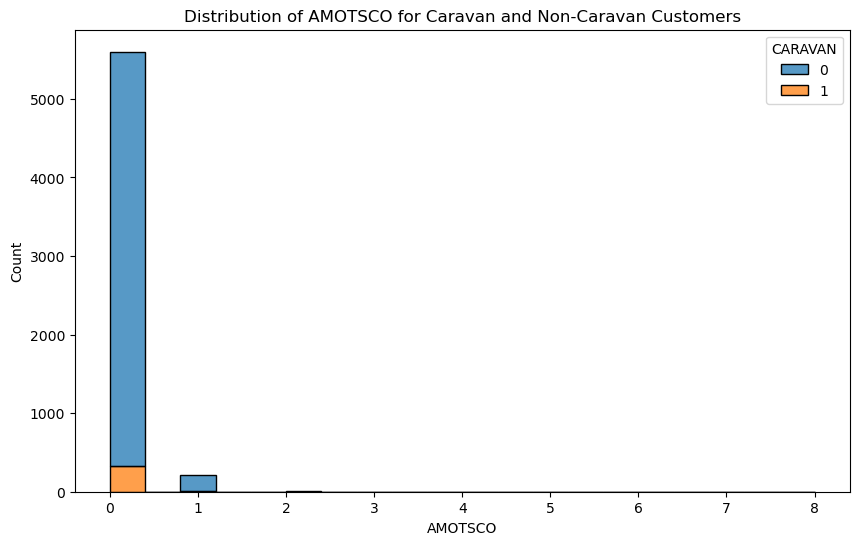

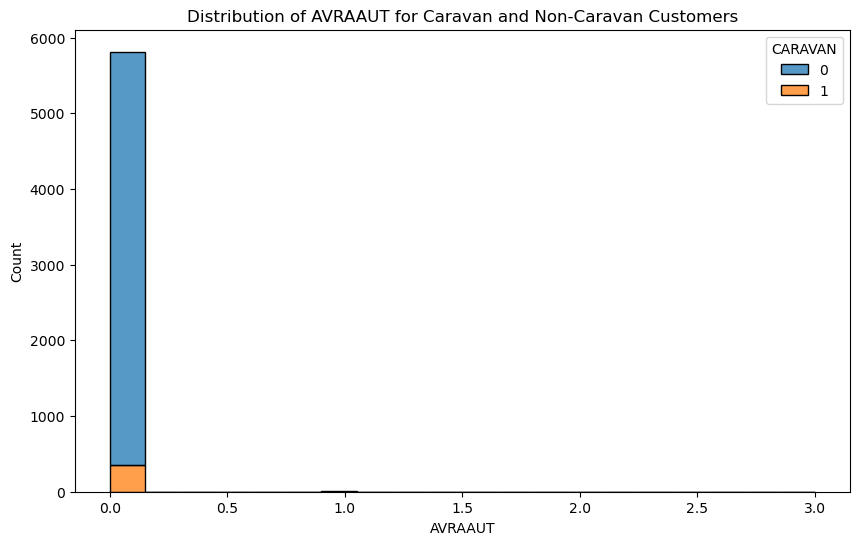

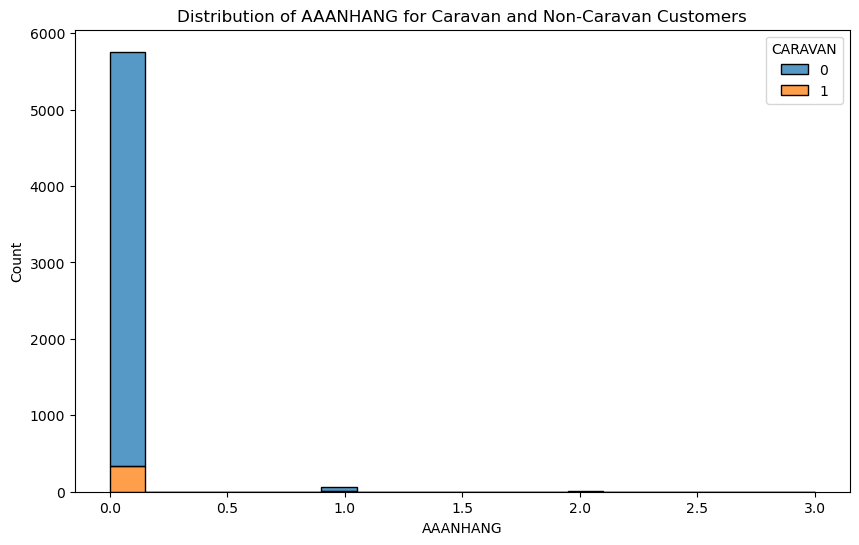

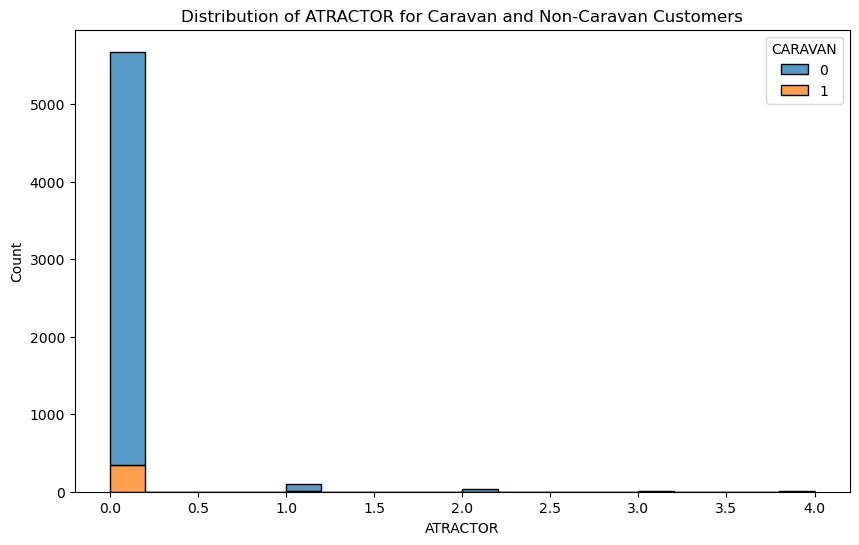

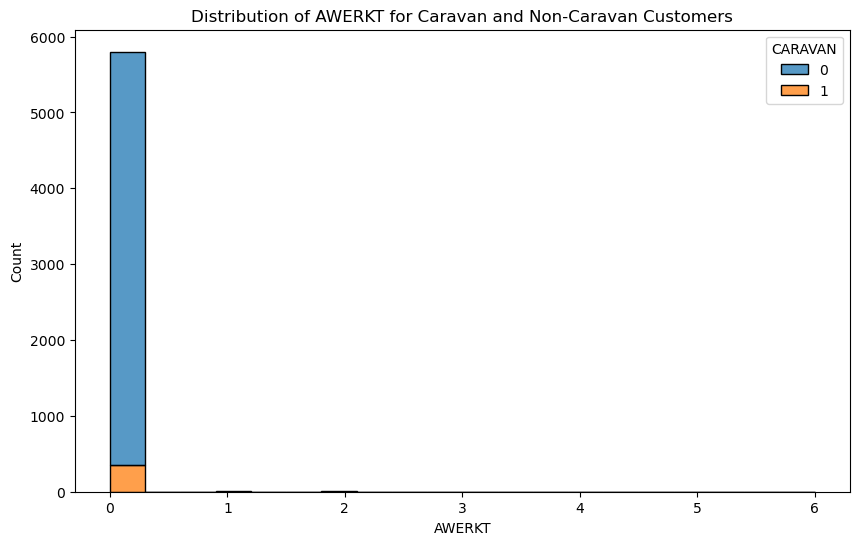

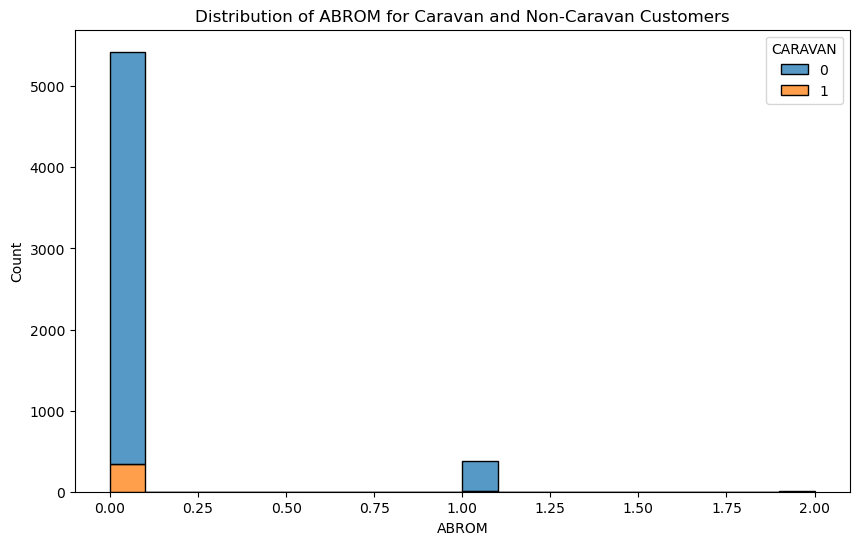

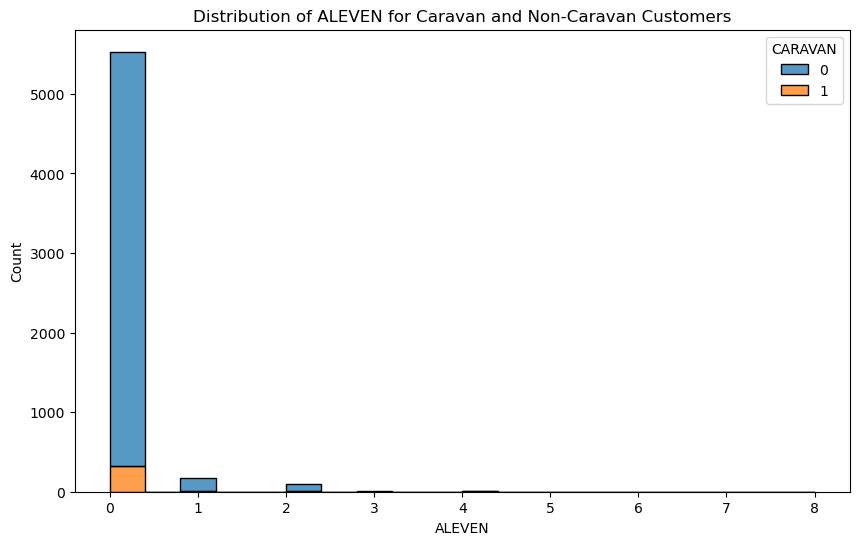

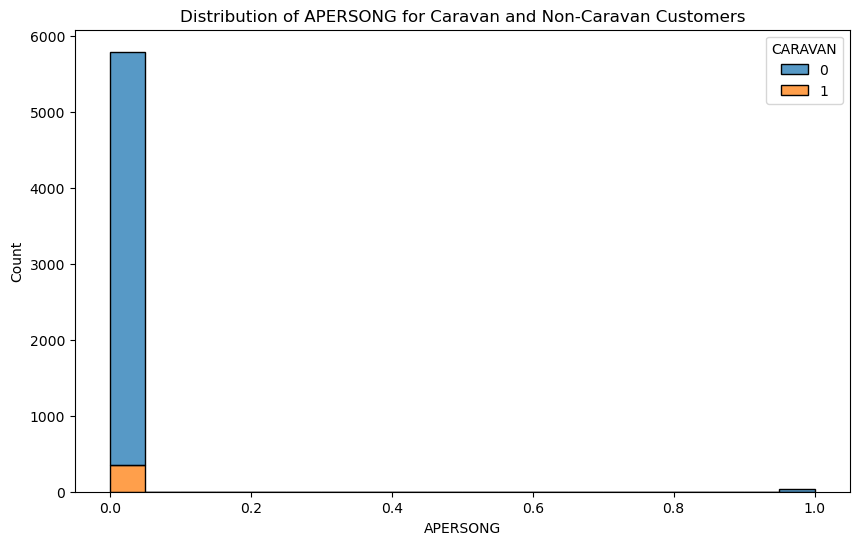

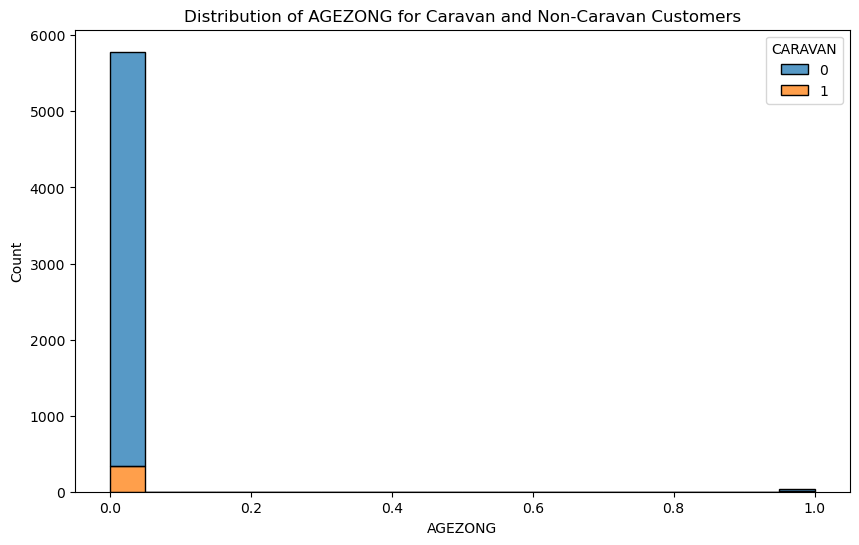

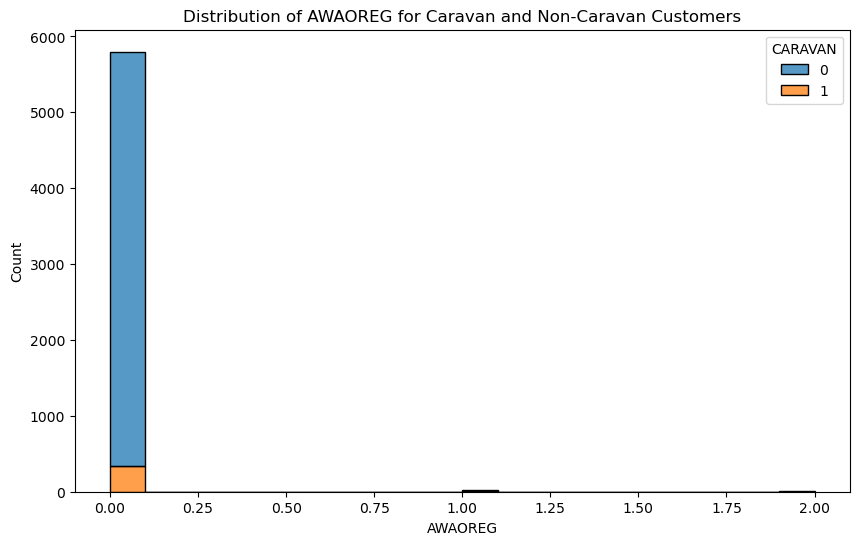

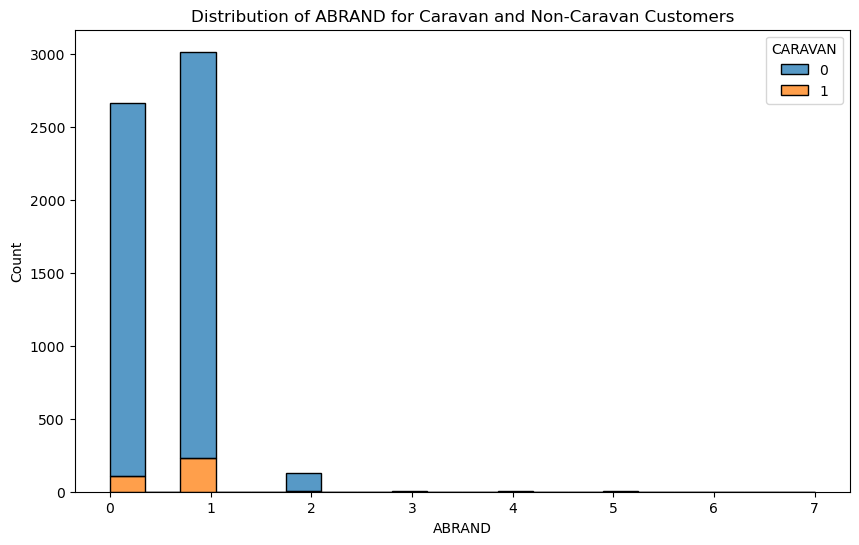

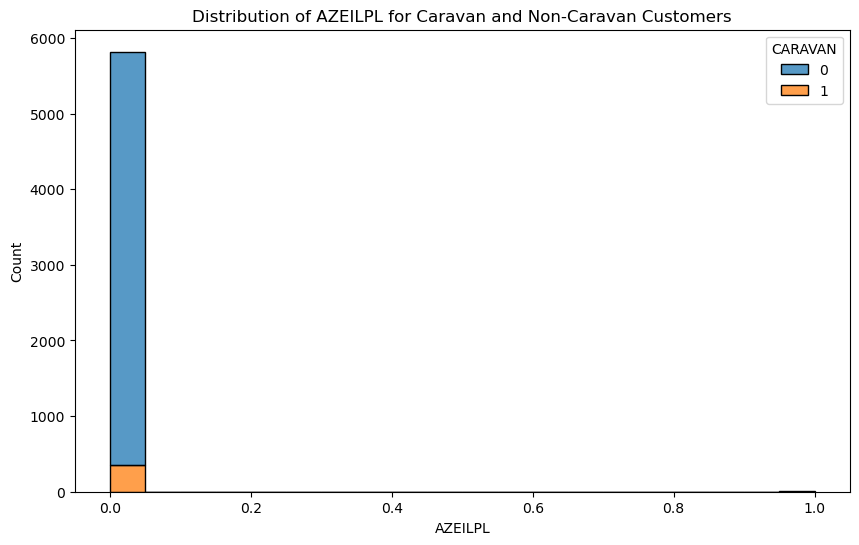

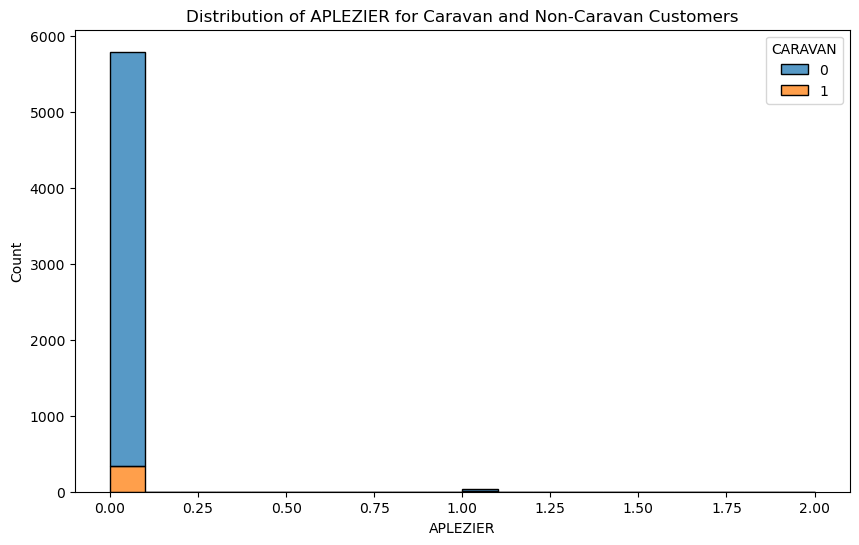

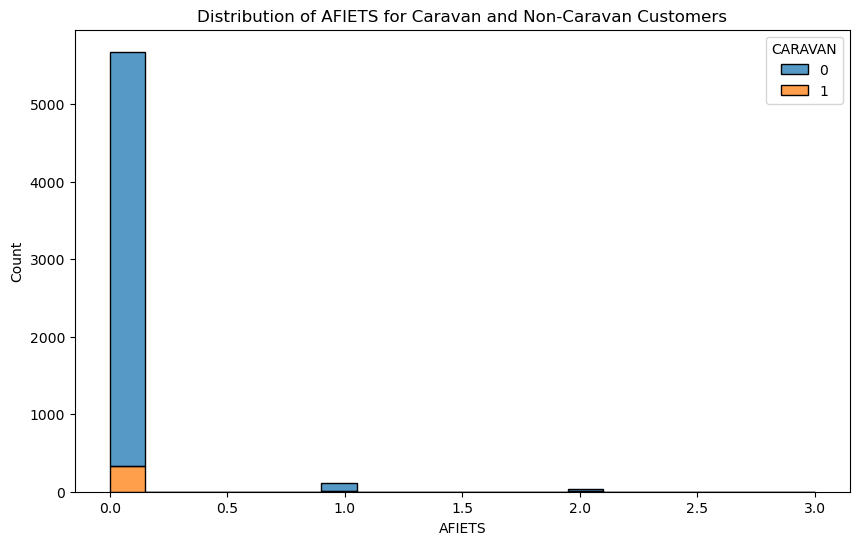

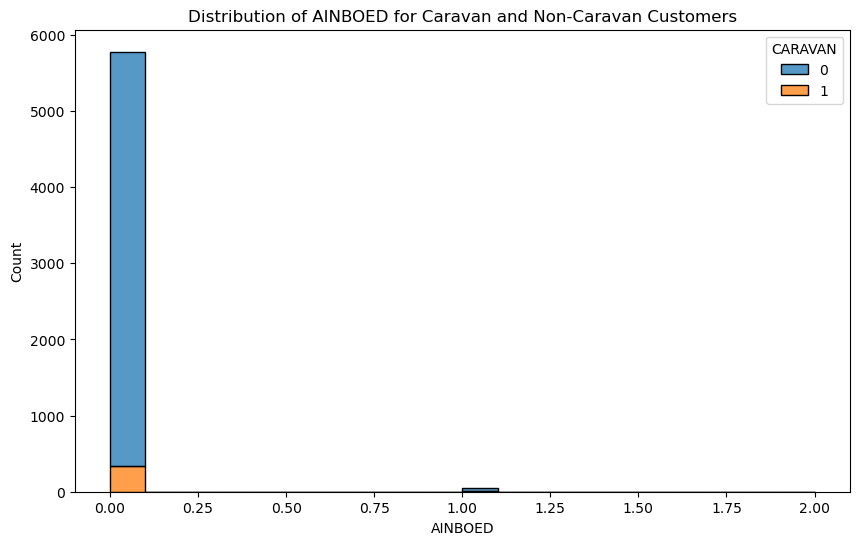

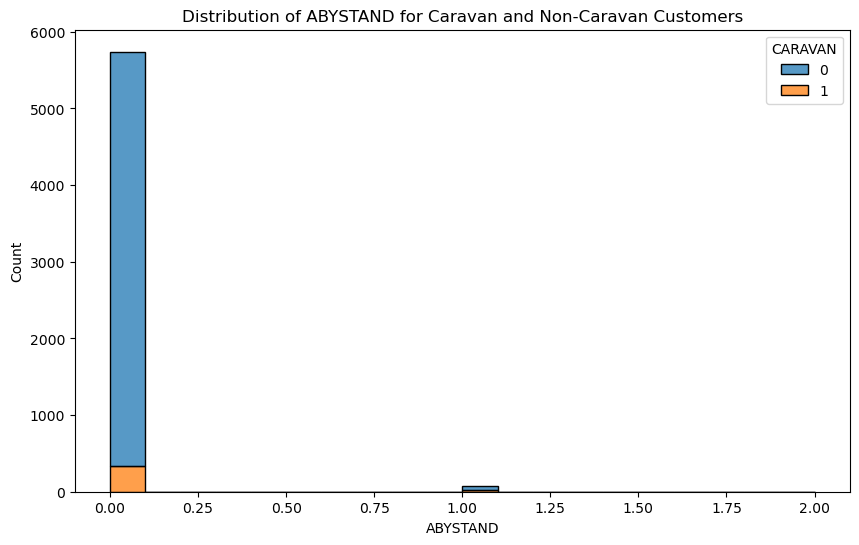

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = list(range(43))  # Columns 0-42 are considered categorical
numerical_features = list(range(43, 85))  # Columns 43-84 are considered numerical

# Plot histograms for all numerical features
eda.hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Compare distributions of features for customers with and without a caravan policy
for col in eda.columns:
    if col != 'CARAVAN':  # Assuming 'CARAVAN' is the target column
        plt.figure(figsize=(10, 6))
        sns.histplot(data=eda, x=col, hue='CARAVAN', multiple='stack', bins=20)
        plt.title(f'Distribution of {col} for Caravan and Non-Caravan Customers')
        plt.show()


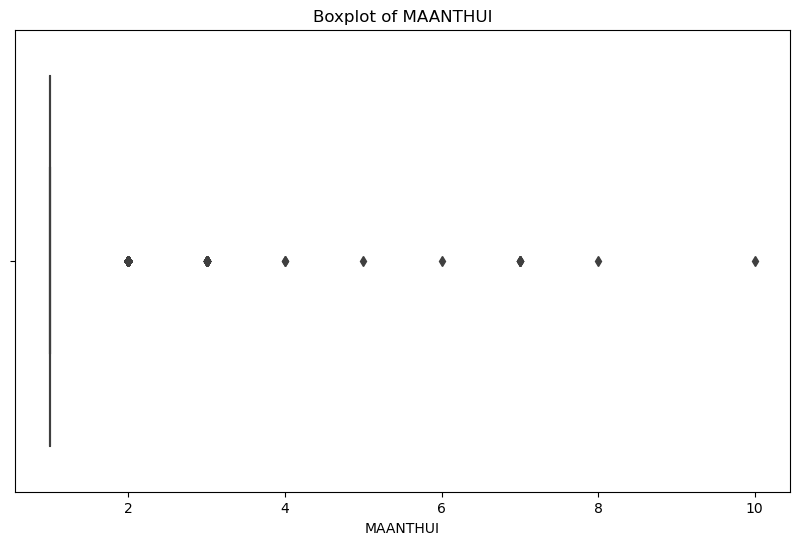

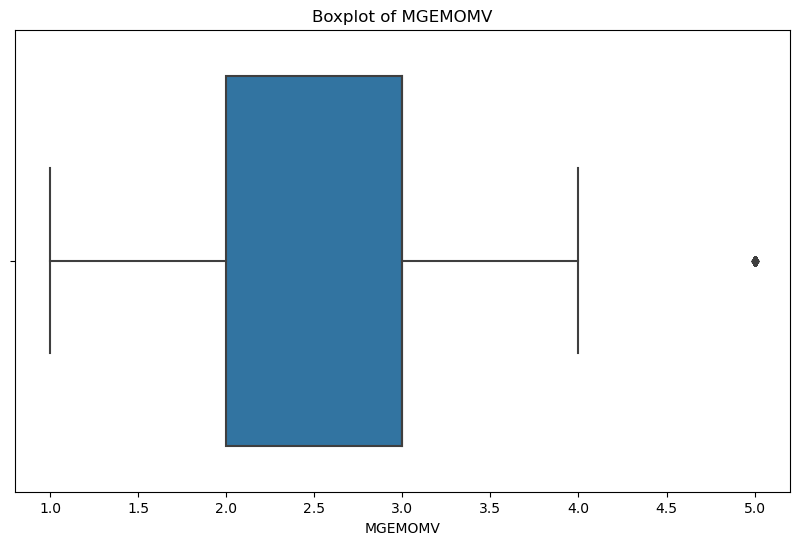

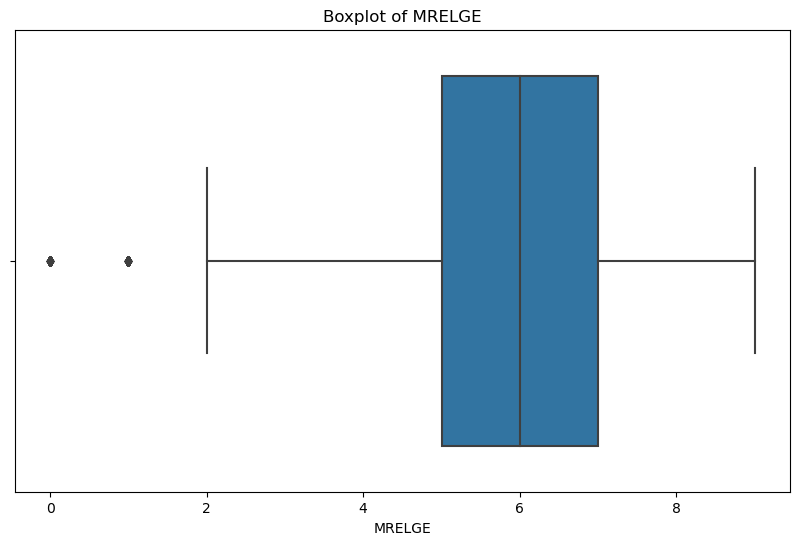

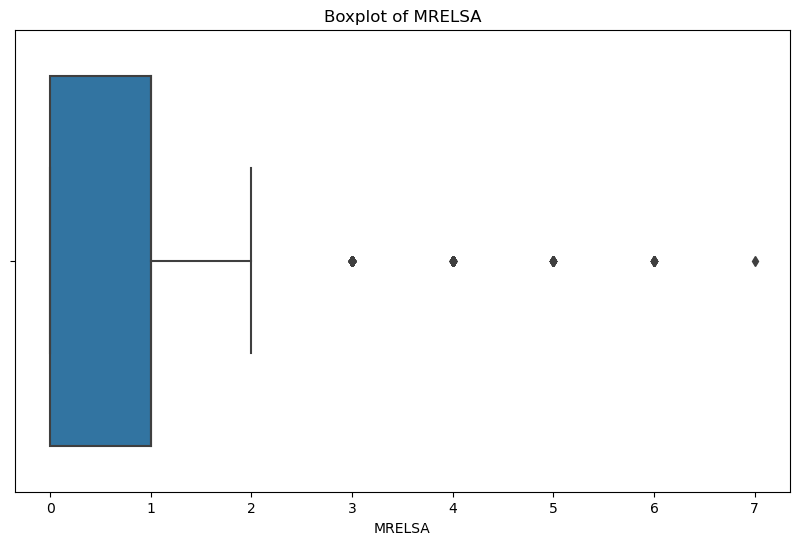

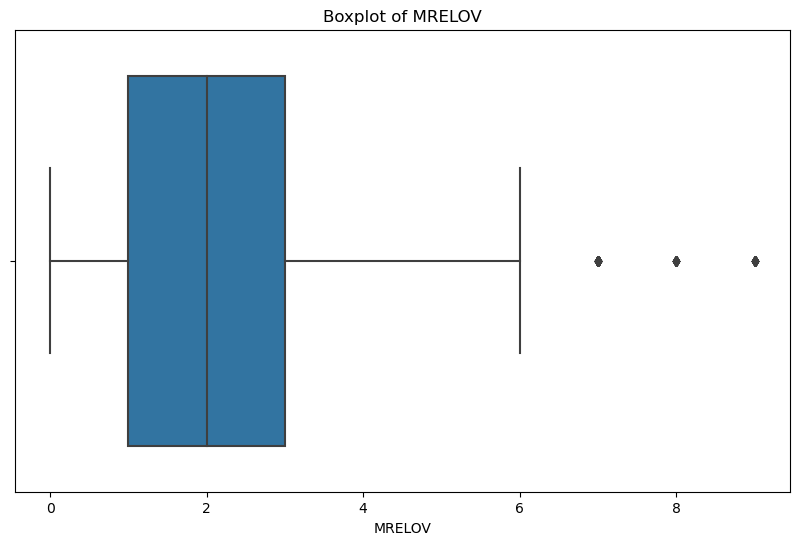

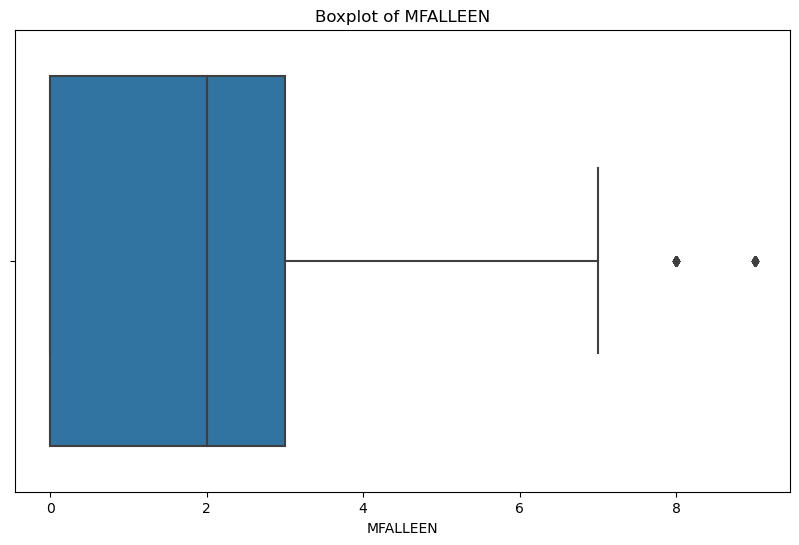

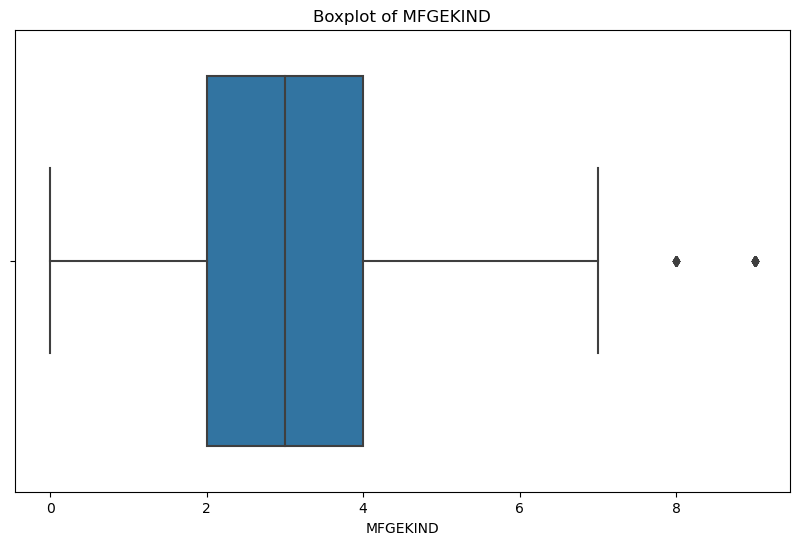

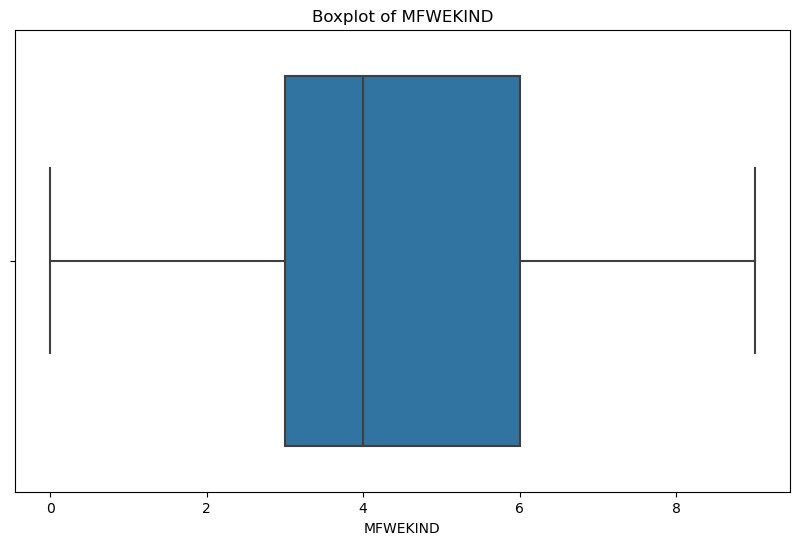

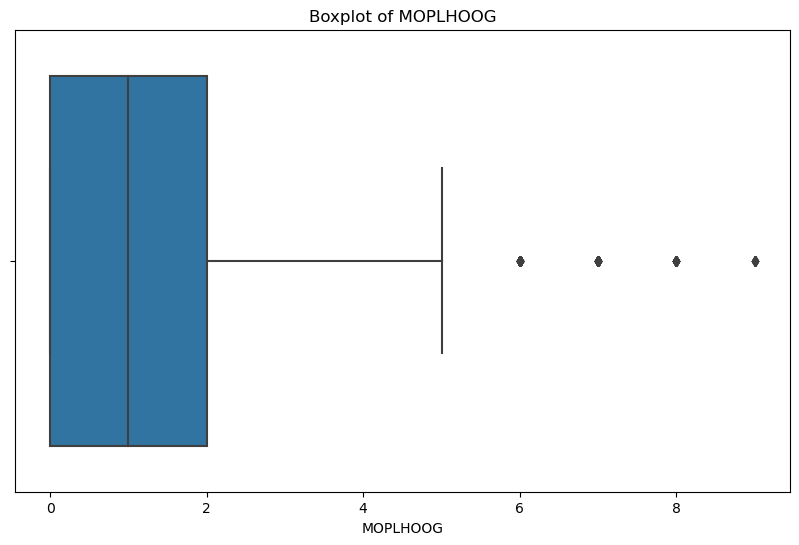

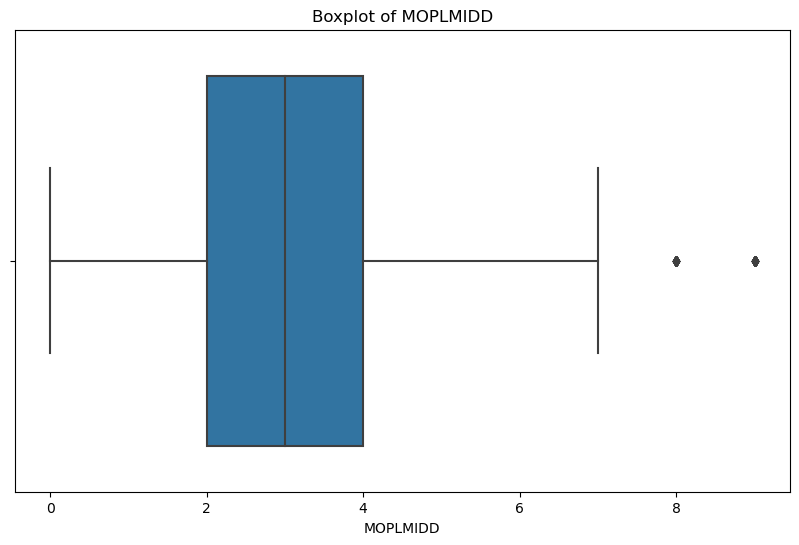

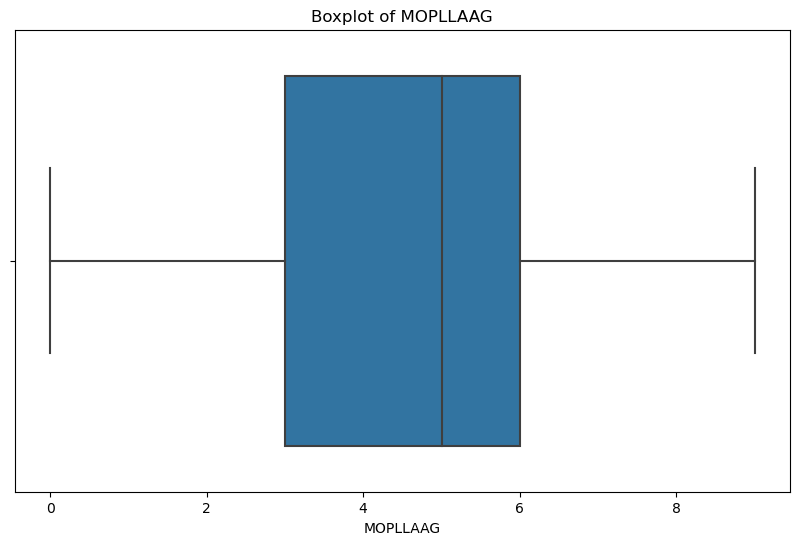

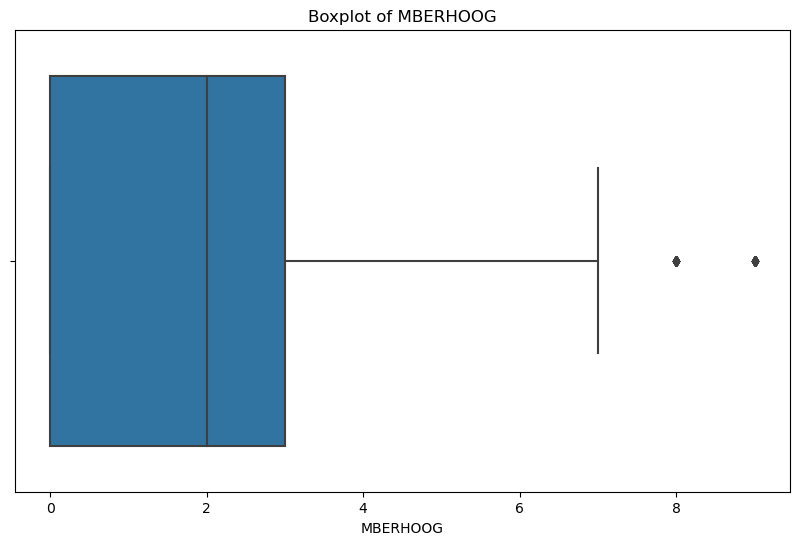

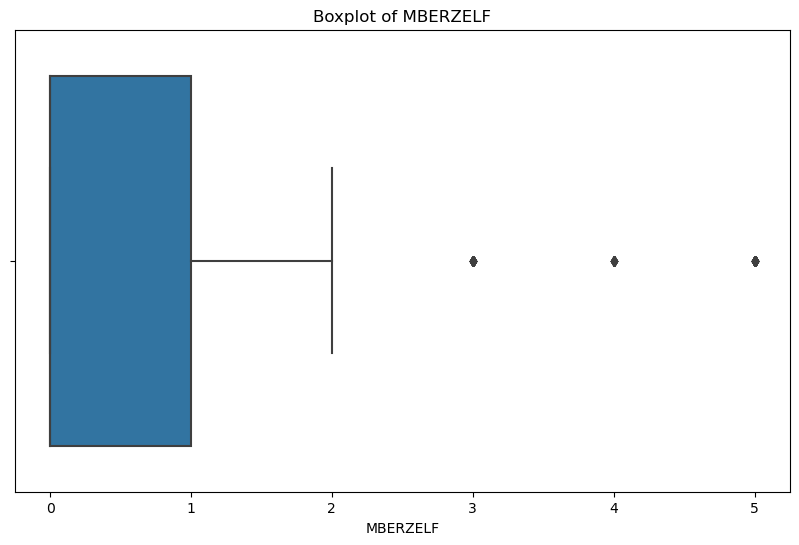

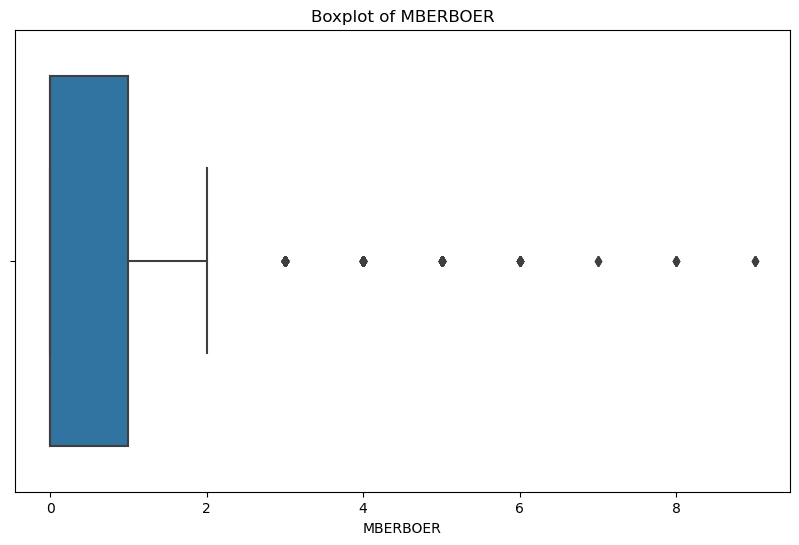

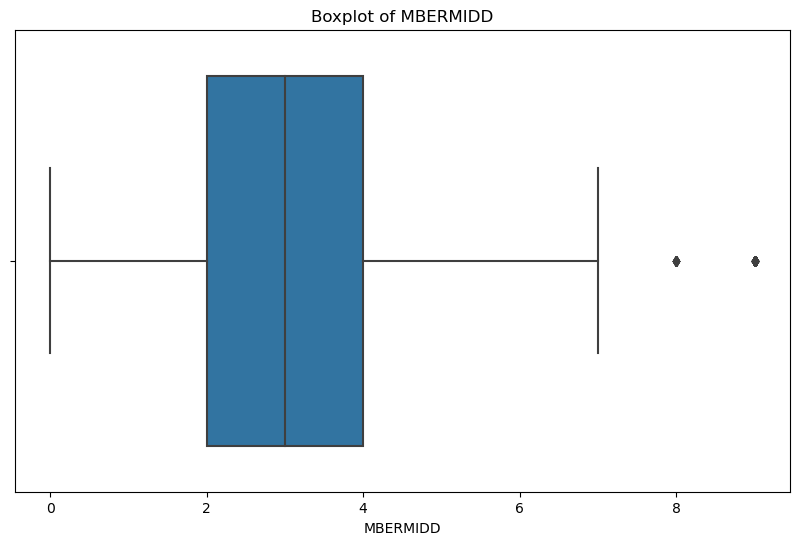

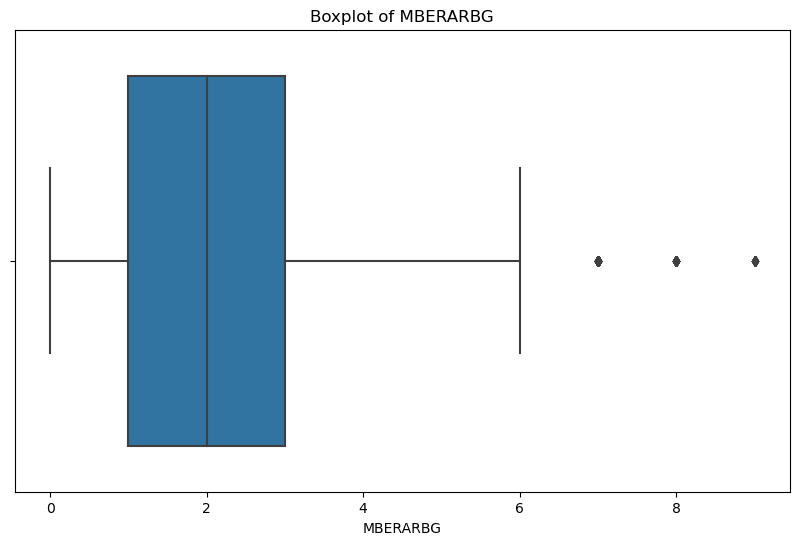

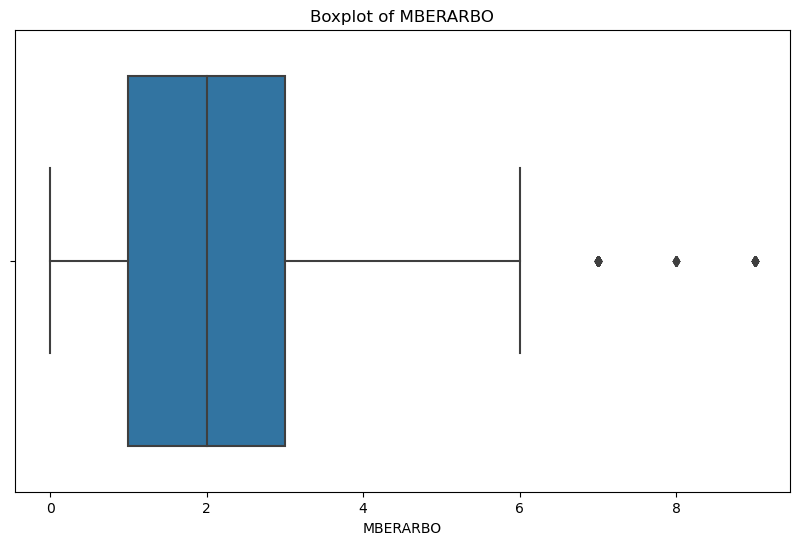

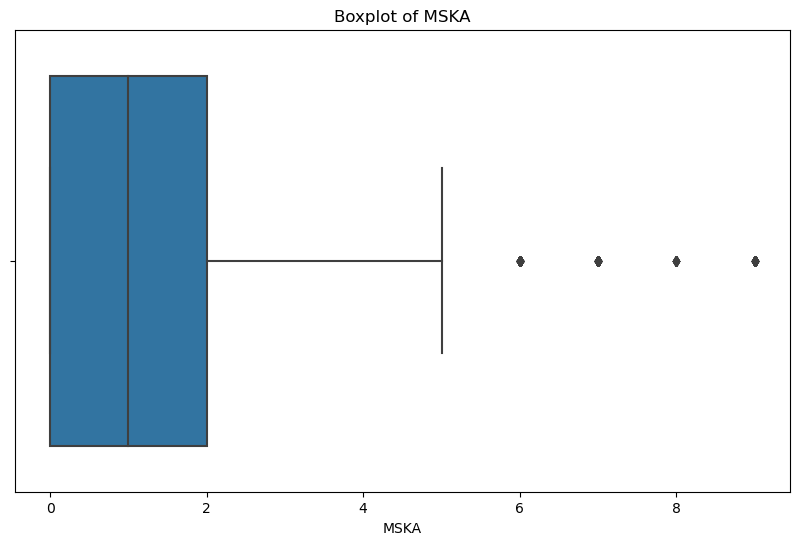

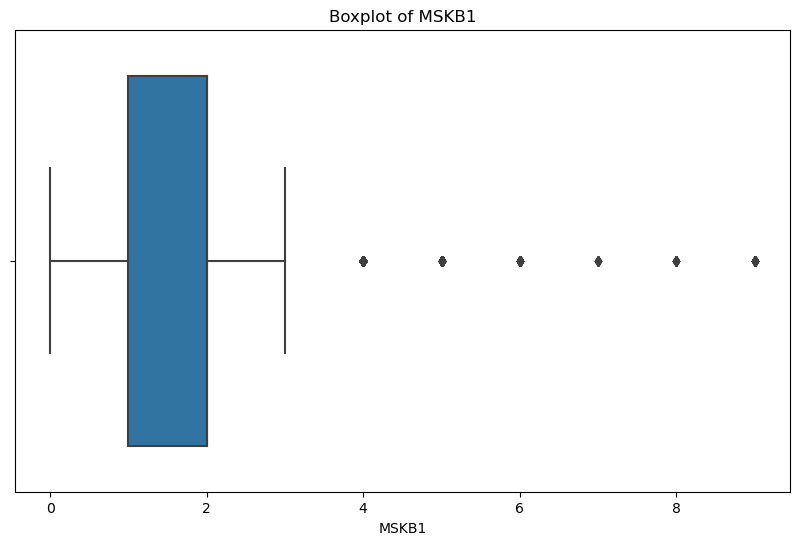

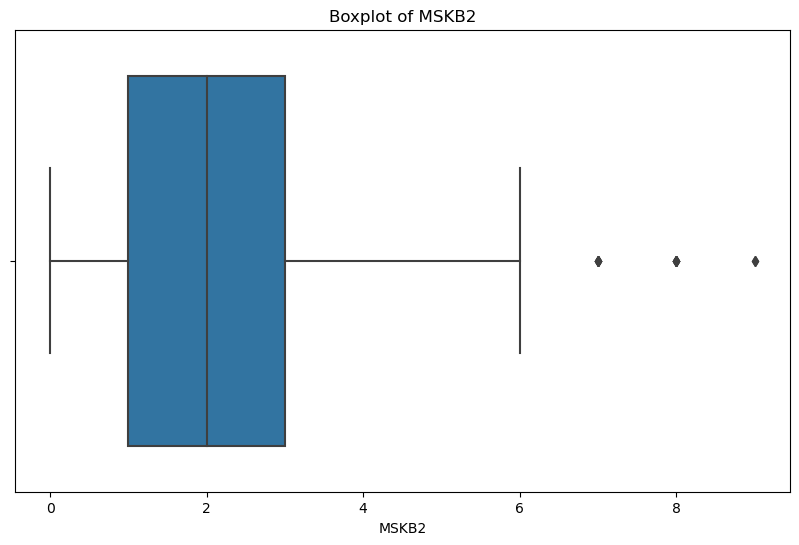

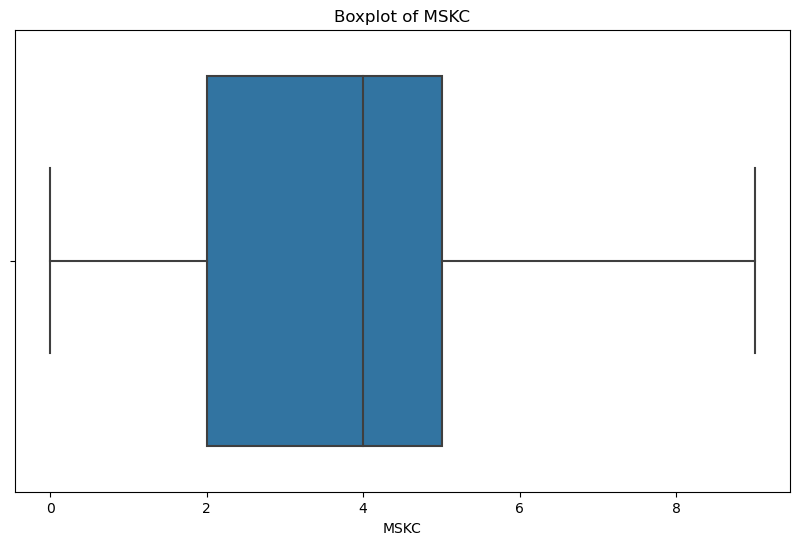

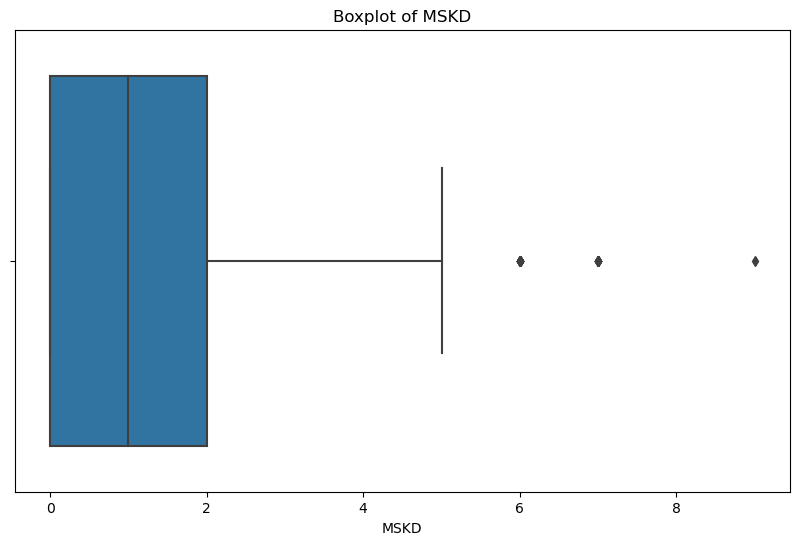

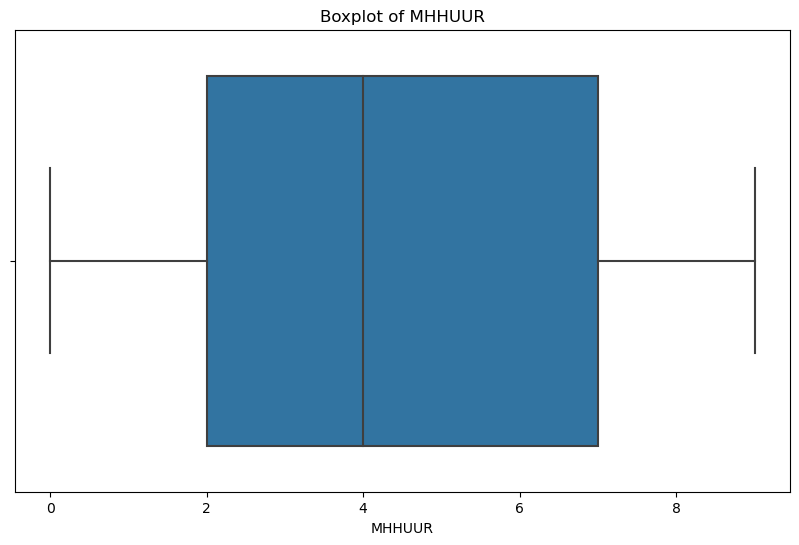

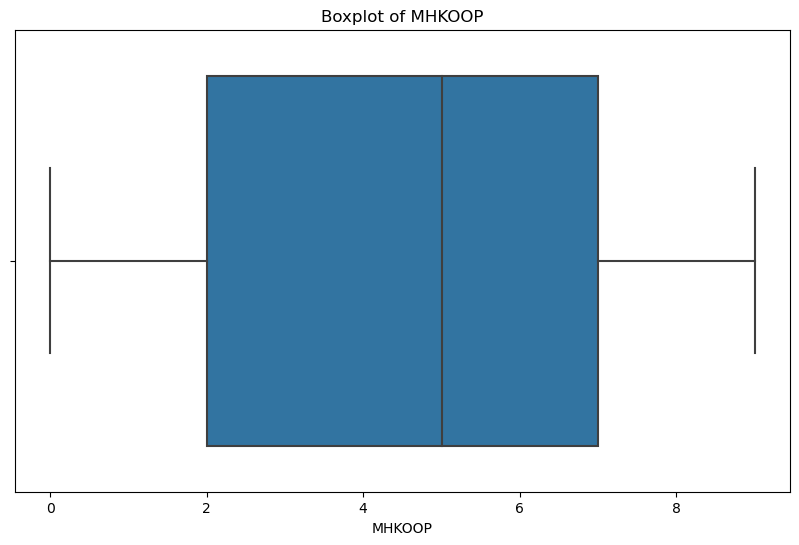

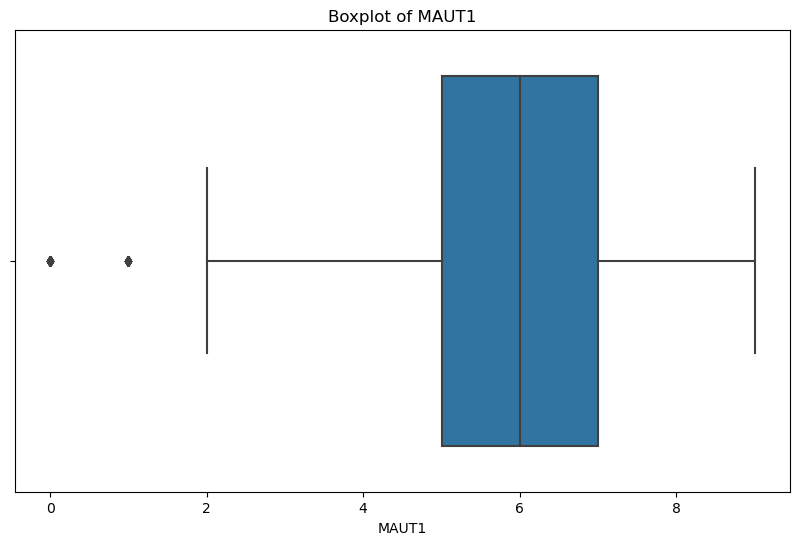

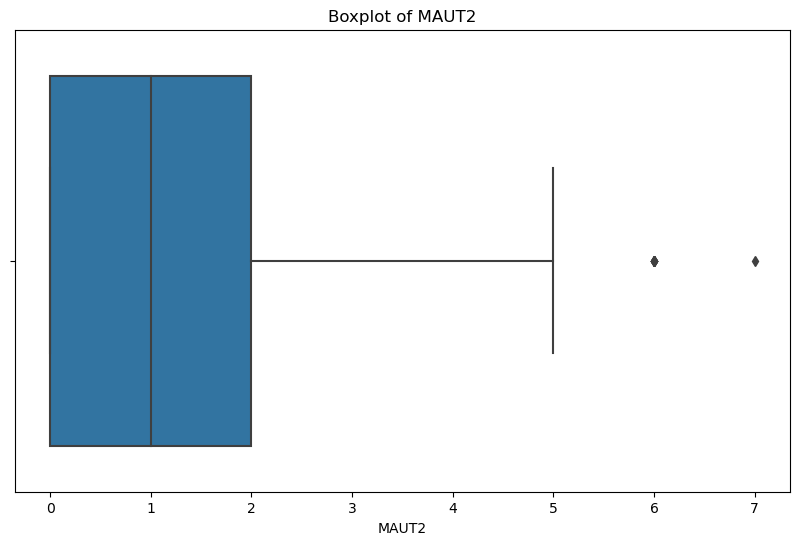

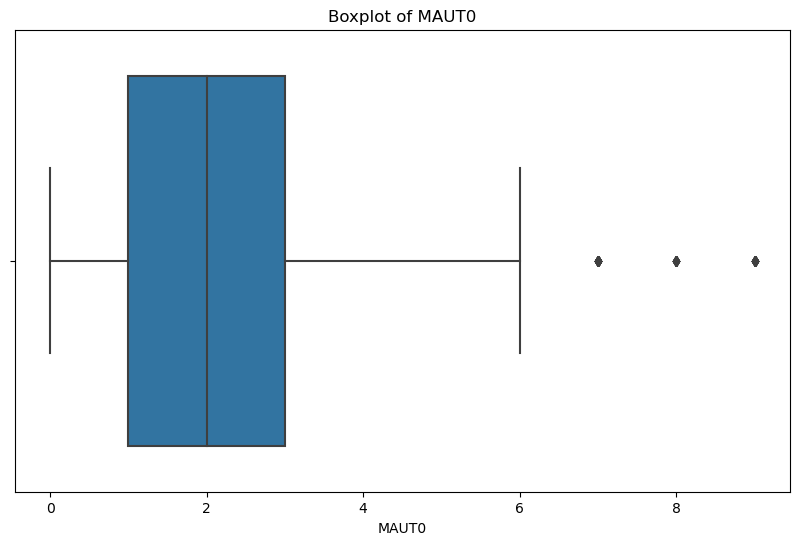

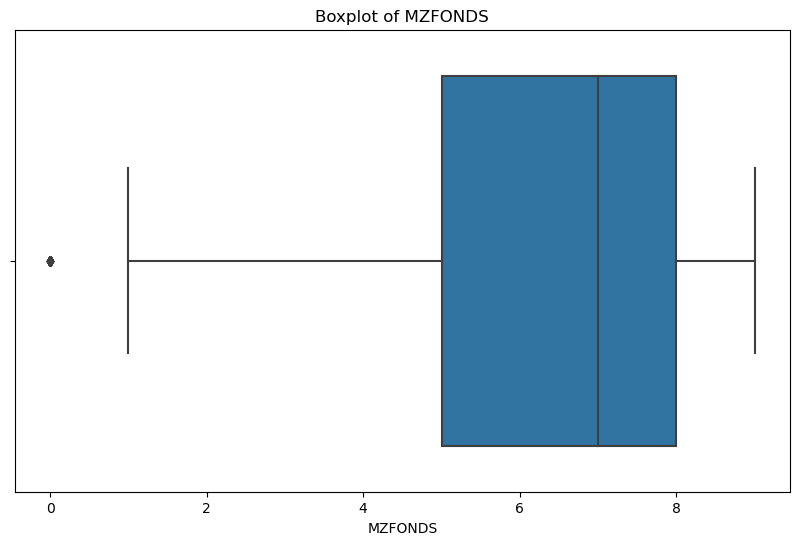

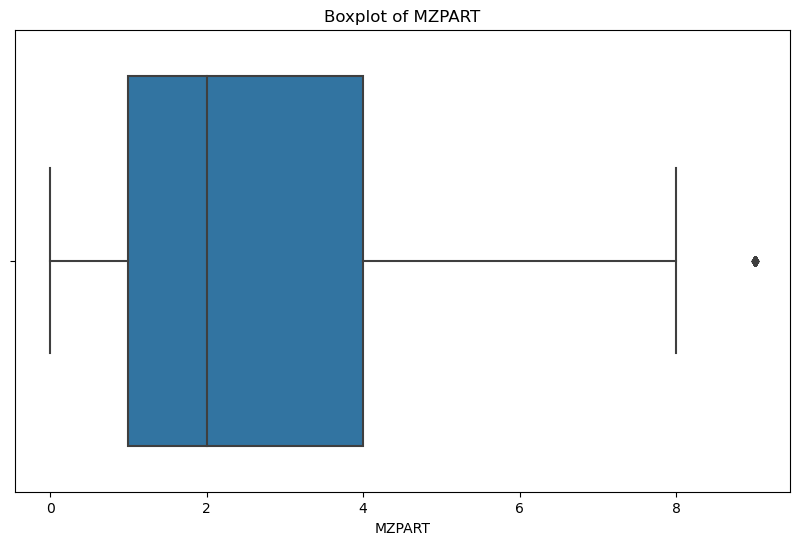

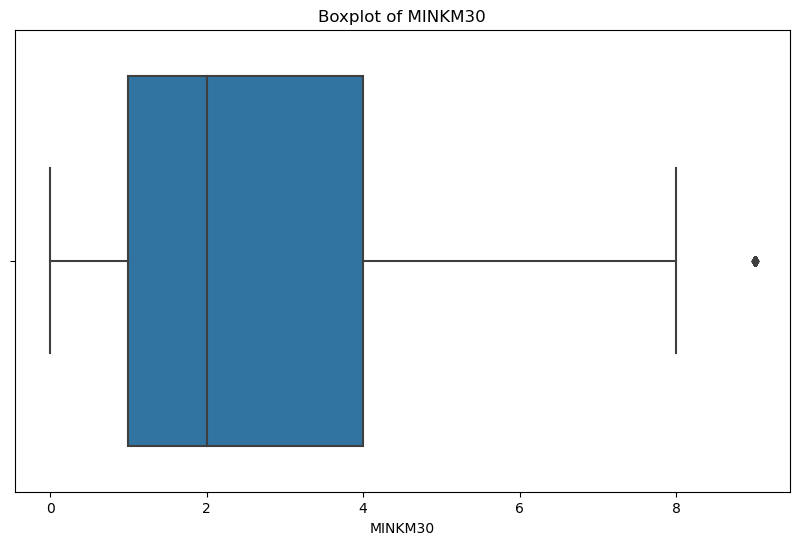

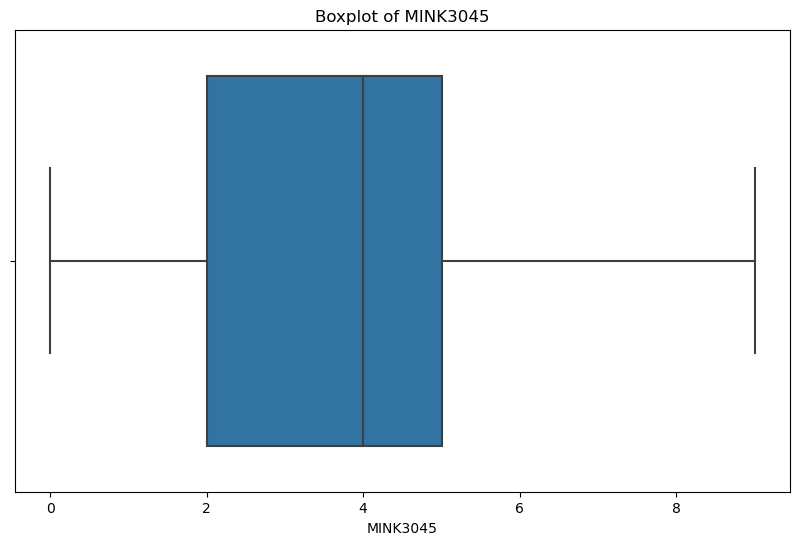

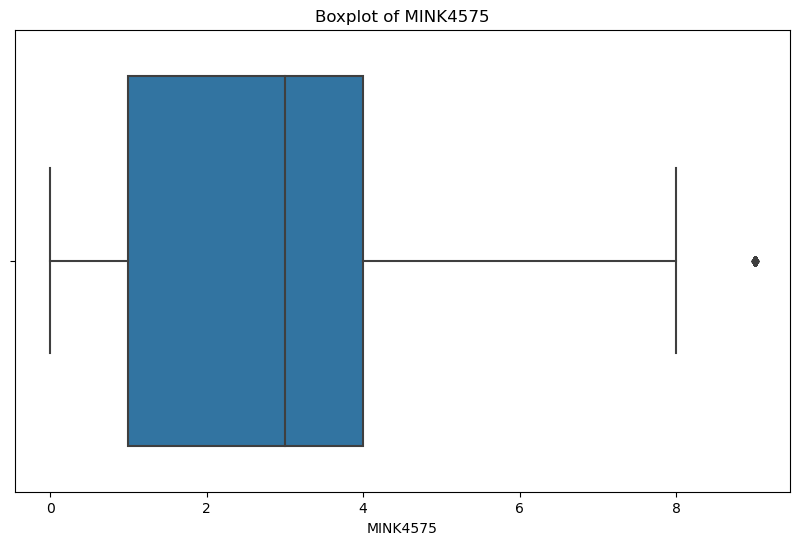

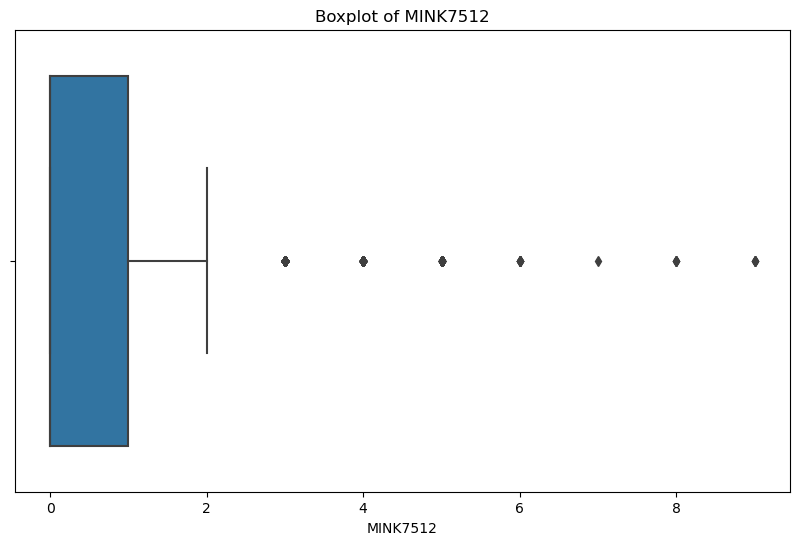

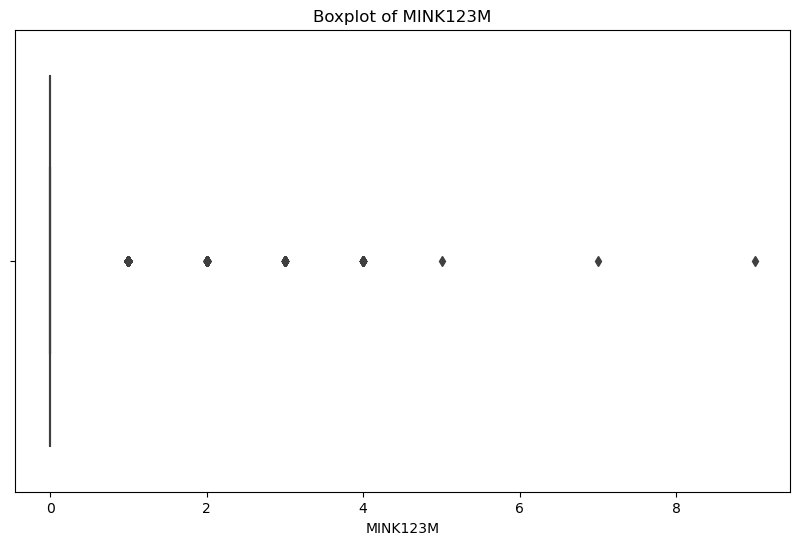

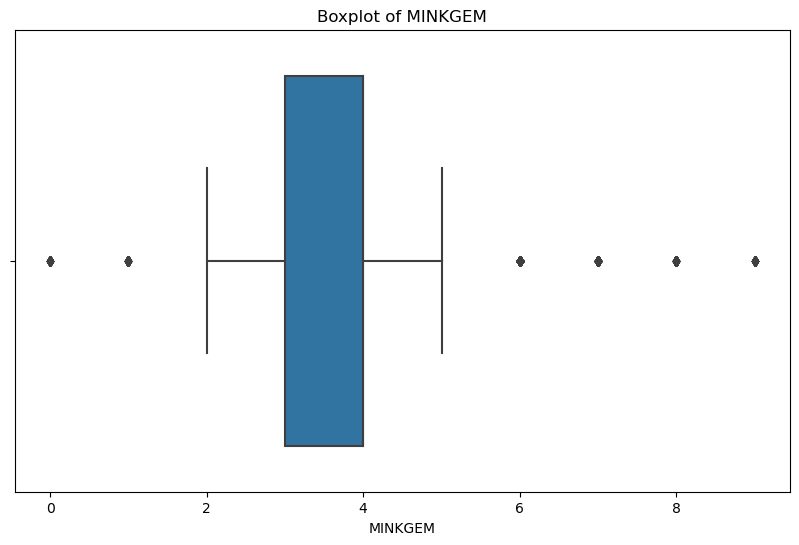

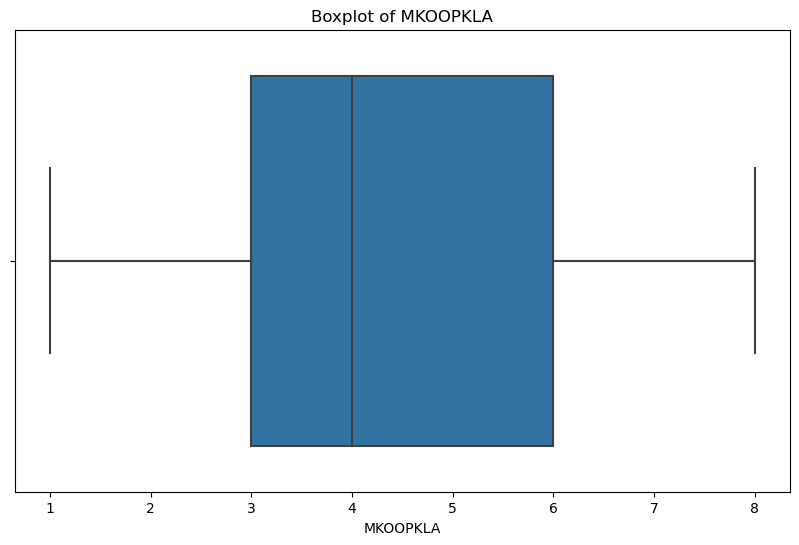

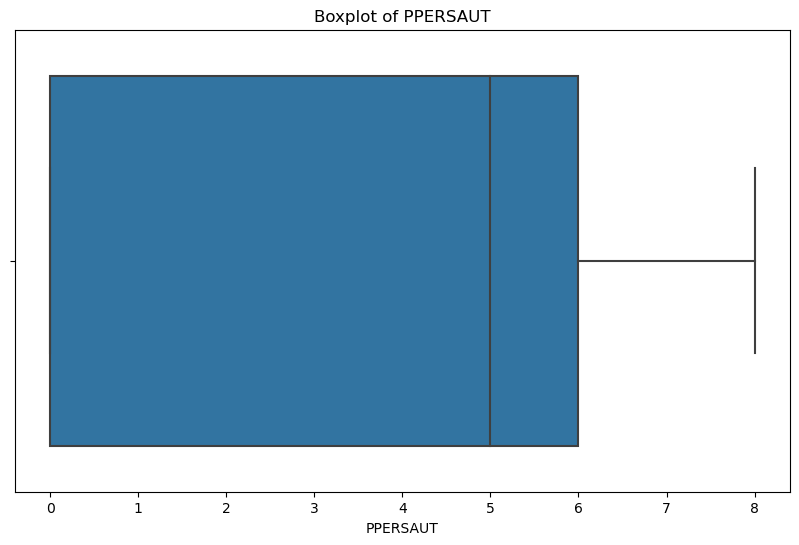

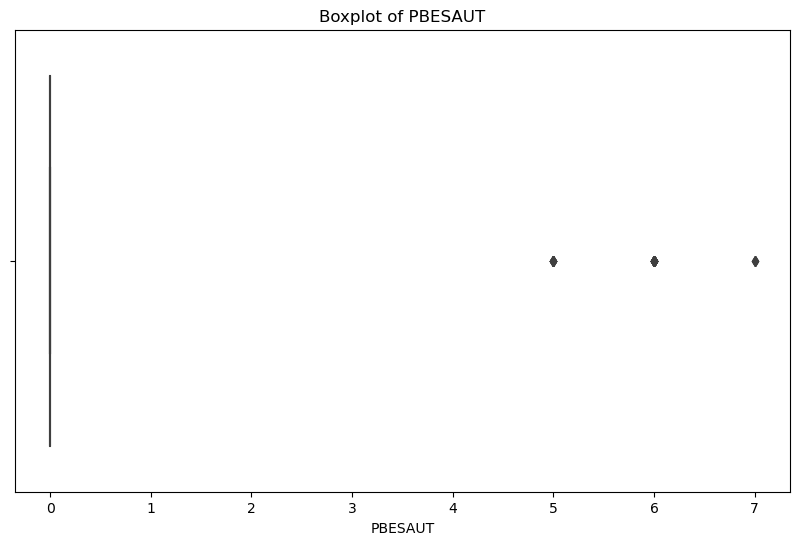

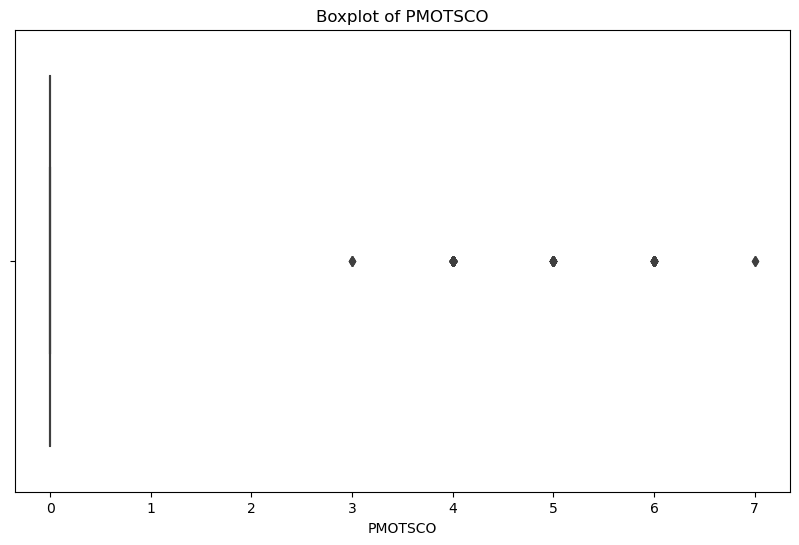

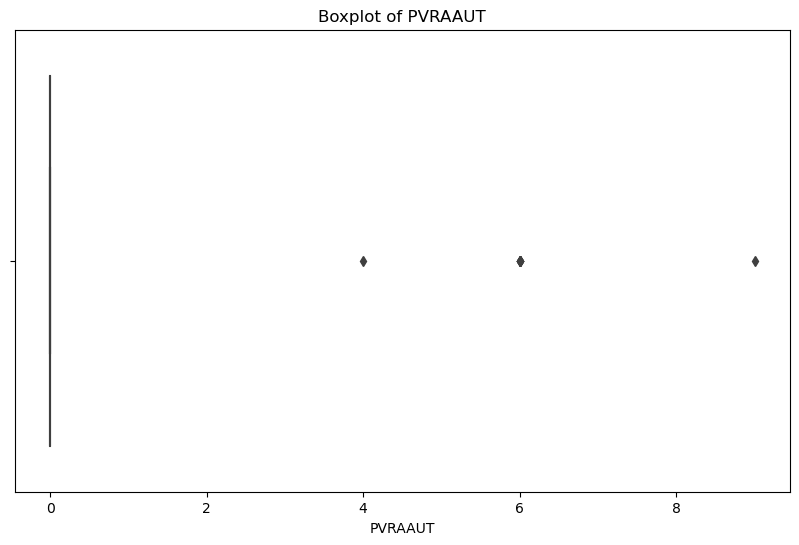

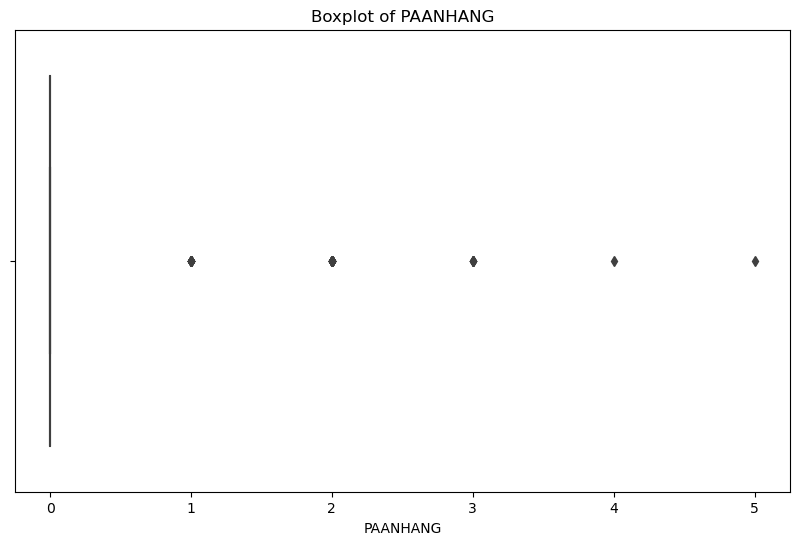

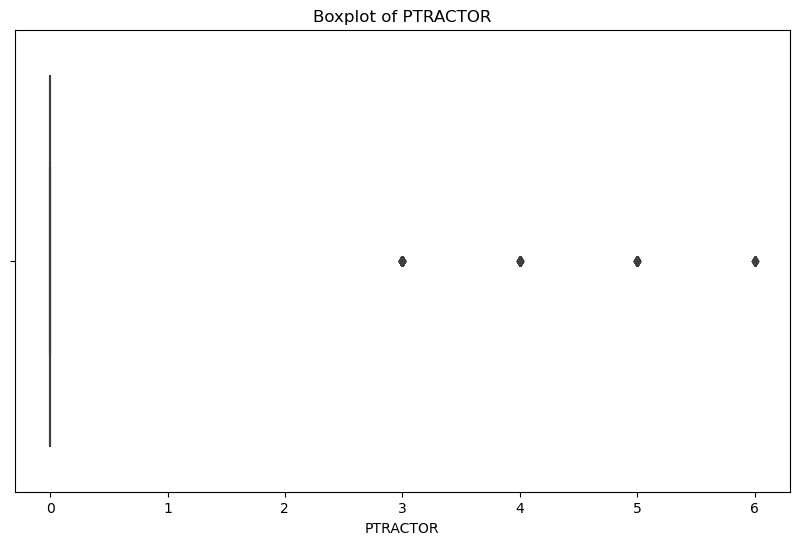

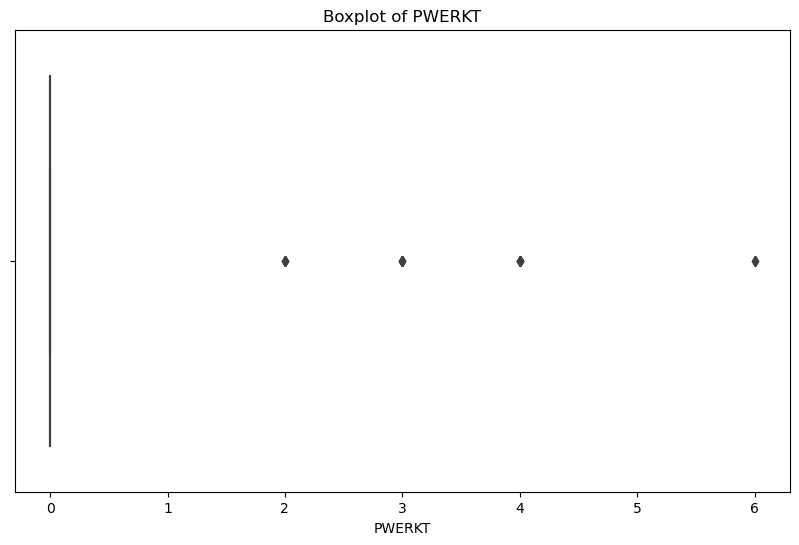

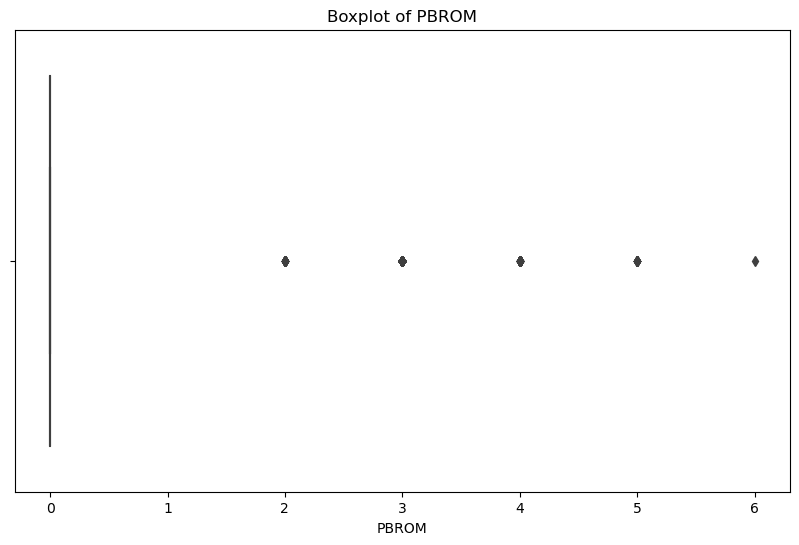

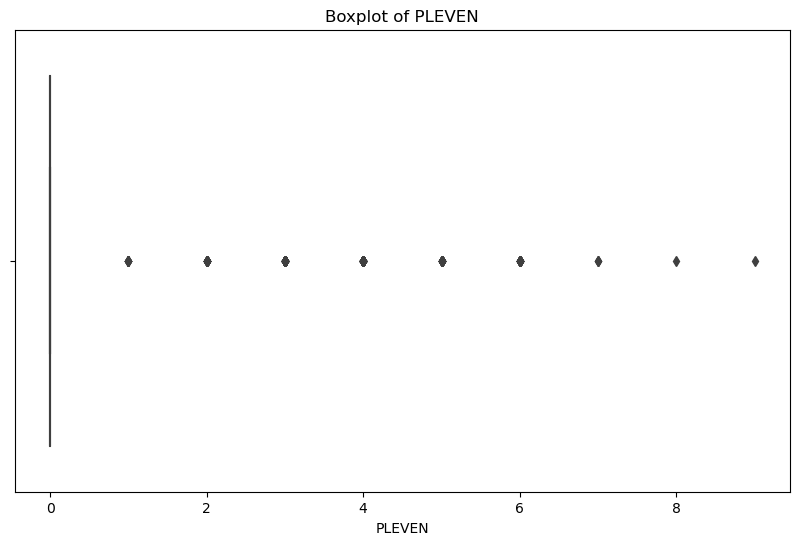

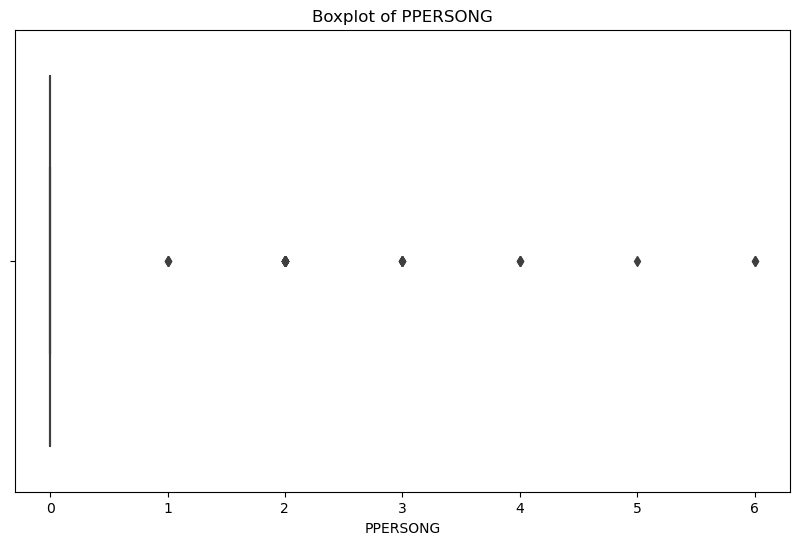

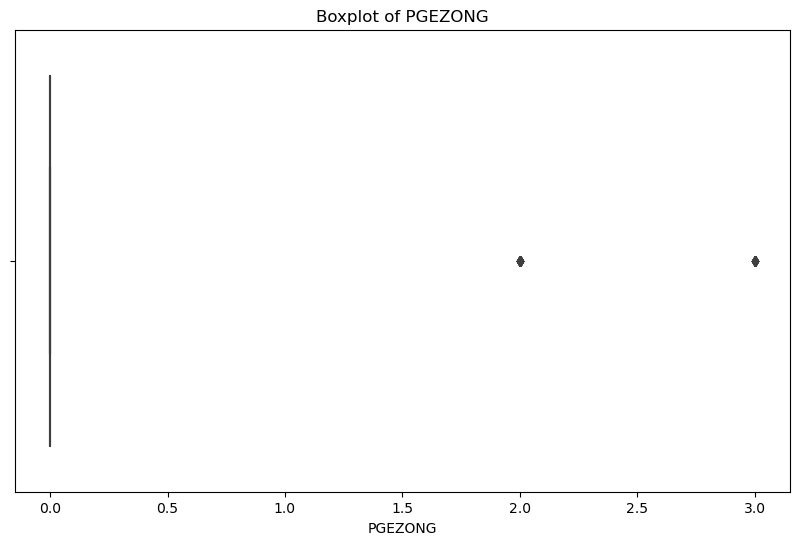

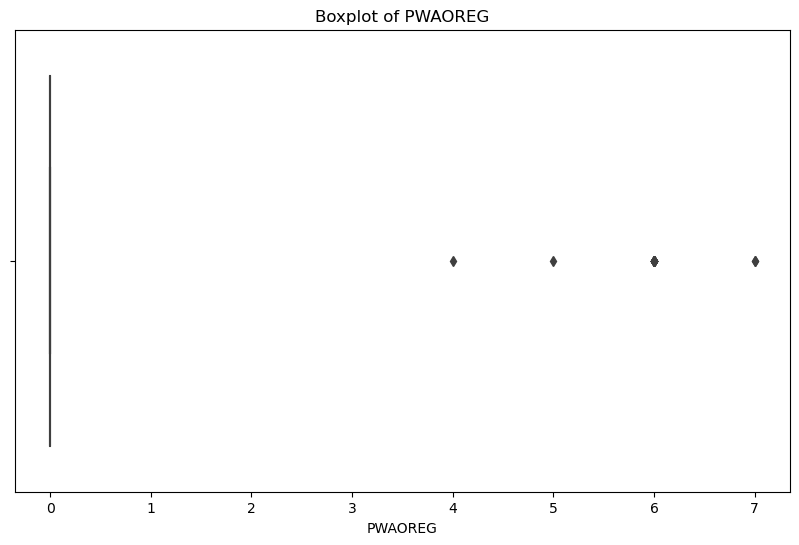

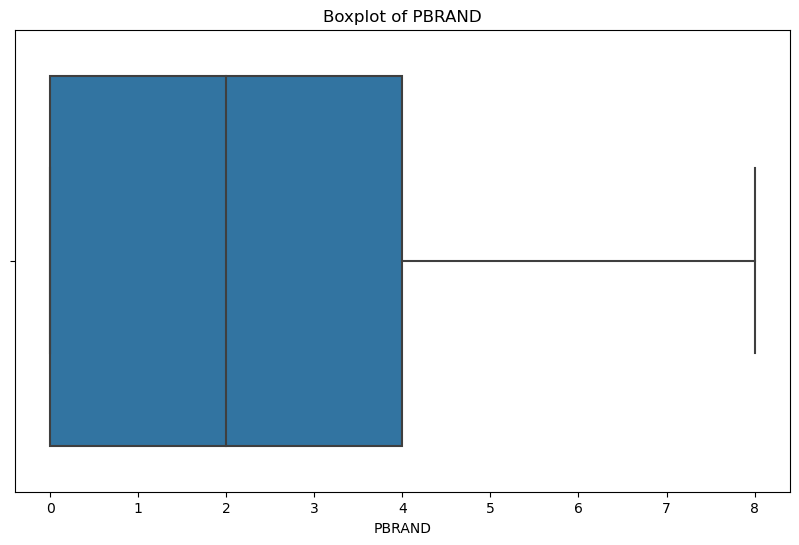

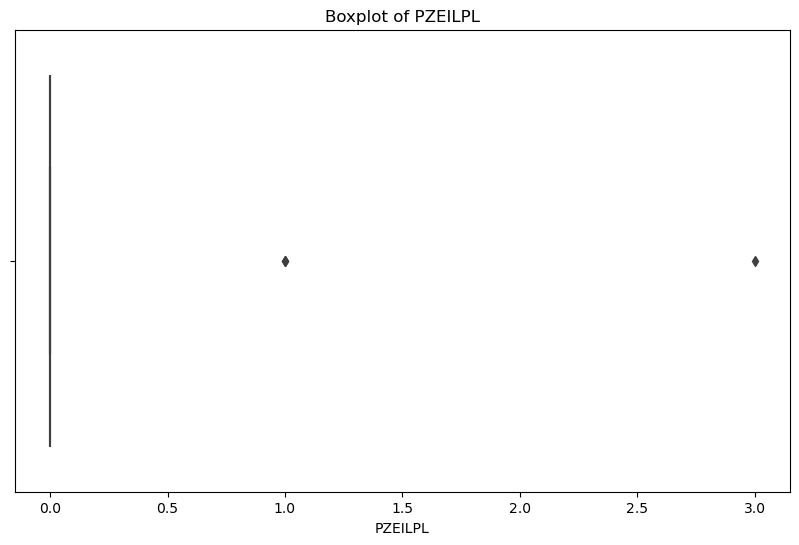

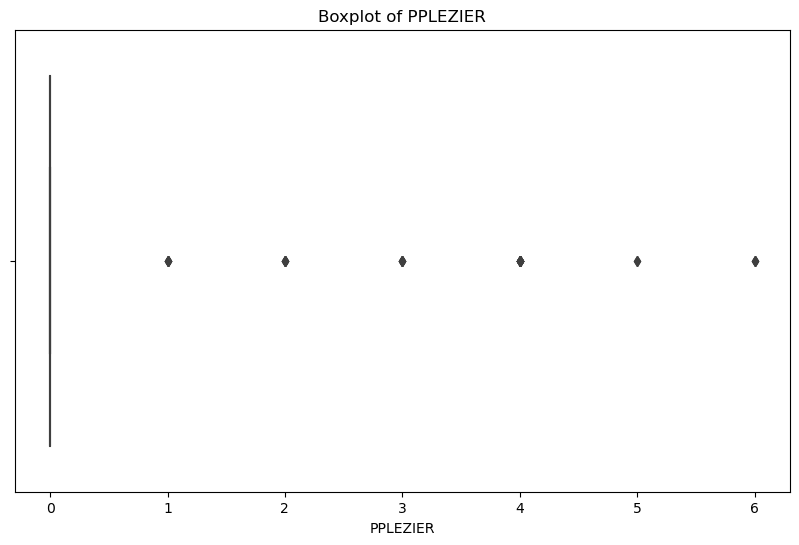

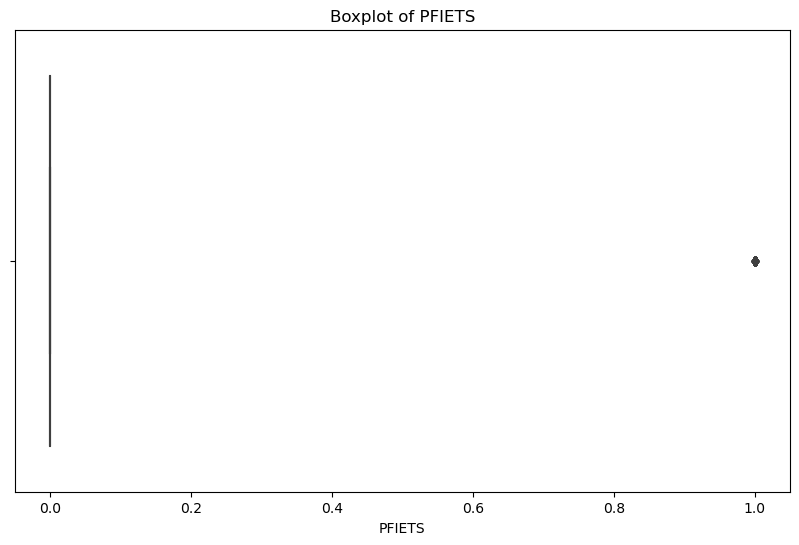

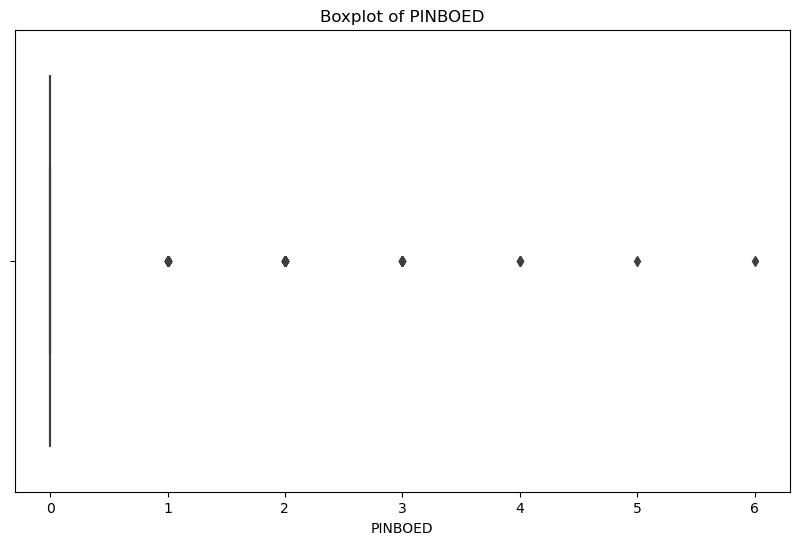

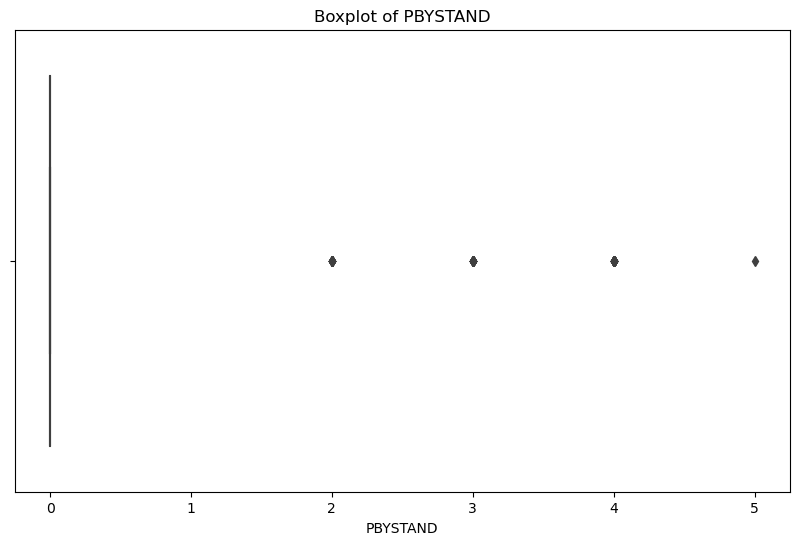

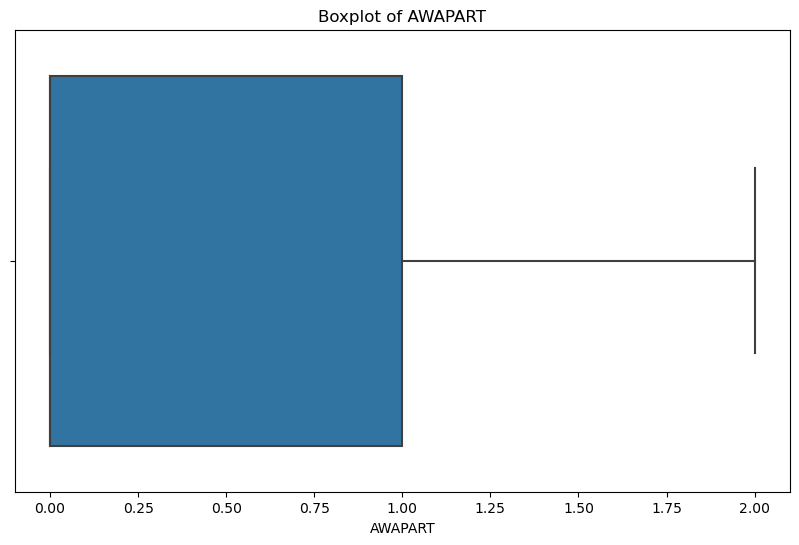

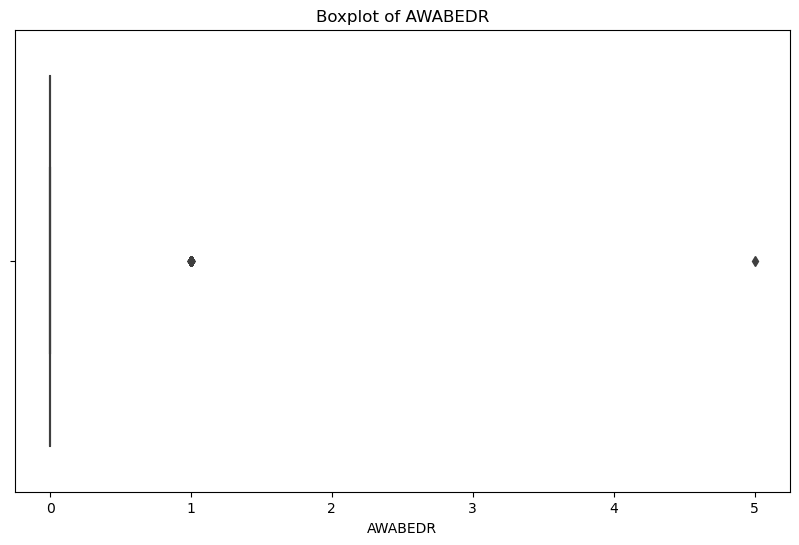

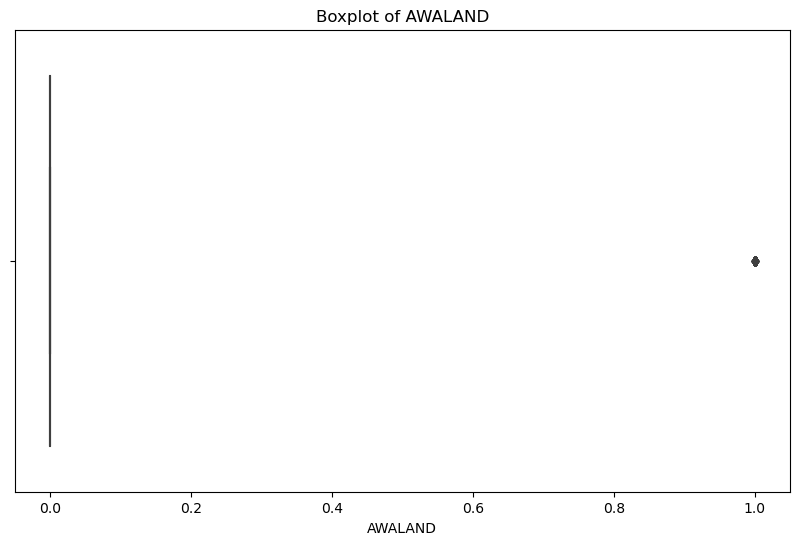

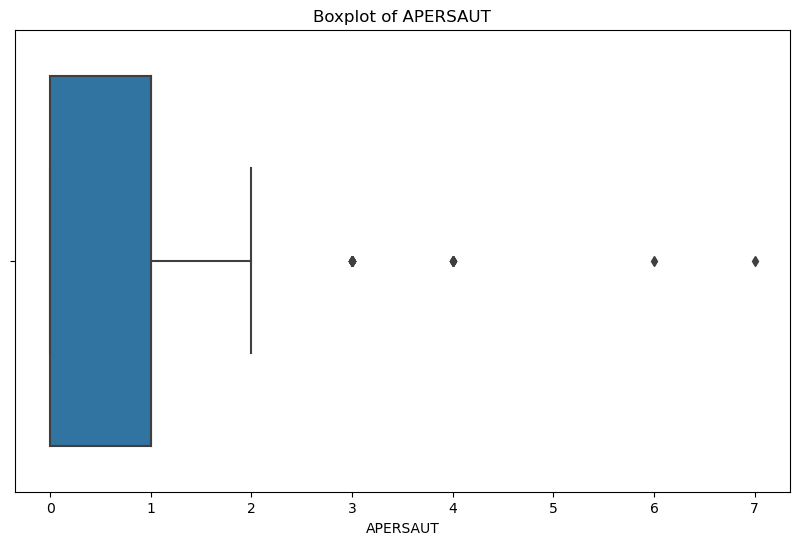

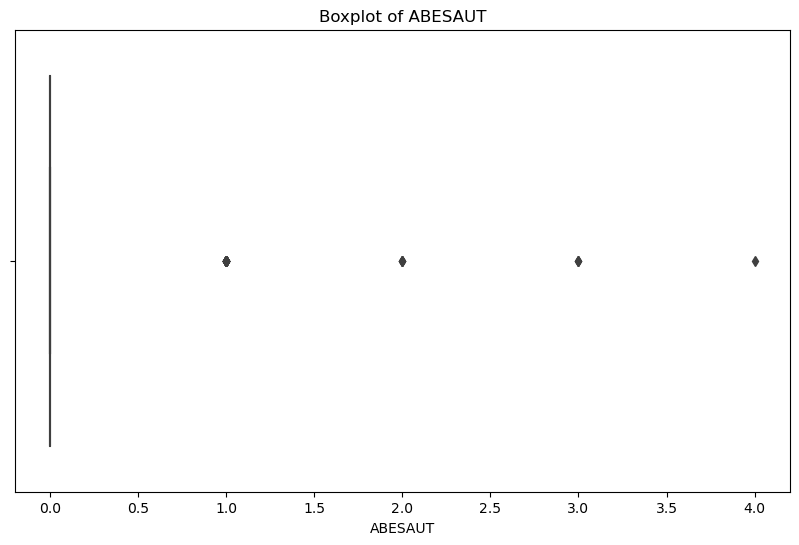

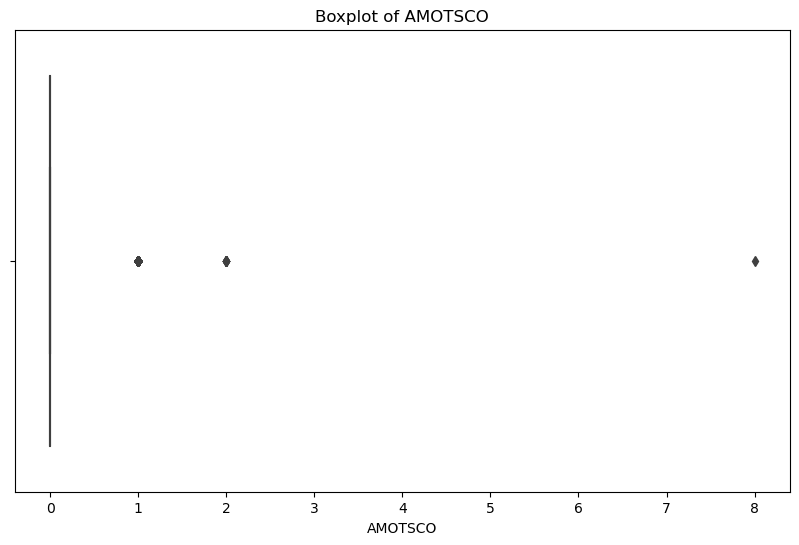

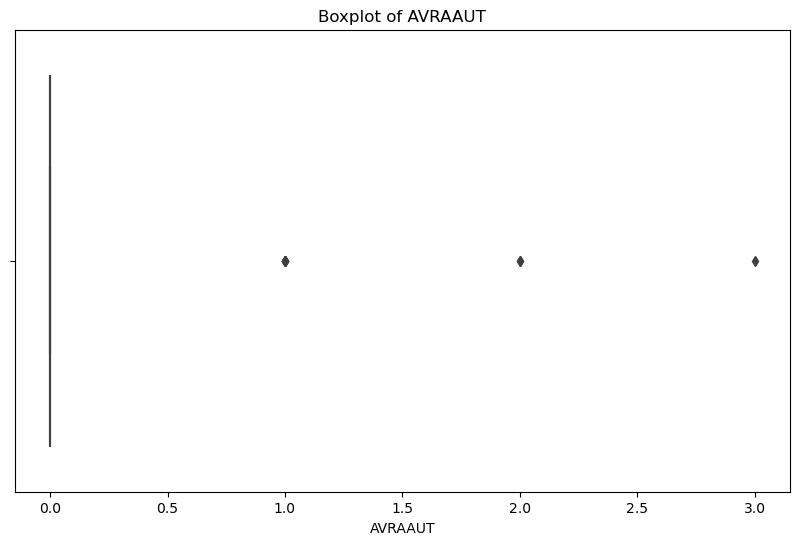

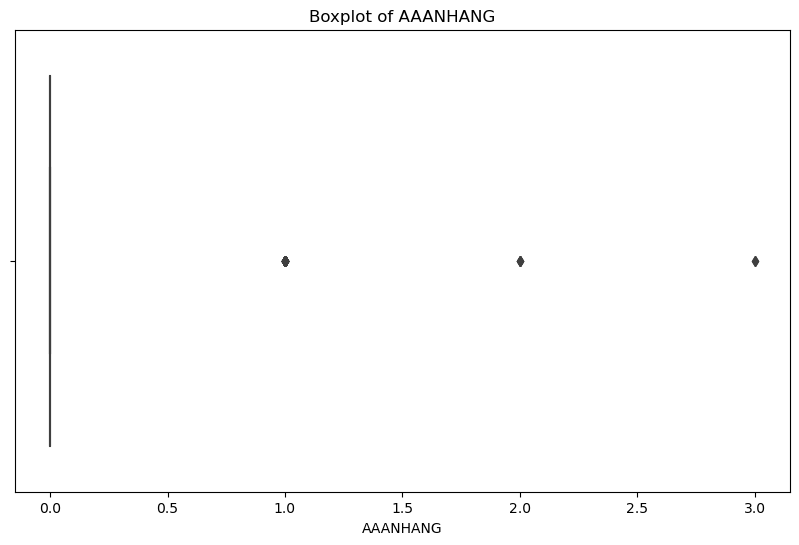

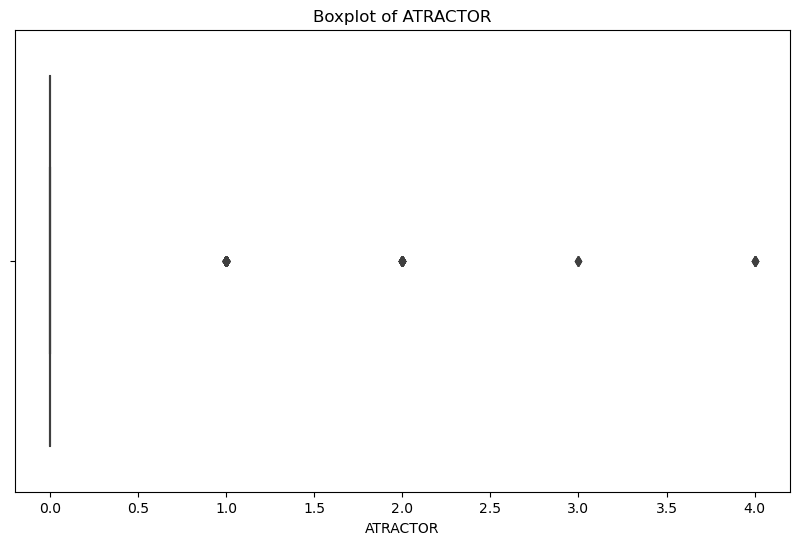

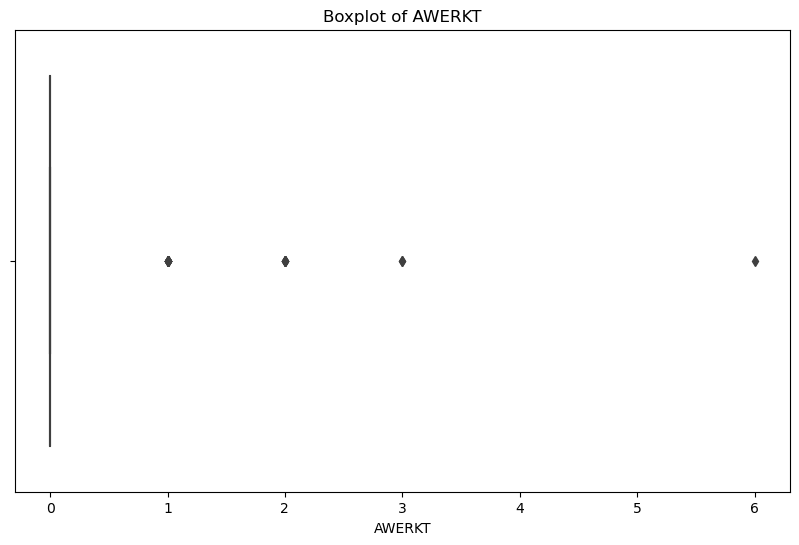

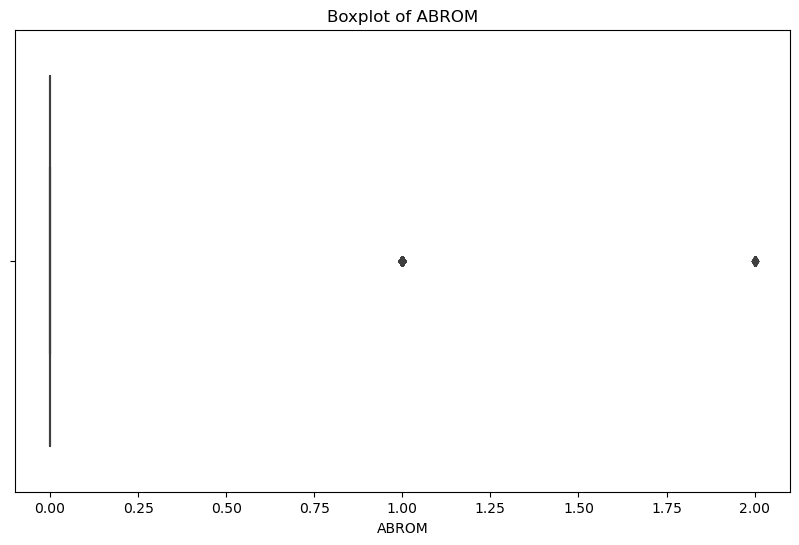

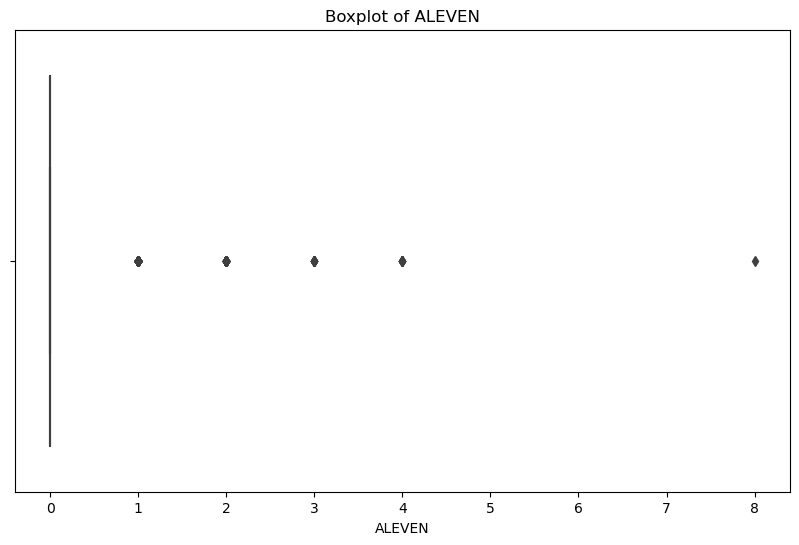

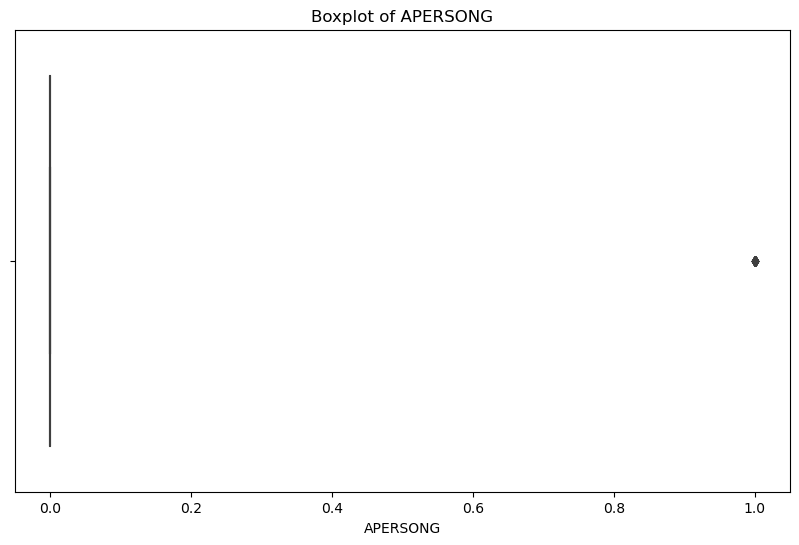

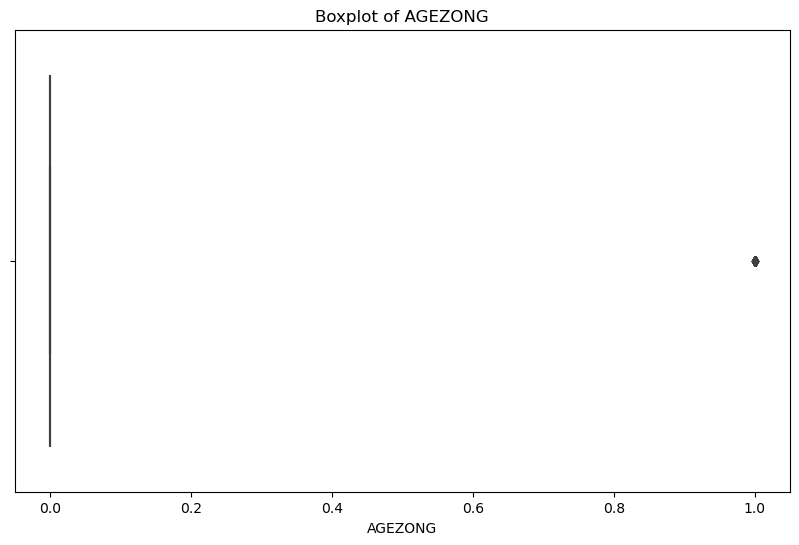

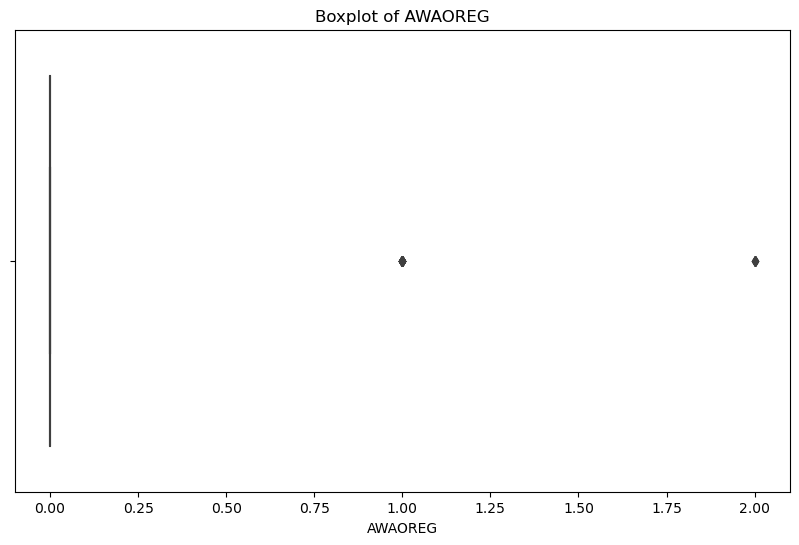

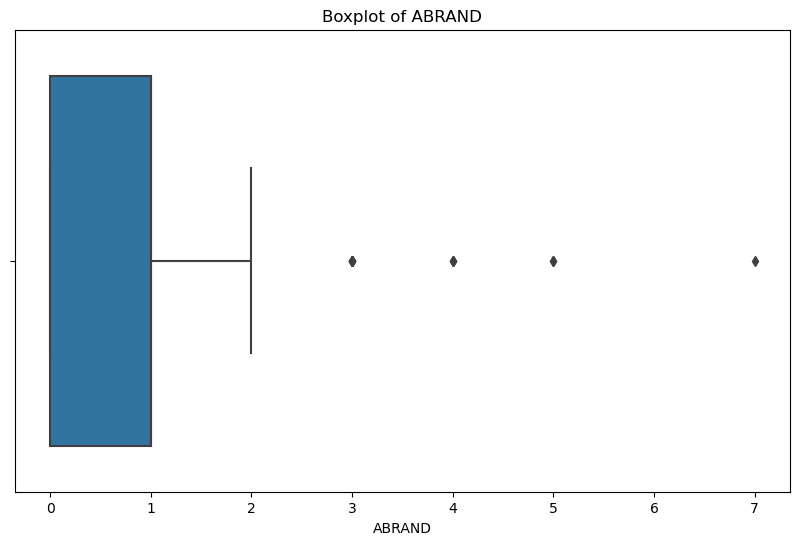

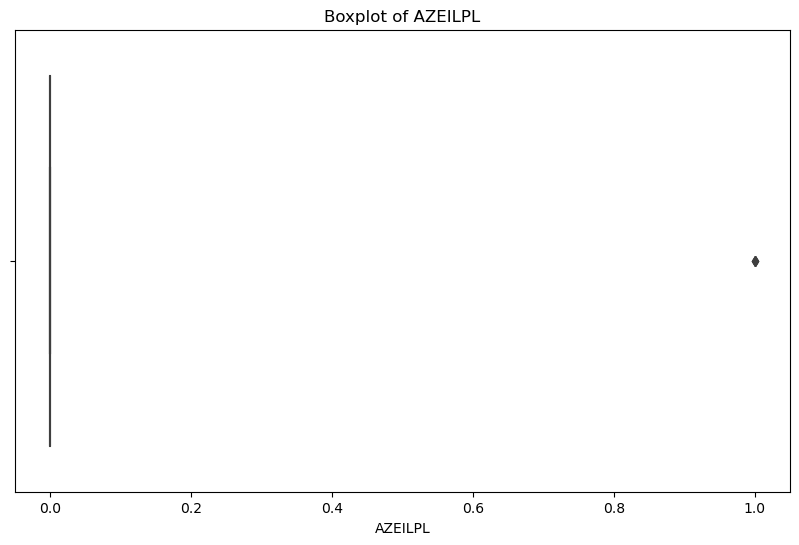

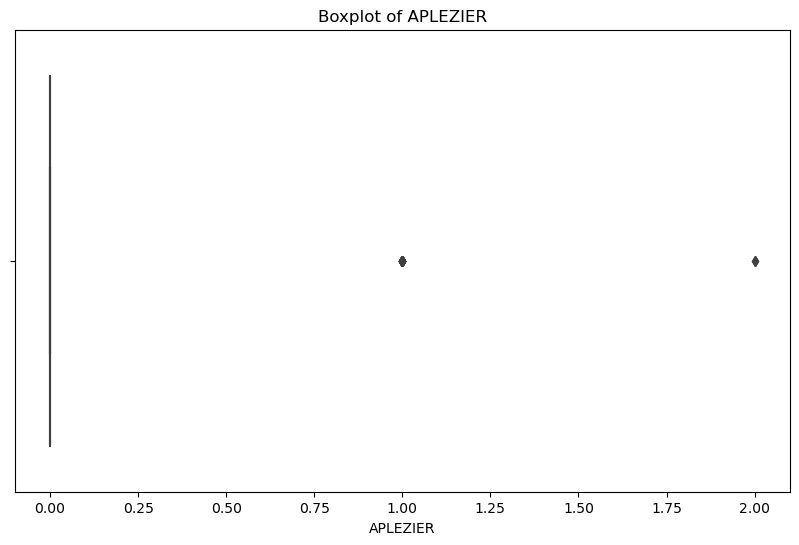

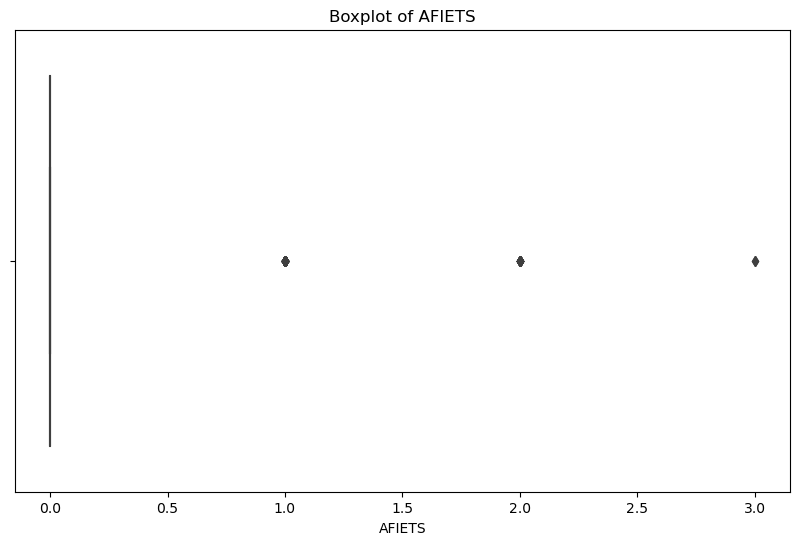

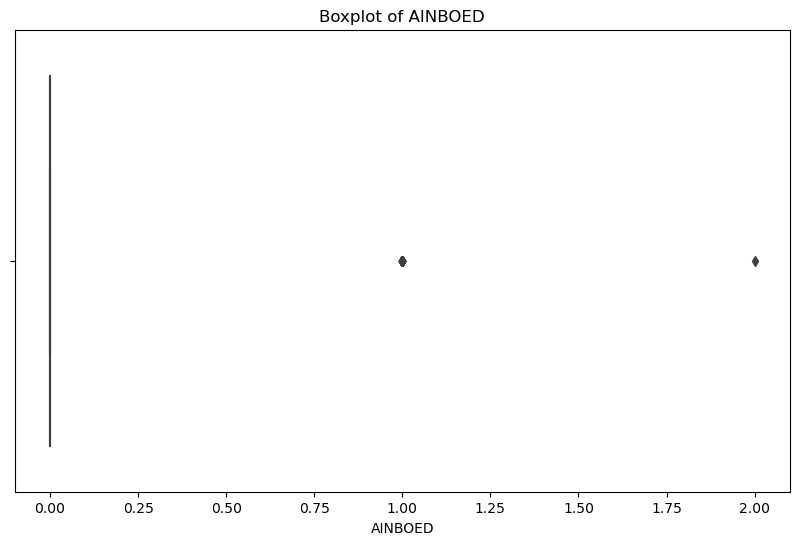

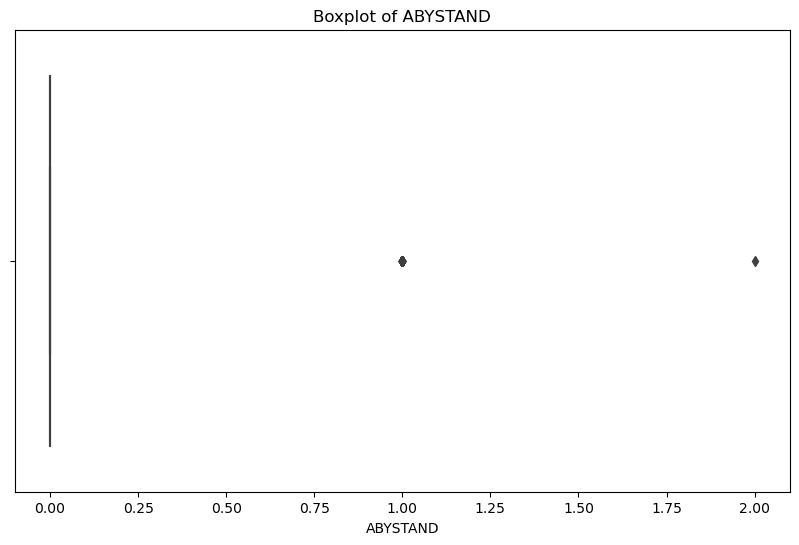

In [32]:
# Use boxplots to identify outliers in numerical features
for col in eda.columns:
    if eda[col].dtype != 'object' and col != 'CARAVAN':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=eda[col])
        plt.title(f'Boxplot of {col}')
        plt.show()


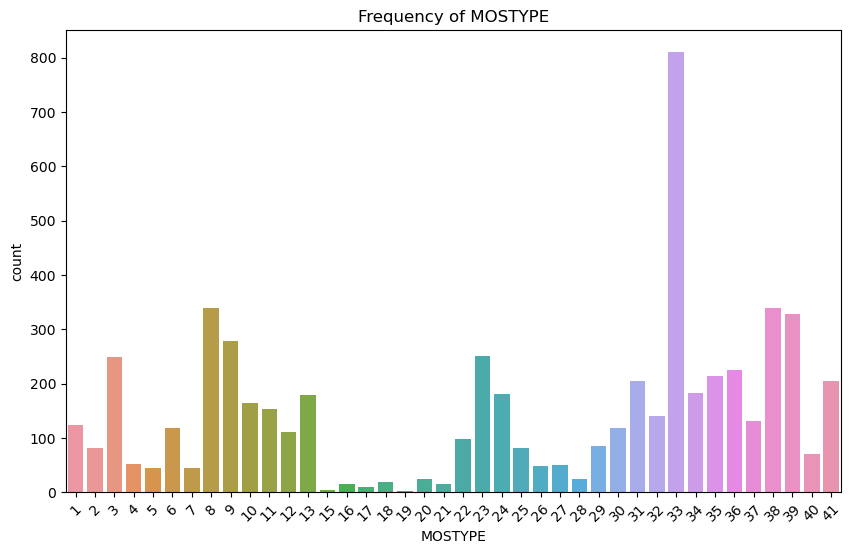

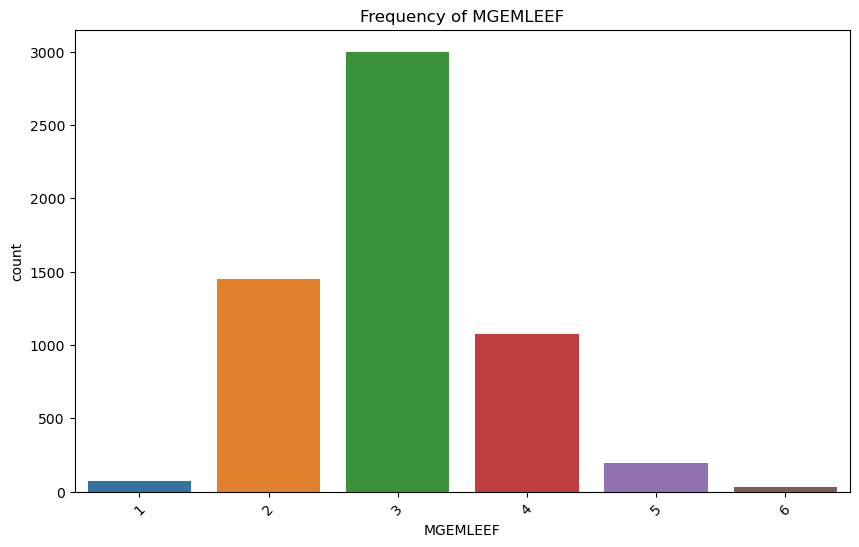

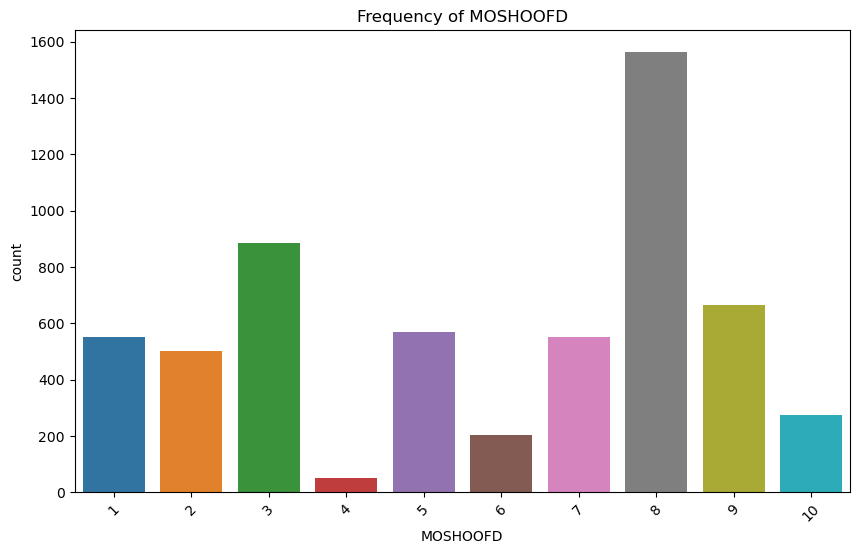

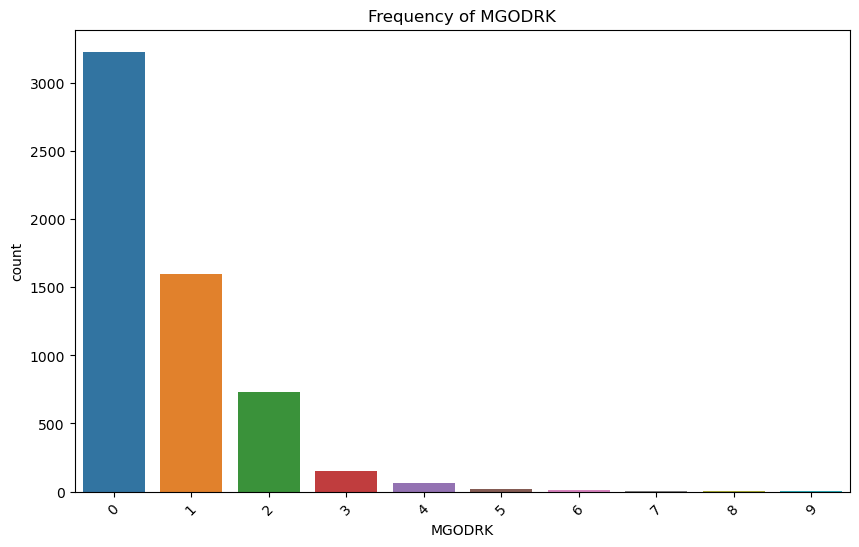

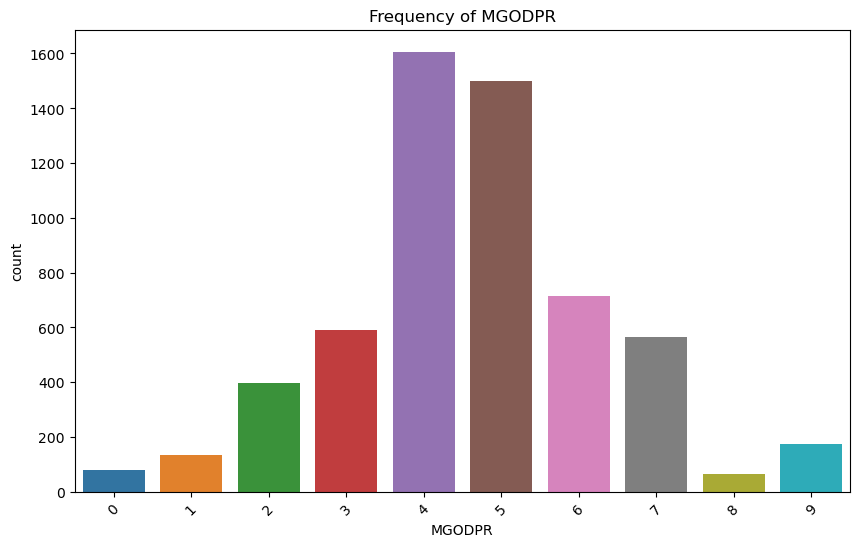

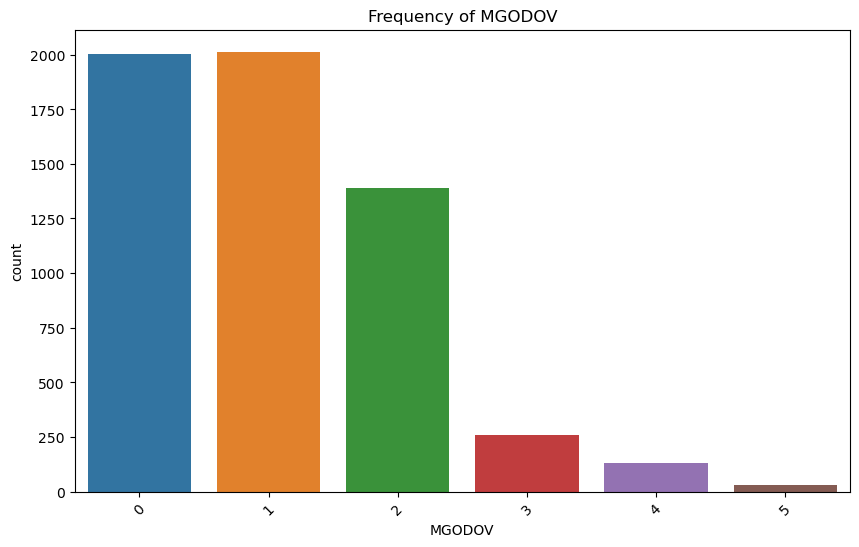

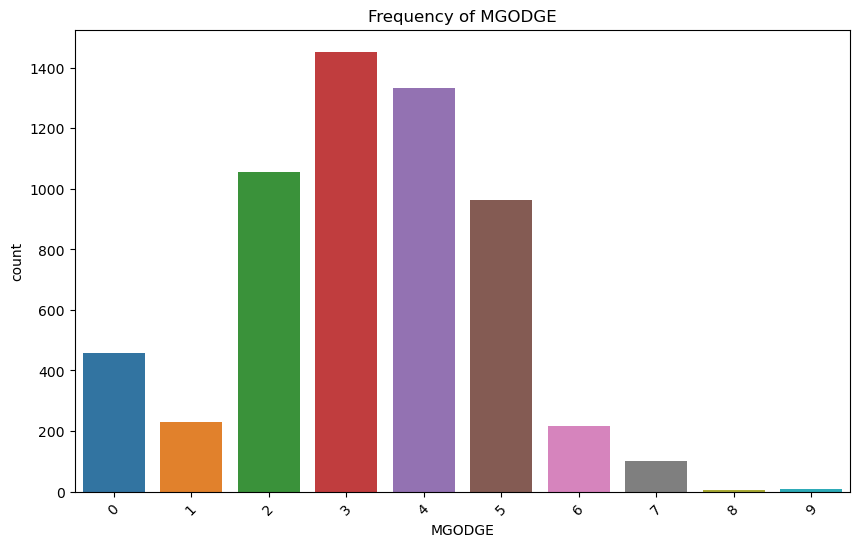

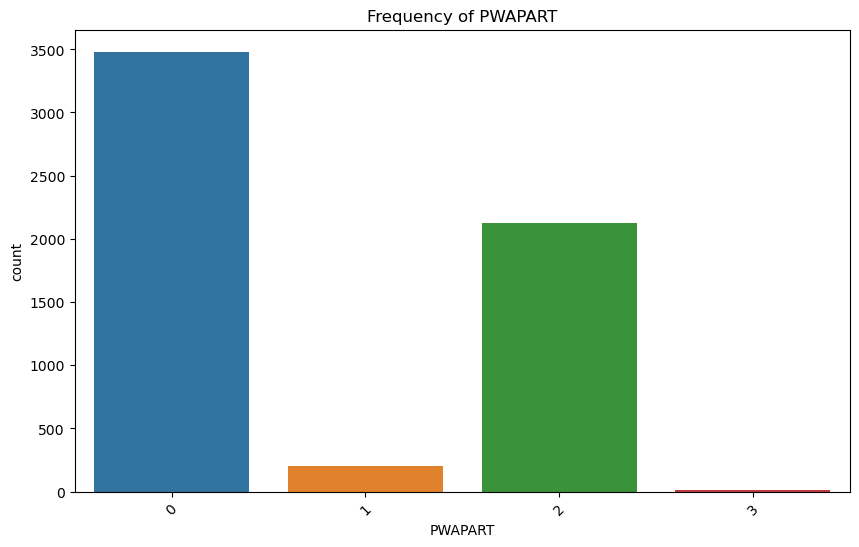

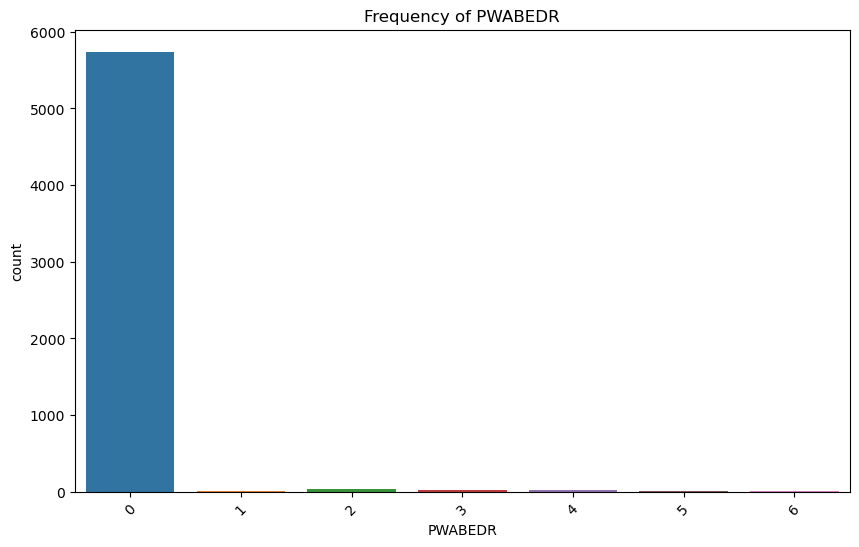

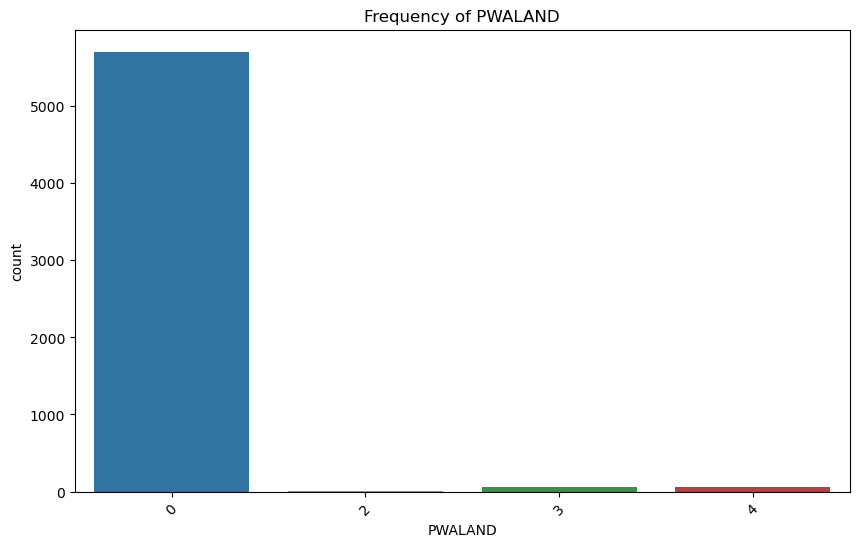

Cross-tabulation for MOSTYPE with CARAVAN:


CARAVAN                                       0   1
MOSTYPE                                            
Affluent senior apartments                   50   2
Affluent young families                      95  16
Career and childcare                        107  12
Couples with teens 'Married with children'  209  16
Dinki's (double income no kids)              41   3
Etnically diverse                            23   2
Family starters                             144   9
Fresh masters in the city                     9   0
High Income, expensive child                111  13
High status seniors                         224  25
Large family farms                           71   0
Large family, employed child                173   9
Large religous families                     309  19
Low income catholics                        199   6
Lower class large families                  764  46
Middle class families                       288  51
Mixed apartment dwellers                     94   4
Mixed rurals                                200   5
Mixed seniors                               176  10
Mixed small town dwellers                   122  10
Modern, complete families                   266  12
Own home elderly                             47   1
Porchless seniors: no front yard             84   2
Religious elderly singles                   114   4
Residential elderly                          25   0
Senior cosmopolitans                          5   0
Seniors in apartments                        49   1
Single youth                                 19   0
Stable family                               156   9
Students in apartments                       16   0
Suburban youth                                3   0
Traditional families                        316  23
Very Important Provincials                   76   6
Village families                            206   8
Young all american family                   166  13
Young and rising                            247   4
Young seniors in the city                    80   2
Young urban have-nots                        15   0
Young, low educated                         175   5

Cross-tabulation for MGEMLEEF with CARAVAN:


CARAVAN         0    1
MGEMLEEF              
20-30 years    73    1
30-40 years  1365   87
40-50 years  2817  183
50-60 years  1009   64
60-70 years   181   12
70-80 years    29    1

Cross-tabulation for MOSHOOFD with CARAVAN:


CARAVAN                   0   1
MOSHOOFD                       
Average Family          827  59
Career Loners            52   0
Conservative families   625  42
Cruising Seniors        201   4
Driven Growers          436  66
Family with grown ups  1474  89
Farmers                 271   5
Living well             554  15
Retired and Religeous   530  20
Successful hedonists    504  48

Cross-tabulation for MGODRK with CARAVAN:


CARAVAN      0    1
MGODRK             
0%        3051  177
1 - 10%   1492  107
100%         4    0
11 - 23%   679   54
24 - 36%   145    7
37 - 49%    65    1
50 - 62%    17    1
63 - 75%    12    1
76 - 88%     6    0
89 - 99%     3    0

Cross-tabulation for MGODPR with CARAVAN:


CARAVAN      0   1
MGODPR            
0%          77   1
1 - 10%    129   5
100%       165   8
11 - 23%   372  24
24 - 36%   561  29
37 - 49%  1520  87
50 - 62%  1404  97
63 - 75%   675  39
76 - 88%   509  55
89 - 99%    62   3

Cross-tabulation for MGODOV with CARAVAN:


CARAVAN      0    1
MGODOV             
0%        1873  130
1 - 10%   1921   93
11 - 23%  1289   99
24 - 36%   239   18
37 - 49%   125    7
50 - 62%    27    1

Cross-tabulation for MGODGE with CARAVAN:


CARAVAN      0   1
MGODGE            
0%         419  37
1 - 10%    209  21
100%         8   0
11 - 23%   986  69
24 - 36%  1366  87
37 - 49%  1264  70
50 - 62%   912  51
63 - 75%   213   4
76 - 88%    92   9
89 - 99%     5   0

Cross-tabulation for PWAPART with CARAVAN:


CARAVAN         0    1
PWAPART               
f 0          3335  147
f 1  49      193    8
f 100  199     9    2
f 50  99    1937  191

Cross-tabulation for PWABEDR with CARAVAN:


CARAVAN           0    1
PWABEDR                 
f 0            5397  343
f 1  49          7    0
f 100  199      20    3
f 1000  4999     4    0
f 200  499      17    0
f 50  99        28    2
f 500  999       1    0

Cross-tabulation for PWALAND with CARAVAN:


CARAVAN         0    1
PWALAND               
f 0          5357  345
f 100  199    55    2
f 200  499    59    1
f 50  99       3    0

In [31]:
# Frequency analysis for categorical features
categorical_columns = [col for col in eda.columns if eda[col].dtype == 'object']
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=train_data[col])
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
    plt.show()

from IPython.display import display

# Cross-tabulation with the target variable
for col in categorical_columns:
    cross_tab = pd.crosstab(eda[col], eda['CARAVAN'])
    print(f'Cross-tabulation for {col} with CARAVAN:')
    display(cross_tab)  # Display the crosstab as a table


In [25]:
train_data.columns

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
       'APLEZIER', 'AFIETS',

In [26]:
train_data['third_party_insurance'] = (train_data[['PWAPART', 'PWABEDR', 'PWALAND', 'AWAPART', 'AWABEDR', 'AWALAND']] > 0).any(axis=1).astype(int)
train_data['vehicle_policies'] = (train_data[['PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PBROM', 'PFIETS', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'ABROM', 'AFIETS']] > 0).any(axis=1).astype(int)
train_data['work_related_policies'] = (train_data[['PBESAUT', 'ABESAUT', 'PVRAAUT', 'AVRAAUT', 'PAANHANG', 'PWERKT', 'PTRACTOR', 'AAANHANG', 'ATRACTOR', 'AWERKT']] > 0).any(axis=1).astype(int)
train_data['farm_policies'] = (train_data[['PAANHANG', 'PTRACTOR', 'PWERKT', 'AAANHANG', 'ATRACTOR', 'AWERKT']] > 0).any(axis=1).astype(int)
train_data['accident_policies'] = (train_data[['PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PINBOED', 'PBYSTAND', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AINBOED', 'ABYSTAND']] > 0).any(axis=1).astype(int)
train_data['acqua_policies'] = (train_data[['PZEILPL', 'PPLEZIER', 'AZEILPL', 'APLEZIER']] > 0).any(axis=1).astype(int)

In [27]:
train_data['holds_policy'] = (train_data[['third_party_insurance', 'vehicle_policies', 'work_related_policies', 'farm_policies', 'accident_policies', 'acqua_policies']] > 0).any(axis=1).astype(int)

In [29]:
train_data.groupby(['holds_policy', 'CARAVAN']).size().reset_index(name='Count')


holds_policy  CARAVAN  Count
0             0        0    609
1             0        1     32
2             1        0   4865
3             1        1    316

In [17]:
# train_data = pd.read_csv('../data/raw/train/ticdata2000.txt', sep='\t', header=None)

In [23]:
target_column = 'CARAVAN' 

In [25]:
train_data[target_column].value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

In [36]:
# DO WE REALLY NEED THIS ???
# REPEAT WITH eval_data AND target_data ???

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Step 1: Separate features and target
X = train_data.drop(columns=[85])  # Drop the target column
y = train_data[85]  # Column 85 represents the "CARAVAN" target


# Step 2: Identify categorical and numerical features
categorical_features = list(range(43))  # Columns 0-42 are considered categorical
numerical_features = list(range(43, 85))  # Columns 43-84 are considered numerical

# Step 3: Preprocessing pipelines for numerical and categorical data
numerical_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median / not needed bc there are no missing values 
    ('scaler', StandardScaler())  # Normalize numerical features
])

categorical_pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent value / not needed bc there are no missing values 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 4: Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Step 5: Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50)

# Step 6: Complete pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('reduce_dim', svd)
])

# Apply the pipeline to the training data
X_processed = pipeline.fit_transform(X)

# Display the shape of the processed data
print("Shape of the processed data:", X_processed.shape)


/Users/martinjaramillo/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Shape of the processed data: (5822, 50)


# What is TruncatedSVD?

**Singular Value Decomposition (SVD)** is a mathematical technique used to factorize a matrix into three other matrices (U, Σ, and V^T). It helps in reducing the dimensionality of data while retaining as much information as possible.

**TruncatedSVD** is a variant of SVD that is particularly useful for reducing the dimensionality of large datasets, especially those that are sparse (e.g., contain many zero values).

---

## Parameters Explained

- **`n_components=50`**:  
  This specifies the number of components (or features) to retain after dimensionality reduction. In this case, the original feature set will be reduced to **50 dimensions**.
  
  - The goal is to keep the most important 50 components that capture the most variance in the original data, while discarding less important components.
  - This helps to reduce the complexity of the model, speed up computations, and improve generalization by removing noise.

---

## Why Use TruncatedSVD?

- **Handles Sparse Data**:  
  Unlike traditional PCA (Principal Component Analysis), **TruncatedSVD** can handle sparse input data (e.g., one-hot encoded categorical features).

- **Reduces Overfitting**:  
  By reducing the number of features, the model is less likely to overfit to noise in the data.

- **Improves Performance**:  
  Lowering the number of dimensions speeds up training and inference time.

---

## How It Works in the Code

1. When **TruncatedSVD** is initialized with `n_components=50`, it will keep the 50 most significant directions in the data (in terms of variance).

2. The **TruncatedSVD** algorithm will project the original high-dimensional data onto this 50-dimensional space, retaining most of the original information but with fewer features.

---

## Summary

This line of code initializes the **TruncatedSVD** object to reduce the dataset's dimensionality to **50 components**, which can help in building more efficient and generalizable models.
